In [571]:
import pandas as pd
import numpy as np
import tensorflow as tf
from os import listdir
from sklearn.model_selection import train_test_split
print ('The version of TensorFlow is {}'.format(tf.__version__))

The version of TensorFlow is 1.4.0


## Load the 12-year incident/accident data

In [572]:
root_path = './data'

appended_data = []
for file_name in listdir(root_path):
    file_path = root_path + '/' + file_name.encode().decode('utf-8')
    data_from_one_csv = pd.read_csv(file_path, skiprows=1)
    appended_data.append(data_from_one_csv)
    
data = pd.concat(appended_data, axis=0)
data = data.drop(columns = ['ACN', 'Date', 'Local Time Of Day', 'Ceiling', 'Callback', 'Callback.1', 'Unnamed: 96'])
data = data.rename(index=str, columns={"Flight Phase": "Flight Phase1"})

## drop the rows with empty synopsis description
data = data[pd.notnull(data['Synopsis'])]

X = data.drop(columns = 'Result')
Y_raw = pd.DataFrame(data['Result'])

processed_Y = []
count_multiple_outcome = 0
for index, row in Y_raw.iterrows():
    #print (index, row['Result'])
    outcome = row['Result']
    if type(outcome) == np.float:
        res = 'unknown'
        processed_Y.append([res])
    elif ';' in outcome:
        count_multiple_outcome += 1
        res = str(outcome).split(';')
        # remove the space at the beginning of each event outcome
        for i in range(len(res)):
            res[i] = res[i].strip()
        #print (res)
        processed_Y.append(res)
    else:
        res = outcome
        processed_Y.append([res])
        
X['res'] = processed_Y ## add the res column first for the use in the subsequent subcategory models

In [573]:
count_multiple_outcome/X.shape[0]

0.502222291050439

## Perform risk-based event outcome cetegorization

In [574]:
## compress the number of labels to be predicted --> map result to risk level
rate_five = ['General Declared Emergency', 'General Physical Injury / Incapacitation', 'Flight Crew Inflight Shutdown', 
             'Air Traffic Control Separated Traffic', 'Aircraft Aircraft Damaged']

rate_four = ['General Evacuated', 'Flight Crew Regained Aircraft Control', 
              'Air Traffic Control Issued Advisory / Alert', 'Flight Crew Landed in Emergency Condition',
              'Flight Crew Landed In Emergency Condition']

rate_three = ['General Work Refused', 'Flight Crew Became Reoriented', 'Flight Crew Diverted', 
             'Flight Crew Executed Go Around / Missed Approach', 
             'Flight Crew Overcame Equipment Problem', 'Flight Crew Rejected Takeoff', 'Flight Crew Took Evasive Action', 
             'Air Traffic Control Issued New Clearance']

rate_two = ['General Maintenance Action', 'General Flight Cancelled / Delayed', 
              'General Release Refused / Aircraft Not Accepted', 
              'Flight Crew Overrode Automation', 'Flight Crew FLC Overrode Automation',
              'Flight Crew Exited Penetrated Airspace', 
              'Flight Crew Requested ATC Assistance / Clarification', 'Flight Crew Landed As Precaution',
              'Flight Crew Returned To Clearance', 'Flight Crew Returned To Departure Airport',
              'Aircraft Automation Overrode Flight Crew']

rate_one = ['General Police / Security Involved', 'Flight Crew Returned To Gate', 'Aircraft Equipment Problem Dissipated', 
            'unknown', 'Air Traffic Control Provided Assistance',
            'General None Reported / Taken', 'Flight Crew FLC complied w / Automation / Advisory']

def risk_quantification(val):
    event_risk = []
    for i in range(len(val)):
        item = val[i].lstrip() ## remove the space at the start of each item
        if item in rate_five:
            event_risk.append(5)
        elif item in rate_four:
            event_risk.append(4)
        elif item in rate_three:
            event_risk.append(3)
        elif item in rate_two:
            event_risk.append(2)
        elif item in rate_one:
            event_risk.append(1)
    return max(event_risk)


Y_ = []
for i in range(len(processed_Y)):
    if len(processed_Y[i]) > 1:
        val = risk_quantification(processed_Y[i])
        Y_.append(val)
    else:
        item_val = "".join(processed_Y[i]) ## convert a list to a string
        #print (item_val)
        if item_val in rate_five:
            Y_.append(5)
        elif item_val in rate_four:
            Y_.append(4)
        elif item_val in rate_three:
            Y_.append(3)
        elif item_val in rate_two:
            Y_.append(2)
        elif item_val in rate_one:
            Y_.append(1)
        else:
            print (Y['Result'][i])

outcomes = np.asarray(Y_)
Y_true = pd.DataFrame(Y_, index = X.index, columns = ['Result'])
unique, counts = np.unique(outcomes, return_counts=True)
print (unique, counts)

[1 2 3 4 5] [16508  8636 18841  8261 12327]


## Up-sampling the minority classes

In [343]:
from sklearn.utils import resample

data_rev = X.copy(deep=True)
data_rev['Result'] = Y_true

df_majority_1 = data_rev[data_rev['Result']==1]
df_majority_3 = data_rev[data_rev['Result']==3]
df_minority_2 = data_rev[data_rev['Result']==2]
df_minority_4 = data_rev[data_rev['Result']==4]
df_minority_5 = data_rev[data_rev['Result']==5]

# Upsample minority class
df_minority_2_upsampled = resample(df_minority_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=18841,    # to match majority class
                                 random_state=145) # reproducible results
df_minority_4_upsampled = resample(df_minority_4, 
                                 replace=True,     # sample with replacement
                                 n_samples=18841,    # to match majority class
                                 random_state=145) # reproducible results
df_minority_5_upsampled = resample(df_minority_5, 
                                 replace=True,     # sample with replacement
                                 n_samples=18841,    # to match majority class
                                 random_state=145) # reproducible results

df_upsampled = pd.concat([df_majority_1, df_majority_3, df_minority_2_upsampled, df_minority_4_upsampled, 
                          df_minority_5_upsampled])

df_upsampled['Result'].value_counts()

X = df_upsampled.drop(columns = 'Result')
Y_true = df_upsampled['Result']

unique, counts = np.unique(Y_true, return_counts=True)
print ('After the upsampling, the number of each item is: \n')
print (unique)
print (counts)

After the upsampling, the number of each item is: 

[1 2 3 4 5]
[16508 18841 18841 18841 18841]


In [344]:
## copy the data
X_org = X.copy(deep=True)
Y_org = Y_true.copy(deep=True)
X_org.shape

(91872, 90)

## Split the data, the data has three parts: 
##### X_train, Y_train: train the data
##### X_validation, Y_validation: trial data to obtain the performance metrics
##### X_test, Y_test: test data used to compare the performance of hybrid model with SVM and DNN

In [345]:
from sklearn.model_selection import train_test_split

test_random_state = 111
X, X_test, Y, Y_test = train_test_split(X_org, Y_org, test_size = 0.1, random_state = test_random_state)

## Split the data

In [346]:
from sklearn.model_selection import train_test_split

test_size_ratio = 0.06
random_split_seed = 200
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size = test_size_ratio, 
                                                    random_state = random_split_seed)

## Pipeline: Naive Bayes

In [299]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB(alpha = 1, fit_prior=True)),
                    ])

text_clf.fit(X_train['Synopsis'], Y_train)
pred_label_NB = text_clf.predict(X_validation['Synopsis'])

from sklearn.metrics import classification_report
target_names = [str(i) for i in range(1, 5+1)]
print(classification_report(Y_validation, pred_label_NB, target_names=target_names))

             precision    recall  f1-score   support

          1       0.63      0.49      0.55       947
          2       0.67      0.65      0.66      1017
          3       0.49      0.38      0.43       988
          4       0.56      0.61      0.58      1034
          5       0.57      0.78      0.66       976

avg / total       0.58      0.58      0.58      4962



## Model 1: Support Vector Machine with Linear Kernel

In [300]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

text_clf = Pipeline([('vect', CountVectorizer(stop_words = 'english')),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(loss='epsilon_insensitive', penalty='l2',
                                            alpha=1e-5, random_state=40,
                                            max_iter=10, tol=None)),
                    ])


parameters = {'clf__loss': ['epsilon_insensitive', 'hinge', 'log', 'huber', 'modified_huber', 'perceptron', 
                            'squared_loss', 'squared_epsilon_insensitive', 'squared_hinge'],
              'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3, 1e-4, 1e-5),
              'clf__penalty': ['l1', 'l2', 'elasticnet'],
              'clf__max_iter': (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
 }

optimal_parameters = {'clf__loss': ['modified_huber'],
              'vect__ngram_range':  [(1, 2)],
              'tfidf__use_idf': [True],
              'clf__alpha': [1e-5],
              'clf__penalty': ['elasticnet'],
              'clf__max_iter': [80],
 }

gs_clf = GridSearchCV(text_clf, optimal_parameters, n_jobs=-1)

gs_clf.fit(X_train['Synopsis'], Y_train)
pred_label_SVM = gs_clf.predict(X_validation['Synopsis'])

from sklearn.metrics import classification_report
target_names = [str(i) for i in range(1, 6)]
print(classification_report(Y_validation, pred_label_SVM, target_names=target_names))

             precision    recall  f1-score   support

          1       0.73      0.58      0.65       947
          2       0.85      0.94      0.89      1017
          3       0.66      0.60      0.63       988
          4       0.81      0.91      0.86      1034
          5       0.87      0.90      0.88       976

avg / total       0.78      0.79      0.78      4962



In [301]:
print ('Accuracy: ', np.sum(np.equal(Y_validation, pred_label_SVM).astype(int))/20367)
print ('The best set of parameters is \n', gs_clf.best_params_)

Accuracy:  0.19241910934354592
The best set of parameters is 
 {'clf__alpha': 1e-05, 'clf__loss': 'modified_huber', 'clf__max_iter': 80, 'clf__penalty': 'elasticnet', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}


## Training SVM models for category-level event outcome

In [350]:
print (X_train['res'][121].tolist())
print (Y_train[X_train.index][1])

['Air Traffic Control Issued New Clearance', 'Aircraft Equipment Problem Dissipated', 'Flight Crew Returned To Clearance']
3


220
3
Find it
946
3
Find it
1023
2
Find it
1895
1
Find it
2517
2
Find it
672
3
Find it
860
5
Find it
2452
3
Find it
2393
2
Find it
2440
3
Find it
2281
2
Find it
522
4
Find it
663
3
Find it
1662
3
Find it
567
1
Find it
2256
4
Find it
1471
1
Find it
2100
3
Find it
19
1
Find it
120
2
Find it
1673
5
Find it
736
3
Find it
470
5
Find it
1400
2
Find it
378
3
Find it
609
5
Find it
1746
1
Find it
2862
1
Find it
2573
4
Find it
2353
2
Find it
907
2
Find it
393
4
Find it
1810
4
Find it
504
3
Find it
1126
3
Find it
1071
4
Find it
1474
2
Find it
22
3
Find it
2254
3
Find it
166
3
Find it
1688
2
Find it
438
5
Find it
95
4
Find it
2406
5
Find it
1550
3
Find it
2195
3
Find it
911
5
Find it
1150
4
Find it
803
5
Find it
2230
1
Find it
121
5
Find it
2507
5
Find it
2468
5
Find it
281
2
Find it
2699
1
Find it
1573
1
Find it
1870
5
Find it
1865
2
Find it
3227
2
Find it
1429
4
Find it
634
4
Find it
1517
2
Find it
578
4
Find it
1397
4
Find it
1543
1
Find it
394
5
Find it
3540
2
Find it
1854
2
Find it
1998
4
Fin

Find it
897
5
Find it
1400
4
Find it
2787
4
Find it
2064
3
Find it
1346
4
Find it
1350
1
Find it
2961
1
Find it
1406
5
Find it
53
2
Find it
633
4
Find it
1202
2
Find it
813
5
Find it
2493
4
Find it
1030
2
Find it
232
1
Find it
3107
1
Find it
922
3
Find it
281
5
Find it
346
3
Find it
776
3
Find it
1736
4
Find it
2150
1
Find it
1426
2
Find it
4
1
Find it
1001
2
Find it
456
4
Find it
1137
2
Find it
2369
5
Find it
2717
4
Find it
2334
2
Find it
53
2
Find it
307
4
Find it
4
3
Find it
1028
3
Find it
913
5
Find it
2737
2
Find it
1263
5
Find it
764
3
Find it
588
4
Find it
2111
5
Find it
1322
2
Find it
2000
5
Find it
145
3
Find it
1156
3
Find it
1033
5
Find it
1611
3
Find it
382
4
Find it
50
2
Find it
706
1
Find it
2153
4
Find it
2393
3
Find it
1773
5
Find it
2
5
Find it
1779
4
Find it
1311
1
Find it
957
2
Find it
1699
4
Find it
715
3
Find it
2933
1
Find it
1268
4
Find it
907
5
Find it
1926
4
Find it
1329
5
Find it
304
2
Find it
984
4
Find it
225
5
Find it
669
3
Find it
48
1
Find it
2022
2
Find 

Find it
202
4
Find it
1376
4
Find it
318
3
Find it
3580
2
Find it
1064
2
Find it
45
1
Find it
1727
5
Find it
204
3
Find it
1857
5
Find it
139
1
Find it
112
4
Find it
1098
5
Find it
2287
1
Find it
1195
2
Find it
1570
4
Find it
1487
3
Find it
117
5
Find it
2726
4
Find it
1475
3
Find it
2094
2
Find it
295
2
Find it
3396
3
Find it
869
5
Find it
644
3
Find it
2151
4
Find it
2274
1
Find it
671
4
Find it
600
5
Find it
485
3
Find it
925
1
Find it
983
4
Find it
62
5
Find it
38
3
Find it
1095
2
Find it
1310
1
Find it
298
4
Find it
1196
4
Find it
1175
2
Find it
1695
4
Find it
2106
2
Find it
1218
5
Find it
1147
3
Find it
21
4
Find it
424
5
Find it
2694
4
Find it
327
1
Find it
1963
3
Find it
330
5
Find it
2545
3
Find it
1599
5
Find it
88
5
Find it
1823
5
Find it
1111
2
Find it
736
4
Find it
1721
2
Find it
1503
2
Find it
2033
5
Find it
1444
5
Find it
2398
4
Find it
828
4
Find it
299
1
Find it
1159
2
Find it
547
5
Find it
2524
2
Find it
1495
4
Find it
826
4
Find it
724
1
Find it
1708
4
Find it
2406
1

Find it
2454
3
Find it
676
4
Find it
2835
1
Find it
1597
1
Find it
1780
2
Find it
2208
1
Find it
1446
1
Find it
535
3
Find it
277
1
Find it
2328
5
Find it
1023
1
Find it
871
3
Find it
1306
2
Find it
301
4
Find it
1653
5
Find it
2218
3
Find it
363
3
Find it
928
5
Find it
1803
1
Find it
1505
2
Find it
1692
3
Find it
1189
5
Find it
726
5
Find it
423
5
Find it
394
3
Find it
696
3
Find it
1325
4
Find it
222
2
Find it
811
5
Find it
2331
5
Find it
762
5
Find it
2279
4
Find it
471
2
Find it
1882
4
Find it
2111
5
Find it
2039
5
Find it
1153
2
Find it
1940
3
Find it
2056
5
Find it
1197
2
Find it
548
5
Find it
102
5
Find it
2187
1
Find it
1593
5
Find it
1497
4
Find it
602
1
Find it
2606
4
Find it
38
5
Find it
1451
5
Find it
690
5
Find it
184
5
Find it
766
3
Find it
1045
5
Find it
2505
5
Find it
729
2
Find it
777
4
Find it
174
3
Find it
129
3
Find it
417
1
Find it
1268
4
Find it
1340
3
Find it
1937
3
Find it
849
4
Find it
2984
1
Find it
2422
3
Find it
1085
5
Find it
1636
2
Find it
1204
2
Find it
1

5
Find it
978
1
Find it
2499
1
Find it
553
5
Find it
641
4
Find it
763
2
Find it
478
1
Find it
1425
4
Find it
677
4
Find it
897
2
Find it
427
4
Find it
295
2
Find it
895
3
Find it
2722
1
Find it
1049
5
Find it
1545
5
Find it
906
3
Find it
890
1
Find it
1359
5
Find it
972
4
Find it
673
5
Find it
1837
1
Find it
2012
3
Find it
419
2
Find it
214
1
Find it
75
5
Find it
1721
4
Find it
2050
3
Find it
2791
4
Find it
1861
2
Find it
668
5
Find it
1903
2
Find it
1782
5
Find it
1568
1
Find it
2996
3
Find it
618
5
Find it
818
5
Find it
1975
3
Find it
2200
3
Find it
1350
3
Find it
1618
4
Find it
1496
2
Find it
1173
2
Find it
2918
3
Find it
3216
4
Find it
2231
5
Find it
2658
3
Find it
2427
1
Find it
879
2
Find it
734
2
Find it
1007
2
Find it
1942
5
Find it
1610
2
Find it
1015
2
Find it
404
3
Find it
71
3
Find it
85
5
Find it
835
4
Find it
1220
3
Find it
2344
3
Find it
723
3
Find it
2779
3
Find it
1258
3
Find it
235
5
Find it
1660
3
Find it
436
4
Find it
78
4
Find it
526
5
Find it
1153
1
Find it
1466


Find it
1656
2
Find it
2358
5
Find it
654
5
Find it
1282
5
Find it
2606
2
Find it
1499
3
Find it
1294
2
Find it
925
5
Find it
1478
2
Find it
2662
2
Find it
3111
5
Find it
2761
2
Find it
2684
5
Find it
1446
3
Find it
2082
3
Find it
1322
2
Find it
1281
3
Find it
1405
5
Find it
1433
3
Find it
1977
2
Find it
543
3
Find it
2457
2
Find it
2007
4
Find it
2179
2
Find it
2008
2
Find it
176
2
Find it
792
4
Find it
255
3
Find it
1502
5
Find it
2471
4
Find it
1547
5
Find it
1495
2
Find it
388
3
Find it
2383
1
Find it
1693
1
Find it
1615
3
Find it
738
2
Find it
1316
3
Find it
2556
1
Find it
557
3
Find it
1821
1
Find it
1565
2
Find it
1108
3
Find it
2244
3
Find it
2267
1
Find it
1081
5
Find it
2067
5
Find it
1120
2
Find it
3045
1
Find it
773
4
Find it
862
4
Find it
2414
2
Find it
2463
2
Find it
504
5
Find it
55
5
Find it
1038
5
Find it
962
5
Find it
856
2
Find it
2123
2
Find it
1155
4
Find it
1301
2
Find it
2035
4
Find it
2553
3
Find it
276
4
Find it
1232
3
Find it
1164
5
Find it
419
5
Find it
2357


Find it
176
2
Find it
1533
1
Find it
712
3
Find it
763
3
Find it
2328
4
Find it
590
2
Find it
594
3
Find it
2854
3
Find it
2063
2
Find it
2267
1
Find it
654
4
Find it
300
3
Find it
582
1
Find it
955
3
Find it
997
3
Find it
1007
2
Find it
2420
4
Find it
1190
2
Find it
436
2
Find it
1497
4
Find it
2666
4
Find it
1016
5
Find it
1170
5
Find it
607
3
Find it
1706
3
Find it
817
3
Find it
1326
5
Find it
1707
3
Find it
1902
1
Find it
593
4
Find it
2494
3
Find it
1183
4
Find it
1588
1
Find it
424
5
Find it
980
5
Find it
244
3
Find it
2549
2
Find it
2023
3
Find it
1069
3
Find it
1101
3
Find it
3311
5
Find it
423
2
Find it
182
2
Find it
2073
3
Find it
1427
5
Find it
1271
5
Find it
2634
5
Find it
957
4
Find it
1144
3
Find it
1230
2
Find it
381
2
Find it
696
3
Find it
760
3
Find it
2700
1
Find it
240
5
Find it
1432
3
Find it
2145
4
Find it
18
2
Find it
2719
2
Find it
2142
4
Find it
3371
4
Find it
2337
3
Find it
2393
3
Find it
1271
2
Find it
1685
4
Find it
2573
4
Find it
2000
3
Find it
1698
2
Find i

3
Find it
2215
3
Find it
1595
3
Find it
363
2
Find it
2345
4
Find it
1263
1
Find it
1624
3
Find it
2710
2
Find it
578
2
Find it
865
4
Find it
1068
3
Find it
2149
3
Find it
1367
5
Find it
1853
1
Find it
2599
3
Find it
1149
5
Find it
2164
2
Find it
35
4
Find it
138
1
Find it
857
2
Find it
133
4
Find it
17
4
Find it
731
3
Find it
1903
4
Find it
2340
1
Find it
2944
5
Find it
807
2
Find it
51
3
Find it
2431
2
Find it
2923
1
Find it
671
2
Find it
1718
4
Find it
2696
1
Find it
2324
1
Find it
1740
3
Find it
20
3
Find it
139
3
Find it
1155
4
Find it
2115
2
Find it
909
1
Find it
814
3
Find it
1426
1
Find it
1366
1
Find it
281
5
Find it
678
4
Find it
2474
1
Find it
1677
5
Find it
691
2
Find it
1459
2
Find it
2426
1
Find it
1522
5
Find it
922
3
Find it
1649
5
Find it
2283
1
Find it
1103
1
Find it
2103
1
Find it
2186
3
Find it
1479
5
Find it
2152
5
Find it
2569
4
Find it
416
1
Find it
508
3
Find it
1391
1
Find it
3156
3
Find it
3549
5
Find it
2268
4
Find it
2404
5
Find it
2025
1
Find it
1474
1
Find

Find it
595
2
Find it
1770
4
Find it
708
1
Find it
2578
4
Find it
2152
3
Find it
3100
4
Find it
1744
2
Find it
1464
4
Find it
2115
2
Find it
537
4
Find it
147
4
Find it
1139
5
Find it
1913
3
Find it
1754
5
Find it
1908
2
Find it
337
5
Find it
1280
1
Find it
154
3
Find it
2495
5
Find it
1317
3
Find it
2814
5
Find it
2348
5
Find it
144
4
Find it
513
5
Find it
185
5
Find it
258
4
Find it
2537
1
Find it
2152
5
Find it
1945
5
Find it
571
1
Find it
891
5
Find it
2095
1
Find it
747
1
Find it
1190
3
Find it
1412
2
Find it
2480
1
Find it
289
3
Find it
1803
2
Find it
1810
1
Find it
1624
3
Find it
3244
4
Find it
1584
2
Find it
1847
2
Find it
381
5
Find it
582
1
Find it
624
3
Find it
1634
4
Find it
1772
4
Find it
1744
2
Find it
2276
5
Find it
1489
2
Find it
492
1
Find it
1484
5
Find it
2106
3
Find it
157
2
Find it
485
4
Find it
2075
4
Find it
2063
2
Find it
3097
3
Find it
2018
1
Find it
289
4
Find it
1214
1
Find it
990
3
Find it
994
5
Find it
1626
4
Find it
2516
4
Find it
586
5
Find it
1402
5
Find

Find it
186
3
Find it
78
3
Find it
1556
2
Find it
399
3
Find it
381
3
Find it
1288
4
Find it
1855
3
Find it
1945
1
Find it
1017
5
Find it
2704
4
Find it
758
2
Find it
216
5
Find it
3086
5
Find it
2687
3
Find it
85
5
Find it
910
4
Find it
2458
5
Find it
2067
2
Find it
66
3
Find it
1997
5
Find it
1027
4
Find it
44
5
Find it
574
3
Find it
707
1
Find it
1376
4
Find it
2863
1
Find it
801
3
Find it
258
4
Find it
1239
5
Find it
1326
1
Find it
275
4
Find it
1840
2
Find it
1313
4
Find it
67
5
Find it
348
2
Find it
2366
5
Find it
984
1
Find it
829
5
Find it
2640
4
Find it
2369
4
Find it
1723
1
Find it
857
4
Find it
266
3
Find it
2162
5
Find it
96
1
Find it
2532
5
Find it
359
4
Find it
3003
3
Find it
861
5
Find it
1065
5
Find it
1685
4
Find it
1717
4
Find it
2175
1
Find it
550
3
Find it
2275
5
Find it
950
4
Find it
1749
3
Find it
2094
2
Find it
2272
1
Find it
2003
3
Find it
1165
1
Find it
55
5
Find it
729
2
Find it
1288
3
Find it
240
4
Find it
1868
1
Find it
137
3
Find it
1234
3
Find it
1727
5
Fi

Find it
1090
2
Find it
1897
4
Find it
1053
2
Find it
258
4
Find it
1467
2
Find it
1132
5
Find it
2932
1
Find it
1611
1
Find it
2578
4
Find it
2332
5
Find it
530
2
Find it
1045
5
Find it
2325
5
Find it
2144
3
Find it
1583
1
Find it
1219
4
Find it
2880
1
Find it
580
2
Find it
2252
1
Find it
277
4
Find it
1745
5
Find it
1331
5
Find it
953
3
Find it
2525
4
Find it
1544
3
Find it
3
5
Find it
911
4
Find it
2438
2
Find it
1142
3
Find it
1637
4
Find it
2115
3
Find it
74
4
Find it
2506
3
Find it
2074
1
Find it
993
2
Find it
1995
5
Find it
2516
4
Find it
2887
1
Find it
268
4
Find it
2789
3
Find it
436
2
Find it
1713
4
Find it
1431
4
Find it
197
5
Find it
813
5
Find it
927
2
Find it
526
5
Find it
605
5
Find it
2115
2
Find it
1862
5
Find it
1122
2
Find it
442
2
Find it
1813
1
Find it
608
3
Find it
2991
2
Find it
1823
3
Find it
1551
4
Find it
1139
4
Find it
1121
2
Find it
595
3
Find it
2071
5
Find it
1704
3
Find it
2032
3
Find it
1529
4
Find it
1354
3
Find it
1448
4
Find it
1805
5
Find it
557
5
Fin

Find it
505
4
Find it
899
5
Find it
2035
1
Find it
704
5
Find it
728
3
Find it
2883
3
Find it
3143
4
Find it
1614
5
Find it
2498
3
Find it
1031
5
Find it
2031
2
Find it
949
3
Find it
1473
3
Find it
859
5
Find it
2264
2
Find it
344
5
Find it
2560
1
Find it
1350
4
Find it
759
5
Find it
728
4
Find it
235
2
Find it
2606
4
Find it
218
4
Find it
1423
1
Find it
528
4
Find it
303
4
Find it
2930
3
Find it
1962
3
Find it
652
2
Find it
256
3
Find it
1215
2
Find it
237
2
Find it
1313
1
Find it
608
3
Find it
618
5
Find it
450
4
Find it
1914
2
Find it
2077
1
Find it
1259
4
Find it
923
5
Find it
1504
4
Find it
1510
3
Find it
1996
5
Find it
457
5
Find it
869
4
Find it
2423
2
Find it
2573
3
Find it
755
5
Find it
530
4
Find it
378
3
Find it
2124
2
Find it
999
4
Find it
2015
5
Find it
1698
3
Find it
488
5
Find it
1662
3
Find it
1758
5
Find it
171
4
Find it
2354
3
Find it
410
4
Find it
1820
4
Find it
1036
3
Find it
587
4
Find it
1461
5
Find it
405
2
Find it
2290
3
Find it
875
2
Find it
654
3
Find it
61
5


Find it
2746
4
Find it
701
3
Find it
786
1
Find it
2788
4
Find it
422
5
Find it
869
5
Find it
53
2
Find it
1495
5
Find it
392
5
Find it
1398
5
Find it
331
5
Find it
1696
3
Find it
1381
5
Find it
1041
5
Find it
225
2
Find it
2407
2
Find it
1917
3
Find it
740
4
Find it
2784
4
Find it
833
3
Find it
3
2
Find it
2202
5
Find it
1479
2
Find it
1562
5
Find it
1524
1
Find it
819
3
Find it
1797
3
Find it
11
4
Find it
695
5
Find it
1174
1
Find it
243
3
Find it
1040
5
Find it
192
3
Find it
2717
5
Find it
836
3
Find it
779
2
Find it
407
5
Find it
1201
4
Find it
296
2
Find it
117
2
Find it
2280
3
Find it
1188
5
Find it
2254
1
Find it
1877
4
Find it
176
4
Find it
221
5
Find it
991
2
Find it
2244
4
Find it
2601
2
Find it
2089
4
Find it
852
2
Find it
1635
3
Find it
1009
4
Find it
671
1
Find it
80
1
Find it
1170
2
Find it
1956
2
Find it
2169
2
Find it
1681
5
Find it
2092
4
Find it
2258
3
Find it
750
3
Find it
54
3
Find it
26
2
Find it
1005
3
Find it
510
1
Find it
2300
4
Find it
373
2
Find it
54
2
Find i

Find it
1310
1
Find it
1186
5
Find it
1556
3
Find it
3493
3
Find it
827
2
Find it
285
5
Find it
250
3
Find it
1667
1
Find it
671
4
Find it
1365
4
Find it
1668
4
Find it
408
2
Find it
2784
3
Find it
937
2
Find it
876
3
Find it
1550
2
Find it
952
1
Find it
1542
4
Find it
1157
2
Find it
1675
4
Find it
470
2
Find it
1722
5
Find it
1962
2
Find it
1258
1
Find it
886
2
Find it
1999
1
Find it
1492
4
Find it
79
2
Find it
302
2
Find it
394
5
Find it
1225
3
Find it
2076
2
Find it
2727
4
Find it
2755
2
Find it
1387
5
Find it
1721
3
Find it
1982
2
Find it
101
3
Find it
820
5
Find it
2438
1
Find it
1288
4
Find it
2374
5
Find it
1510
3
Find it
2413
4
Find it
520
2
Find it
1748
4
Find it
1404
1
Find it
908
4
Find it
2418
3
Find it
1807
4
Find it
2037
2
Find it
439
5
Find it
2522
3
Find it
2070
4
Find it
734
2
Find it
1596
3
Find it
56
5
Find it
1354
2
Find it
1027
2
Find it
2469
5
Find it
2195
5
Find it
3053
3
Find it
2673
4
Find it
888
1
Find it
2013
3
Find it
1745
4
Find it
1503
2
Find it
2245
3
Fin

2
Find it
1112
4
Find it
2313
1
Find it
2457
5
Find it
190
5
Find it
2300
1
Find it
1920
2
Find it
975
2
Find it
1012
5
Find it
850
1
Find it
1853
5
Find it
1339
2
Find it
2547
2
Find it
1776
1
Find it
2936
2
Find it
531
4
Find it
971
4
Find it
647
3
Find it
1755
3
Find it
1245
4
Find it
2724
4
Find it
1350
3
Find it
3135
2
Find it
1853
1
Find it
605
4
Find it
1862
3
Find it
60
1
Find it
1786
4
Find it
1546
4
Find it
943
3
Find it
2842
3
Find it
730
5
Find it
1768
1
Find it
1098
5
Find it
334
1
Find it
836
5
Find it
237
3
Find it
865
4
Find it
1055
5
Find it
6
5
Find it
179
5
Find it
1738
3
Find it
2877
2
Find it
911
1
Find it
171
1
Find it
325
3
Find it
3135
2
Find it
412
5
Find it
747
4
Find it
1206
5
Find it
306
4
Find it
2120
3
Find it
1508
3
Find it
937
5
Find it
281
4
Find it
408
5
Find it
1501
5
Find it
1986
3
Find it
1297
3
Find it
2216
3
Find it
1898
1
Find it
2370
3
Find it
215
3
Find it
2482
2
Find it
2291
1
Find it
1000
5
Find it
2107
4
Find it
1162
3
Find it
1690
4
Find it

Find it
641
5
Find it
541
3
Find it
2293
4
Find it
403
5
Find it
927
4
Find it
1470
5
Find it
1648
5
Find it
1820
4
Find it
1751
5
Find it
1285
1
Find it
1593
3
Find it
2508
1
Find it
520
3
Find it
2212
1
Find it
1715
2
Find it
977
4
Find it
192
3
Find it
2289
3
Find it
554
2
Find it
1227
1
Find it
1278
3
Find it
723
3
Find it
2393
2
Find it
542
4
Find it
1930
5
Find it
2645
5
Find it
1819
4
Find it
676
5
Find it
1350
2
Find it
1849
3
Find it
1686
5
Find it
176
4
Find it
859
4
Find it
1123
3
Find it
1891
5
Find it
887
4
Find it
802
3
Find it
69
5
Find it
633
2
Find it
1135
1
Find it
2155
2
Find it
2422
1
Find it
21
2
Find it
2127
1
Find it
228
2
Find it
2156
2
Find it
3217
5
Find it
2213
1
Find it
1325
2
Find it
1697
1
Find it
404
1
Find it
971
5
Find it
2036
1
Find it
882
4
Find it
2404
5
Find it
83
5
Find it
215
1
Find it
1006
4
Find it
2189
5
Find it
645
2
Find it
1655
3
Find it
218
1
Find it
2941
5
Find it
1632
4
Find it
1613
3
Find it
76
1
Find it
599
5
Find it
264
2
Find it
2176


Find it
772
1
Find it
344
3
Find it
1846
4
Find it
2058
1
Find it
787
2
Find it
2171
5
Find it
943
3
Find it
1247
2
Find it
977
4
Find it
1471
1
Find it
416
2
Find it
147
4
Find it
1994
1
Find it
1932
3
Find it
1351
1
Find it
1822
5
Find it
1099
4
Find it
210
1
Find it
2918
4
Find it
619
4
Find it
245
2
Find it
1198
2
Find it
2013
2
Find it
1994
1
Find it
1961
5
Find it
255
2
Find it
1759
5
Find it
1015
1
Find it
2186
2
Find it
291
4
Find it
2156
5
Find it
763
2
Find it
1006
4
Find it
2287
1
Find it
617
4
Find it
2313
3
Find it
667
4
Find it
764
3
Find it
1289
1
Find it
1007
5
Find it
2003
3
Find it
607
3
Find it
832
2
Find it
1377
4
Find it
1354
3
Find it
2589
5
Find it
1401
5
Find it
2367
4
Find it
2042
4
Find it
1748
4
Find it
1655
2
Find it
318
2
Find it
135
3
Find it
521
2
Find it
257
2
Find it
2461
2
Find it
2508
5
Find it
816
5
Find it
1486
2
Find it
2056
1
Find it
2381
1
Find it
840
2
Find it
2532
2
Find it
1206
2
Find it
928
2
Find it
2651
3
Find it
1175
1
Find it
2267
3
Find 

Find it
2581
1
Find it
2005
2
Find it
1051
1
Find it
557
3
Find it
2238
1
Find it
2149
4
Find it
1538
3
Find it
1357
5
Find it
2135
4
Find it
1253
1
Find it
517
3
Find it
1174
3
Find it
1350
5
Find it
2586
4
Find it
1291
5
Find it
1716
4
Find it
535
5
Find it
1189
4
Find it
1303
5
Find it
7
4
Find it
344
2
Find it
415
4
Find it
511
4
Find it
239
2
Find it
1105
3
Find it
41
4
Find it
1927
4
Find it
1560
2
Find it
1773
2
Find it
1375
2
Find it
1740
2
Find it
1188
3
Find it
2288
1
Find it
2446
2
Find it
2360
4
Find it
2738
3
Find it
987
2
Find it
1507
1
Find it
985
1
Find it
2149
2
Find it
638
5
Find it
1185
3
Find it
437
4
Find it
210
1
Find it
748
5
Find it
2406
2
Find it
1475
2
Find it
219
4
Find it
572
3
Find it
80
1
Find it
1247
5
Find it
2278
2
Find it
921
1
Find it
1216
1
Find it
2431
4
Find it
2364
3
Find it
1920
4
Find it
595
4
Find it
1079
2
Find it
2185
4
Find it
2165
2
Find it
746
2
Find it
854
1
Find it
880
3
Find it
2172
3
Find it
1654
3
Find it
1258
5
Find it
236
3
Find it


Find it
1456
2
Find it
2095
4
Find it
670
3
Find it
2432
4
Find it
126
4
Find it
2361
4
Find it
1189
5
Find it
183
5
Find it
1009
3
Find it
1048
4
Find it
749
3
Find it
2125
1
Find it
1808
5
Find it
67
3
Find it
939
5
Find it
1778
4
Find it
971
2
Find it
1476
1
Find it
2568
3
Find it
565
5
Find it
2213
2
Find it
969
2
Find it
61
3
Find it
1155
4
Find it
1228
5
Find it
806
4
Find it
861
5
Find it
78
5
Find it
742
1
Find it
980
5
Find it
2152
3
Find it
1289
5
Find it
3221
1
Find it
1217
5
Find it
2434
1
Find it
1242
1
Find it
1555
1
Find it
236
1
Find it
2218
3
Find it
746
4
Find it
2297
5
Find it
1819
4
Find it
132
2
Find it
2567
4
Find it
613
4
Find it
1820
4
Find it
1099
3
Find it
1515
4
Find it
1503
4
Find it
842
2
Find it
2128
1
Find it
261
5
Find it
1954
4
Find it
244
4
Find it
69
2
Find it
220
5
Find it
1917
5
Find it
244
5
Find it
2345
3
Find it
433
1
Find it
8
3
Find it
1940
5
Find it
1320
1
Find it
1276
4
Find it
734
2
Find it
504
3
Find it
833
1
Find it
1610
4
Find it
1284
5
F

Find it
1991
3
Find it
541
1
Find it
210
1
Find it
276
5
Find it
650
1
Find it
2463
4
Find it
1308
3
Find it
794
5
Find it
503
5
Find it
1057
5
Find it
2332
5
Find it
183
1
Find it
2585
5
Find it
959
1
Find it
1728
1
Find it
2515
5
Find it
3188
5
Find it
348
5
Find it
917
1
Find it
2145
4
Find it
1752
1
Find it
1417
1
Find it
1403
3
Find it
2335
2
Find it
988
5
Find it
14
4
Find it
1010
1
Find it
270
2
Find it
1849
1
Find it
2188
4
Find it
659
5
Find it
1441
2
Find it
146
2
Find it
1240
4
Find it
1819
4
Find it
443
4
Find it
45
3
Find it
1386
1
Find it
1921
3
Find it
661
4
Find it
1521
1
Find it
2510
4
Find it
972
4
Find it
2651
2
Find it
2412
5
Find it
188
2
Find it
382
1
Find it
2046
5
Find it
1502
3
Find it
2466
5
Find it
1227
2
Find it
2486
3
Find it
1969
5
Find it
1822
4
Find it
3176
2
Find it
928
3
Find it
200
4
Find it
1543
1
Find it
1647
1
Find it
185
4
Find it
2277
1
Find it
1583
2
Find it
1678
2
Find it
1277
1
Find it
340
4
Find it
2399
2
Find it
2231
4
Find it
1802
4
Find it

4
Find it
619
4
Find it
2739
4
Find it
1053
1
Find it
1650
5
Find it
2575
4
Find it
152
5
Find it
1446
5
Find it
2197
5
Find it
831
2
Find it
1267
1
Find it
122
4
Find it
453
2
Find it
1828
5
Find it
2099
4
Find it
1372
2
Find it
3429
3
Find it
305
1
Find it
1992
2
Find it
514
1
Find it
1780
4
Find it
1819
1
Find it
582
1
Find it
1078
1
Find it
276
3
Find it
1261
3
Find it
1081
4
Find it
1615
2
Find it
1103
2
Find it
1761
4
Find it
2521
4
Find it
270
3
Find it
2090
3
Find it
1142
4
Find it
115
4
Find it
1292
5
Find it
1404
4
Find it
2650
3
Find it
1143
2
Find it
2235
5
Find it
669
1
Find it
2151
1
Find it
328
1
Find it
981
1
Find it
384
4
Find it
188
2
Find it
28
4
Find it
1421
4
Find it
2310
5
Find it
2251
5
Find it
2744
4
Find it
998
4
Find it
272
2
Find it
1129
4
Find it
1093
2
Find it
2884
3
Find it
2164
1
Find it
1739
1
Find it
2534
1
Find it
2677
4
Find it
301
5
Find it
315
4
Find it
1481
3
Find it
2601
1
Find it
1586
4
Find it
18
4
Find it
861
2
Find it
635
1
Find it
1428
4
Find

Find it
1313
4
Find it
622
2
Find it
892
5
Find it
1880
1
Find it
1572
5
Find it
3035
4
Find it
412
5
Find it
59
4
Find it
1422
1
Find it
2861
1
Find it
2361
4
Find it
216
5
Find it
32
3
Find it
827
3
Find it
771
2
Find it
2102
4
Find it
2266
2
Find it
343
1
Find it
2100
2
Find it
366
3
Find it
1960
3
Find it
177
3
Find it
2051
3
Find it
560
4
Find it
2396
5
Find it
693
4
Find it
1654
3
Find it
1499
5
Find it
1642
1
Find it
277
5
Find it
2131
2
Find it
528
4
Find it
749
5
Find it
1967
1
Find it
1644
2
Find it
158
3
Find it
1252
2
Find it
28
3
Find it
648
2
Find it
467
2
Find it
1074
5
Find it
259
5
Find it
1608
2
Find it
953
3
Find it
1433
1
Find it
1459
1
Find it
2212
4
Find it
548
5
Find it
1030
5
Find it
306
3
Find it
1154
1
Find it
1560
3
Find it
2114
5
Find it
397
2
Find it
2669
2
Find it
688
5
Find it
856
2
Find it
942
3
Find it
1772
2
Find it
83
2
Find it
1224
2
Find it
3390
5
Find it
2442
3
Find it
702
5
Find it
1998
3
Find it
561
2
Find it
1667
4
Find it
753
2
Find it
1939
5
F

Find it
570
1
Find it
919
2
Find it
1293
1
Find it
1280
1
Find it
315
1
Find it
2135
4
Find it
822
2
Find it
1421
4
Find it
933
4
Find it
430
3
Find it
2297
3
Find it
275
1
Find it
14
4
Find it
2643
5
Find it
1262
5
Find it
51
2
Find it
863
2
Find it
1177
3
Find it
1744
2
Find it
2183
2
Find it
1307
4
Find it
2617
5
Find it
1468
4
Find it
434
4
Find it
972
4
Find it
1990
1
Find it
1722
4
Find it
1001
1
Find it
2850
5
Find it
1953
1
Find it
191
1
Find it
2012
1
Find it
2492
3
Find it
2147
4
Find it
1124
5
Find it
2
4
Find it
1335
4
Find it
1147
1
Find it
1108
5
Find it
2224
3
Find it
2744
1
Find it
587
4
Find it
202
4
Find it
722
3
Find it
1553
4
Find it
167
4
Find it
728
5
Find it
383
3
Find it
2446
2
Find it
2962
1
Find it
1271
3
Find it
1968
2
Find it
701
3
Find it
681
1
Find it
2627
1
Find it
1090
4
Find it
899
2
Find it
1454
3
Find it
258
4
Find it
2158
1
Find it
1701
1
Find it
647
4
Find it
2095
5
Find it
747
5
Find it
2339
4
Find it
2843
2
Find it
3204
2
Find it
504
2
Find it
264

1286
5
Find it
1976
1
Find it
949
1
Find it
2502
3
Find it
637
5
Find it
2133
4
Find it
2956
1
Find it
2227
2
Find it
2043
1
Find it
388
4
Find it
3033
2
Find it
1031
2
Find it
569
1
Find it
1582
1
Find it
874
3
Find it
1710
4
Find it
971
4
Find it
1792
5
Find it
849
4
Find it
667
3
Find it
53
1
Find it
1470
2
Find it
2993
2
Find it
700
1
Find it
2598
1
Find it
350
4
Find it
480
3
Find it
835
3
Find it
188
5
Find it
3216
2
Find it
485
4
Find it
2123
2
Find it
1488
3
Find it
1854
3
Find it
70
3
Find it
238
4
Find it
354
1
Find it
1346
4
Find it
1976
3
Find it
567
2
Find it
2908
4
Find it
30
5
Find it
2143
4
Find it
1295
4
Find it
1864
4
Find it
2196
5
Find it
2914
4
Find it
2057
1
Find it
718
4
Find it
2161
4
Find it
1663
1
Find it
344
4
Find it
804
5
Find it
2103
5
Find it
543
4
Find it
2153
4
Find it
2768
2
Find it
1887
3
Find it
2707
2
Find it
1708
1
Find it
765
3
Find it
1557
1
Find it
1429
3
Find it
785
4
Find it
304
5
Find it
725
2
Find it
835
1
Find it
1804
5
Find it
1919
2
Find 

Find it
1959
4
Find it
1710
4
Find it
1984
4
Find it
1728
4
Find it
86
2
Find it
1525
5
Find it
2716
5
Find it
1207
4
Find it
2658
2
Find it
1057
1
Find it
1765
1
Find it
830
1
Find it
2353
3
Find it
380
5
Find it
727
5
Find it
387
5
Find it
501
5
Find it
3451
5
Find it
1896
4
Find it
1305
3
Find it
2845
3
Find it
436
5
Find it
2035
1
Find it
3094
4
Find it
1097
2
Find it
2361
2
Find it
3169
2
Find it
3015
2
Find it
1909
2
Find it
231
2
Find it
2838
3
Find it
1261
2
Find it
2468
2
Find it
1085
2
Find it
619
1
Find it
1263
1
Find it
1845
1
Find it
862
3
Find it
1010
3
Find it
419
3
Find it
204
5
Find it
2500
5
Find it
2129
4
Find it
2407
3
Find it
879
2
Find it
2317
2
Find it
64
2
Find it
1910
4
Find it
2795
3
Find it
805
3
Find it
1792
4
Find it
550
4
Find it
1752
1
Find it
1498
4
Find it
342
4
Find it
1199
1
Find it
972
5
Find it
3004
3
Find it
934
4
Find it
1800
2
Find it
134
3
Find it
2526
3
Find it
655
2
Find it
1653
2
Find it
1146
4
Find it
759
1
Find it
2721
3
Find it
1553
3
Find

Find it
630
1
Find it
719
5
Find it
3489
4
Find it
962
1
Find it
1668
4
Find it
738
2
Find it
2303
3
Find it
601
4
Find it
3119
1
Find it
1504
2
Find it
2793
2
Find it
3127
4
Find it
1468
5
Find it
1487
2
Find it
1135
2
Find it
617
3
Find it
2683
2
Find it
1352
4
Find it
1715
2
Find it
2266
2
Find it
2487
4
Find it
2038
5
Find it
200
1
Find it
2692
4
Find it
2014
2
Find it
2858
4
Find it
1083
1
Find it
1413
2
Find it
238
4
Find it
2430
3
Find it
1095
1
Find it
1590
4
Find it
2166
4
Find it
339
5
Find it
1861
2
Find it
2789
1
Find it
399
4
Find it
2323
5
Find it
761
4
Find it
1252
1
Find it
2057
5
Find it
1113
5
Find it
821
5
Find it
52
1
Find it
1566
4
Find it
1381
5
Find it
1274
2
Find it
2430
2
Find it
349
5
Find it
630
5
Find it
733
1
Find it
2946
1
Find it
1526
3
Find it
2660
4
Find it
1947
5
Find it
1310
4
Find it
1986
2
Find it
2111
1
Find it
869
3
Find it
896
3
Find it
1981
4
Find it
1800
5
Find it
1984
3
Find it
1131
1
Find it
2652
1
Find it
2546
3
Find it
1649
1
Find it
711
1


Find it
861
3
Find it
64
2
Find it
2570
1
Find it
1415
3
Find it
569
5
Find it
878
1
Find it
279
2
Find it
2395
2
Find it
1705
2
Find it
384
2
Find it
1090
4
Find it
2039
1
Find it
379
2
Find it
2447
1
Find it
1422
1
Find it
2967
5
Find it
2452
5
Find it
1293
2
Find it
2942
2
Find it
1668
4
Find it
2705
4
Find it
963
2
Find it
1494
3
Find it
1987
4
Find it
1598
2
Find it
1458
5
Find it
328
2
Find it
713
4
Find it
2575
1
Find it
766
4
Find it
921
1
Find it
2720
4
Find it
556
3
Find it
2209
5
Find it
18
3
Find it
248
2
Find it
2298
5
Find it
93
4
Find it
2951
1
Find it
2865
2
Find it
1605
3
Find it
2841
1
Find it
257
2
Find it
2297
3
Find it
705
4
Find it
1569
2
Find it
1033
5
Find it
1010
5
Find it
1344
5
Find it
358
2
Find it
2872
1
Find it
1136
4
Find it
884
2
Find it
757
3
Find it
2889
1
Find it
2523
3
Find it
2471
4
Find it
1201
4
Find it
2325
1
Find it
1682
1
Find it
2048
4
Find it
2735
3
Find it
1164
3
Find it
1653
4
Find it
1983
5
Find it
1337
2
Find it
530
1
Find it
1487
4
Find 

2
Find it
1352
3
Find it
2331
3
Find it
2333
2
Find it
2725
4
Find it
2802
2
Find it
1170
3
Find it
2756
3
Find it
1836
2
Find it
257
1
Find it
822
1
Find it
2433
5
Find it
469
3
Find it
1319
3
Find it
2400
5
Find it
1291
5
Find it
1282
4
Find it
856
2
Find it
958
3
Find it
238
3
Find it
468
1
Find it
2019
4
Find it
2347
2
Find it
1676
4
Find it
1450
3
Find it
713
3
Find it
2195
3
Find it
1280
5
Find it
919
2
Find it
889
3
Find it
723
2
Find it
1253
1
Find it
1107
5
Find it
1556
4
Find it
272
4
Find it
1012
1
Find it
774
3
Find it
1271
4
Find it
2463
5
Find it
6
3
Find it
77
4
Find it
1285
5
Find it
1356
3
Find it
1226
5
Find it
1300
5
Find it
1402
1
Find it
291
5
Find it
872
1
Find it
1400
5
Find it
2283
3
Find it
1754
3
Find it
1074
1
Find it
1865
3
Find it
1209
2
Find it
1391
1
Find it
1880
4
Find it
1112
4
Find it
985
3
Find it
1326
4
Find it
851
2
Find it
738
3
Find it
1284
1
Find it
135
4
Find it
32
3
Find it
1295
2
Find it
2058
3
Find it
903
3
Find it
1721
3
Find it
508
5
Find i

Find it
1498
4
Find it
1324
1
Find it
1485
2
Find it
622
1
Find it
1080
4
Find it
3173
3
Find it
2329
3
Find it
1689
2
Find it
3157
4
Find it
2375
2
Find it
2366
3
Find it
683
4
Find it
934
1
Find it
828
3
Find it
2424
1
Find it
2068
4
Find it
2076
5
Find it
1052
4
Find it
2460
3
Find it
1163
3
Find it
1868
2
Find it
1953
5
Find it
1154
3
Find it
974
2
Find it
902
3
Find it
1290
5
Find it
1695
3
Find it
1919
4
Find it
835
5
Find it
2669
1
Find it
1996
4
Find it
340
5
Find it
2097
4
Find it
1903
1
Find it
1554
1
Find it
2528
3
Find it
652
4
Find it
2389
4
Find it
3154
2
Find it
1221
2
Find it
2540
4
Find it
1379
5
Find it
752
3
Find it
2135
4
Find it
969
4
Find it
696
2
Find it
2058
3
Find it
2024
1
Find it
866
5
Find it
2428
3
Find it
1345
5
Find it
128
2
Find it
2200
1
Find it
2007
1
Find it
2047
4
Find it
1060
3
Find it
2681
1
Find it
400
3
Find it
1267
2
Find it
2590
3
Find it
1554
5
Find it
100
3
Find it
1031
1
Find it
1895
2
Find it
34
3
Find it
614
3
Find it
1100
4
Find it
3048
3

Find it
1756
4
Find it
2223
3
Find it
629
3
Find it
2113
2
Find it
1585
2
Find it
938
4
Find it
1663
3
Find it
1674
3
Find it
1096
1
Find it
466
5
Find it
1396
1
Find it
785
5
Find it
507
1
Find it
2475
1
Find it
1681
5
Find it
500
3
Find it
583
5
Find it
148
1
Find it
1087
3
Find it
2477
2
Find it
2558
2
Find it
526
1
Find it
1824
4
Find it
2156
1
Find it
2529
2
Find it
3035
4
Find it
1178
2
Find it
714
2
Find it
1188
5
Find it
1024
2
Find it
2331
4
Find it
448
3
Find it
2086
2
Find it
1273
4
Find it
1897
2
Find it
742
2
Find it
1211
3
Find it
485
2
Find it
514
5
Find it
453
3
Find it
952
5
Find it
1078
3
Find it
603
1
Find it
2845
3
Find it
1328
3
Find it
2156
2
Find it
1510
3
Find it
856
1
Find it
1817
4
Find it
16
1
Find it
1101
4
Find it
1473
4
Find it
1584
2
Find it
560
2
Find it
1354
5
Find it
1880
1
Find it
2006
1
Find it
615
5
Find it
585
2
Find it
640
4
Find it
968
2
Find it
1103
1
Find it
2121
5
Find it
1959
3
Find it
1327
3
Find it
358
3
Find it
857
1
Find it
902
3
Find it


Find it
23
1
Find it
937
1
Find it
1716
3
Find it
1686
5
Find it
2349
4
Find it
3055
5
Find it
140
2
Find it
2118
3
Find it
471
2
Find it
2173
1
Find it
2415
5
Find it
233
5
Find it
1166
1
Find it
1849
3
Find it
429
5
Find it
192
2
Find it
2310
5
Find it
2838
5
Find it
937
2
Find it
352
3
Find it
2294
1
Find it
1685
1
Find it
2967
4
Find it
2231
3
Find it
1825
1
Find it
329
3
Find it
1719
4
Find it
2897
3
Find it
595
4
Find it
2598
4
Find it
734
1
Find it
1665
1
Find it
1264
3
Find it
1808
1
Find it
2465
5
Find it
2445
1
Find it
1133
3
Find it
2247
3
Find it
1744
4
Find it
1653
4
Find it
1674
1
Find it
1789
3
Find it
1796
1
Find it
2881
4
Find it
1162
3
Find it
870
5
Find it
1913
5
Find it
1047
5
Find it
1590
3
Find it
107
3
Find it
1103
4
Find it
981
1
Find it
365
3
Find it
375
1
Find it
1951
2
Find it
771
2
Find it
2734
1
Find it
524
1
Find it
304
2
Find it
2304
3
Find it
411
1
Find it
2335
4
Find it
1321
3
Find it
752
5
Find it
2859
4
Find it
88
3
Find it
1572
5
Find it
328
5
Find i

Find it
815
3
Find it
2209
2
Find it
490
1
Find it
1231
4
Find it
2316
4
Find it
1414
5
Find it
2870
2
Find it
380
2
Find it
823
1
Find it
2333
2
Find it
2139
5
Find it
908
1
Find it
154
5
Find it
154
2
Find it
139
2
Find it
1489
2
Find it
1007
5
Find it
1350
4
Find it
2557
3
Find it
590
1
Find it
1941
2
Find it
594
4
Find it
1944
5
Find it
2576
2
Find it
1266
1
Find it
1047
5
Find it
1286
1
Find it
2527
3
Find it
1978
5
Find it
2954
2
Find it
1724
4
Find it
1466
1
Find it
612
4
Find it
1720
5
Find it
1598
2
Find it
229
2
Find it
1554
5
Find it
2389
5
Find it
2255
5
Find it
1535
2
Find it
398
4
Find it
1695
1
Find it
2190
4
Find it
557
1
Find it
187
1
Find it
1693
3
Find it
2524
4
Find it
2435
4
Find it
112
1
Find it
2511
2
Find it
806
2
Find it
2438
1
Find it
1576
3
Find it
2424
2
Find it
813
4
Find it
1210
3
Find it
2030
2
Find it
712
4
Find it
985
5
Find it
1873
4
Find it
1416
4
Find it
1198
4
Find it
886
1
Find it
2377
5
Find it
252
1
Find it
2011
1
Find it
2602
1
Find it
1807
3
Fi

Find it
1331
5
Find it
2414
2
Find it
1449
1
Find it
242
3
Find it
447
2
Find it
2816
1
Find it
377
3
Find it
268
1
Find it
178
3
Find it
570
3
Find it
1988
3
Find it
739
4
Find it
2338
5
Find it
112
3
Find it
1038
5
Find it
871
2
Find it
1242
1
Find it
249
1
Find it
2021
4
Find it
1833
4
Find it
380
5
Find it
2412
5
Find it
2284
5
Find it
575
1
Find it
2023
1
Find it
2381
3
Find it
774
5
Find it
2321
1
Find it
2769
1
Find it
686
2
Find it
1666
5
Find it
2477
2
Find it
1673
1
Find it
445
3
Find it
2017
2
Find it
3140
3
Find it
1780
2
Find it
321
3
Find it
2475
3
Find it
1156
3
Find it
52
1
Find it
2323
2
Find it
1777
3
Find it
1329
5
Find it
1901
2
Find it
1896
5
Find it
756
5
Find it
199
4
Find it
3094
3
Find it
933
1
Find it
1242
4
Find it
1821
5
Find it
1859
1
Find it
654
3
Find it
2362
4
Find it
791
5
Find it
2843
1
Find it
231
2
Find it
1003
3
Find it
2366
2
Find it
292
2
Find it
905
5
Find it
629
2
Find it
2146
1
Find it
2621
3
Find it
2313
3
Find it
30
5
Find it
486
4
Find it
27

Find it
26
2
Find it
1616
1
Find it
2403
2
Find it
1063
4
Find it
194
3
Find it
2282
1
Find it
1151
2
Find it
2367
3
Find it
1509
4
Find it
2003
3
Find it
22
2
Find it
978
2
Find it
1732
5
Find it
604
4
Find it
2594
1
Find it
1156
4
Find it
1540
2
Find it
1688
2
Find it
1778
3
Find it
911
4
Find it
729
2
Find it
1903
2
Find it
61
5
Find it
2431
4
Find it
432
5
Find it
704
3
Find it
417
4
Find it
1001
5
Find it
953
2
Find it
1524
3
Find it
1650
3
Find it
1296
5
Find it
1356
3
Find it
419
1
Find it
219
5
Find it
1011
3
Find it
1399
3
Find it
256
4
Find it
1678
2
Find it
2572
2
Find it
1212
4
Find it
951
4
Find it
525
1
Find it
1492
4
Find it
968
4
Find it
2106
2
Find it
1207
5
Find it
1629
3
Find it
1673
3
Find it
1631
2
Find it
2116
2
Find it
2508
1
Find it
650
1
Find it
514
2
Find it
406
1
Find it
2470
4
Find it
779
2
Find it
1805
3
Find it
549
1
Find it
1804
2
Find it
1208
3
Find it
1441
3
Find it
1736
3
Find it
706
3
Find it
685
2
Find it
297
5
Find it
1907
5
Find it
2746
4
Find it
7

4
Find it
2080
1
Find it
2060
4
Find it
973
4
Find it
2741
2
Find it
2660
4
Find it
699
4
Find it
2067
5
Find it
509
4
Find it
1749
2
Find it
3034
2
Find it
2824
5
Find it
1688
3
Find it
1256
4
Find it
368
3
Find it
1550
4
Find it
1965
3
Find it
3573
2
Find it
56
2
Find it
63
2
Find it
1623
3
Find it
286
5
Find it
140
3
Find it
803
3
Find it
1073
4
Find it
1323
5
Find it
643
5
Find it
1505
4
Find it
189
4
Find it
755
5
Find it
565
3
Find it
16
5
Find it
1061
2
Find it
1657
2
Find it
2361
3
Find it
1720
2
Find it
294
1
Find it
1807
2
Find it
147
3
Find it
1554
5
Find it
2244
2
Find it
1901
5
Find it
1625
2
Find it
1746
3
Find it
2828
5
Find it
1941
5
Find it
520
1
Find it
268
5
Find it
362
5
Find it
1297
2
Find it
799
5
Find it
1475
2
Find it
563
3
Find it
1227
1
Find it
1921
5
Find it
1801
2
Find it
178
3
Find it
2677
4
Find it
3225
2
Find it
2363
3
Find it
2550
2
Find it
1089
4
Find it
1633
5
Find it
1579
1
Find it
1665
2
Find it
1630
1
Find it
1806
5
Find it
381
2
Find it
752
5
Find 

5
Find it
2276
2
Find it
666
5
Find it
1282
5
Find it
753
1
Find it
705
2
Find it
1623
3
Find it
2532
1
Find it
487
5
Find it
3072
2
Find it
297
4
Find it
443
4
Find it
480
3
Find it
2302
1
Find it
1962
4
Find it
354
1
Find it
1397
5
Find it
929
2
Find it
122
3
Find it
533
2
Find it
16
3
Find it
637
4
Find it
1986
1
Find it
2035
4
Find it
165
2
Find it
1227
3
Find it
1526
5
Find it
626
3
Find it
21
5
Find it
1863
1
Find it
552
3
Find it
1258
2
Find it
2281
5
Find it
1793
4
Find it
442
5
Find it
1832
5
Find it
1684
1
Find it
1014
2
Find it
2221
4
Find it
2937
3
Find it
2091
3
Find it
3085
5
Find it
865
5
Find it
2870
2
Find it
1364
1
Find it
292
3
Find it
2444
2
Find it
886
5
Find it
2031
1
Find it
54
2
Find it
982
3
Find it
179
3
Find it
2848
1
Find it
1877
4
Find it
1934
1
Find it
922
2
Find it
340
2
Find it
677
3
Find it
302
2
Find it
1089
2
Find it
820
5
Find it
637
1
Find it
1681
4
Find it
1656
5
Find it
333
5
Find it
1186
5
Find it
72
3
Find it
1149
1
Find it
1577
2
Find it
1280
4

Find it
313
5
Find it
1741
3
Find it
1758
3
Find it
1863
5
Find it
1999
2
Find it
1451
3
Find it
1897
4
Find it
2445
1
Find it
2160
3
Find it
1313
4
Find it
1848
5
Find it
2799
2
Find it
2031
5
Find it
1448
4
Find it
477
4
Find it
1911
4
Find it
1880
1
Find it
262
3
Find it
15
5
Find it
2184
3
Find it
3134
2
Find it
200
4
Find it
1128
4
Find it
121
3
Find it
2268
1
Find it
2533
4
Find it
1824
3
Find it
3220
2
Find it
2589
1
Find it
2201
2
Find it
905
1
Find it
334
5
Find it
2193
5
Find it
661
4
Find it
1001
3
Find it
790
1
Find it
2331
4
Find it
668
3
Find it
362
2
Find it
1777
1
Find it
991
4
Find it
2780
3
Find it
2909
5
Find it
2534
5
Find it
916
3
Find it
3005
5
Find it
1432
1
Find it
2469
3
Find it
170
1
Find it
616
2
Find it
1641
5
Find it
492
5
Find it
926
3
Find it
172
2
Find it
1553
5
Find it
1319
3
Find it
265
1
Find it
2283
4
Find it
2711
3
Find it
2084
1
Find it
716
5
Find it
1942
5
Find it
1982
4
Find it
1662
5
Find it
2098
4
Find it
2477
3
Find it
1482
2
Find it
1641
1
Fi

Find it
1685
3
Find it
2296
1
Find it
1679
3
Find it
464
5
Find it
2229
2
Find it
194
5
Find it
1984
2
Find it
1093
2
Find it
891
1
Find it
2669
2
Find it
3516
1
Find it
1088
3
Find it
479
4
Find it
432
5
Find it
690
5
Find it
219
4
Find it
1113
2
Find it
635
3
Find it
1262
5
Find it
1446
3
Find it
420
3
Find it
1012
3
Find it
2011
3
Find it
2347
3
Find it
1706
4
Find it
2300
5
Find it
2427
4
Find it
2788
1
Find it
2849
2
Find it
2282
4
Find it
2560
2
Find it
2713
2
Find it
224
2
Find it
2382
1
Find it
1446
4
Find it
1357
5
Find it
1673
5
Find it
1416
5
Find it
91
3
Find it
472
5
Find it
639
3
Find it
2713
1
Find it
1454
2
Find it
707
1
Find it
934
1
Find it
2460
2
Find it
2159
5
Find it
898
2
Find it
970
5
Find it
296
5
Find it
289
3
Find it
846
4
Find it
2378
1
Find it
2662
2
Find it
2895
3
Find it
447
1
Find it
850
5
Find it
1952
3
Find it
1840
3
Find it
1567
4
Find it
138
4
Find it
2212
4
Find it
2174
1
Find it
359
2
Find it
2522
1
Find it
500
2
Find it
893
2
Find it
2105
4
Find it

Find it
2339
3
Find it
1289
2
Find it
40
2
Find it
1844
3
Find it
448
2
Find it
1229
4
Find it
1691
1
Find it
724
3
Find it
881
3
Find it
1316
2
Find it
427
3
Find it
1108
1
Find it
1265
1
Find it
1901
3
Find it
911
2
Find it
433
5
Find it
1483
5
Find it
1772
1
Find it
1167
2
Find it
753
5
Find it
643
3
Find it
240
1
Find it
1672
4
Find it
298
5
Find it
521
2
Find it
1559
1
Find it
1893
5
Find it
883
5
Find it
1541
1
Find it
625
4
Find it
347
5
Find it
1945
5
Find it
78
1
Find it
1149
3
Find it
2087
3
Find it
1542
3
Find it
2242
5
Find it
2519
1
Find it
150
5
Find it
3102
5
Find it
894
3
Find it
164
5
Find it
922
5
Find it
2838
1
Find it
1825
5
Find it
1244
5
Find it
1080
1
Find it
271
2
Find it
415
5
Find it
1051
1
Find it
1759
3
Find it
2594
3
Find it
2708
3
Find it
1444
2
Find it
2202
5
Find it
862
2
Find it
1897
2
Find it
398
4
Find it
742
2
Find it
1592
4
Find it
2050
2
Find it
1342
4
Find it
29
3
Find it
1176
1
Find it
116
5
Find it
1661
3
Find it
1614
2
Find it
318
2
Find it
149

Find it
423
4
Find it
756
1
Find it
718
1
Find it
762
1
Find it
1448
1
Find it
1143
3
Find it
2076
4
Find it
51
2
Find it
1860
4
Find it
2817
4
Find it
1627
3
Find it
2578
4
Find it
2778
2
Find it
1885
1
Find it
1121
4
Find it
1576
3
Find it
1029
5
Find it
612
3
Find it
846
2
Find it
2833
4
Find it
200
2
Find it
1236
3
Find it
3427
1
Find it
1511
1
Find it
1667
5
Find it
753
4
Find it
2850
5
Find it
220
2
Find it
2443
3
Find it
2439
1
Find it
1099
1
Find it
2642
1
Find it
1479
5
Find it
2330
3
Find it
2314
4
Find it
1613
3
Find it
1047
4
Find it
2008
1
Find it
808
5
Find it
1144
3
Find it
318
1
Find it
801
3
Find it
804
3
Find it
1824
4
Find it
2099
4
Find it
1417
1
Find it
454
1
Find it
715
4
Find it
145
1
Find it
1186
1
Find it
2422
3
Find it
394
1
Find it
2833
4
Find it
213
5
Find it
3055
1
Find it
2191
3
Find it
249
4
Find it
2129
5
Find it
951
2
Find it
2213
3
Find it
520
1
Find it
1185
4
Find it
1083
1
Find it
317
3
Find it
2083
3
Find it
579
1
Find it
2785
1
Find it
188
2
Find i

5
Find it
1701
3
Find it
1883
2
Find it
439
1
Find it
1786
2
Find it
1944
2
Find it
1915
5
Find it
330
2
Find it
1239
4
Find it
1222
4
Find it
793
1
Find it
1814
4
Find it
2267
3
Find it
28
2
Find it
2102
1
Find it
2185
3
Find it
305
5
Find it
61
1
Find it
811
2
Find it
1404
1
Find it
241
1
Find it
983
2
Find it
1753
4
Find it
2289
3
Find it
2156
1
Find it
600
5
Find it
313
2
Find it
1045
4
Find it
843
4
Find it
1666
3
Find it
1287
1
Find it
1644
1
Find it
1966
3
Find it
992
4
Find it
778
1
Find it
1835
4
Find it
663
3
Find it
2062
1
Find it
2336
1
Find it
561
4
Find it
3029
4
Find it
1142
4
Find it
485
1
Find it
864
4
Find it
206
3
Find it
1765
3
Find it
3387
1
Find it
1241
4
Find it
2573
1
Find it
1350
2
Find it
1600
4
Find it
170
4
Find it
1236
4
Find it
2185
1
Find it
2489
5
Find it
2463
4
Find it
699
4
Find it
778
1
Find it
2534
2
Find it
1576
3
Find it
28
1
Find it
1334
2
Find it
586
2
Find it
2606
4
Find it
1899
1
Find it
1718
3
Find it
35
4
Find it
880
4
Find it
2496
5
Find it


3
Find it
763
4
Find it
72
3
Find it
2885
5
Find it
1368
4
Find it
2340
2
Find it
2524
5
Find it
289
3
Find it
1923
4
Find it
368
3
Find it
768
5
Find it
3204
2
Find it
2463
4
Find it
711
3
Find it
829
3
Find it
1031
4
Find it
2442
2
Find it
804
4
Find it
1372
5
Find it
301
5
Find it
3069
1
Find it
3213
4
Find it
525
5
Find it
1154
3
Find it
2200
2
Find it
575
5
Find it
2014
1
Find it
946
5
Find it
1584
5
Find it
702
3
Find it
410
4
Find it
1123
2
Find it
2681
3
Find it
2543
3
Find it
362
2
Find it
244
1
Find it
613
1
Find it
1642
3
Find it
790
4
Find it
206
2
Find it
1512
4
Find it
1940
1
Find it
636
5
Find it
929
5
Find it
1647
3
Find it
1054
2
Find it
807
2
Find it
2400
3
Find it
648
5
Find it
1399
3
Find it
1014
5
Find it
2871
2
Find it
3057
5
Find it
2118
3
Find it
77
4
Find it
842
3
Find it
1877
5
Find it
29
4
Find it
954
2
Find it
1293
5
Find it
762
2
Find it
18
3
Find it
293
3
Find it
161
5
Find it
1322
2
Find it
2001
4
Find it
2627
3
Find it
104
4
Find it
1473
4
Find it
2510
4

Find it
2187
2
Find it
1303
1
Find it
2854
2
Find it
1846
2
Find it
1708
1
Find it
957
5
Find it
1089
2
Find it
503
4
Find it
845
1
Find it
82
1
Find it
410
5
Find it
3069
2
Find it
2327
3
Find it
671
5
Find it
845
3
Find it
2197
2
Find it
820
2
Find it
2095
1
Find it
1130
2
Find it
1202
3
Find it
205
5
Find it
908
1
Find it
59
5
Find it
993
3
Find it
2319
3
Find it
516
3
Find it
2132
3
Find it
2488
3
Find it
876
5
Find it
123
4
Find it
1259
5
Find it
751
3
Find it
349
1
Find it
128
5
Find it
170
3
Find it
12
4
Find it
1677
5
Find it
665
3
Find it
1650
2
Find it
2379
4
Find it
2538
3
Find it
2059
4
Find it
1286
2
Find it
245
2
Find it
2345
1
Find it
2509
5
Find it
442
3
Find it
1030
3
Find it
1427
1
Find it
1806
5
Find it
884
2
Find it
1897
5
Find it
1190
5
Find it
3132
1
Find it
203
5
Find it
3
1
Find it
977
1
Find it
2092
3
Find it
446
3
Find it
301
1
Find it
159
3
Find it
524
4
Find it
579
4
Find it
1124
1
Find it
593
2
Find it
304
1
Find it
2729
4
Find it
2058
3
Find it
2595
1
Find

Find it
665
3
Find it
1636
5
Find it
1949
5
Find it
675
5
Find it
1998
4
Find it
2490
3
Find it
359
2
Find it
1066
4
Find it
936
1
Find it
3060
1
Find it
824
3
Find it
792
5
Find it
106
1
Find it
2802
1
Find it
1568
2
Find it
799
5
Find it
365
1
Find it
1805
1
Find it
2538
4
Find it
1477
3
Find it
946
1
Find it
234
1
Find it
408
3
Find it
1670
3
Find it
2786
1
Find it
119
5
Find it
688
5
Find it
2275
3
Find it
2832
4
Find it
883
4
Find it
921
3
Find it
915
1
Find it
4
1
Find it
209
1
Find it
3018
5
Find it
564
2
Find it
804
5
Find it
1333
3
Find it
2431
2
Find it
1726
4
Find it
1371
3
Find it
2306
2
Find it
2917
5
Find it
1847
5
Find it
2380
5
Find it
2291
3
Find it
130
1
Find it
2279
3
Find it
1251
3
Find it
1915
1
Find it
513
1
Find it
148
4
Find it
2226
4
Find it
97
2
Find it
1469
4
Find it
2357
4
Find it
899
5
Find it
1479
4
Find it
2433
2
Find it
2022
4
Find it
1505
4
Find it
2046
5
Find it
1741
5
Find it
2829
5
Find it
1501
3
Find it
1763
4
Find it
141
5
Find it
60
4
Find it
2188

1
Find it
3173
3
Find it
1787
2
Find it
254
4
Find it
561
1
Find it
1412
1
Find it
2398
5
Find it
905
5
Find it
898
2
Find it
829
1
Find it
286
1
Find it
2166
5
Find it
2331
2
Find it
1402
2
Find it
7
1
Find it
1536
2
Find it
1770
2
Find it
2050
2
Find it
39
5
Find it
2757
2
Find it
755
4
Find it
2298
3
Find it
560
3
Find it
1807
5
Find it
176
2
Find it
747
2
Find it
233
2
Find it
1990
2
Find it
593
3
Find it
975
4
Find it
1618
2
Find it
1642
2
Find it
178
3
Find it
894
2
Find it
2009
4
Find it
2045
4
Find it
555
1
Find it
514
4
Find it
307
4
Find it
290
3
Find it
2369
2
Find it
1654
3
Find it
1911
1
Find it
2390
5
Find it
1615
4
Find it
1562
3
Find it
234
3
Find it
500
2
Find it
899
1
Find it
2521
4
Find it
58
1
Find it
1040
4
Find it
830
4
Find it
29
3
Find it
542
4
Find it
1115
3
Find it
55
4
Find it
991
3
Find it
2263
4
Find it
1390
3
Find it
3373
5
Find it
2085
2
Find it
920
2
Find it
2045
3
Find it
1906
5
Find it
1979
5
Find it
2627
1
Find it
1385
1
Find it
2967
3
Find it
732
1
F

Find it
255
4
Find it
1927
1
Find it
2001
5
Find it
1350
3
Find it
2449
1
Find it
861
1
Find it
1956
2
Find it
2097
2
Find it
2205
4
Find it
1892
1
Find it
2158
3
Find it
1041
1
Find it
2824
4
Find it
337
3
Find it
1146
2
Find it
138
4
Find it
202
5
Find it
191
3
Find it
1343
3
Find it
838
1
Find it
502
1
Find it
100
1
Find it
1254
5
Find it
1604
3
Find it
772
5
Find it
1070
5
Find it
2109
3
Find it
1332
3
Find it
221
3
Find it
2850
1
Find it
560
4
Find it
2236
5
Find it
659
4
Find it
1337
1
Find it
1660
1
Find it
167
2
Find it
857
5
Find it
1740
2
Find it
2662
5
Find it
1245
4
Find it
2372
3
Find it
1622
4
Find it
92
4
Find it
2033
5
Find it
2009
4
Find it
1799
2
Find it
201
2
Find it
941
1
Find it
346
4
Find it
2397
5
Find it
2498
2
Find it
22
5
Find it
1021
4
Find it
1288
1
Find it
371
5
Find it
714
2
Find it
1969
3
Find it
308
5
Find it
1698
1
Find it
1503
2
Find it
1415
3
Find it
264
3
Find it
925
5
Find it
193
5
Find it
1371
4
Find it
3186
2
Find it
1411
4
Find it
978
5
Find it
2

2
Find it
2972
5
Find it
2275
3
Find it
2039
1
Find it
224
2
Find it
814
4
Find it
884
5
Find it
1457
4
Find it
1520
1
Find it
776
5
Find it
2396
3
Find it
1316
3
Find it
544
5
Find it
416
1
Find it
2031
3
Find it
2421
3
Find it
37
3
Find it
147
4
Find it
631
4
Find it
402
1
Find it
358
5
Find it
328
1
Find it
1324
3
Find it
85
4
Find it
2222
2
Find it
138
4
Find it
1481
3
Find it
1809
1
Find it
3216
2
Find it
2801
2
Find it
2034
1
Find it
1225
5
Find it
649
5
Find it
2312
3
Find it
1307
5
Find it
2496
2
Find it
2337
2
Find it
1229
2
Find it
1879
4
Find it
796
2
Find it
2057
3
Find it
1119
4
Find it
2107
4
Find it
852
3
Find it
725
4
Find it
1277
1
Find it
2188
4
Find it
1590
3
Find it
2470
3
Find it
1939
1
Find it
1770
2
Find it
2123
2
Find it
1294
1
Find it
2168
3
Find it
92
4
Find it
1220
3
Find it
1372
2
Find it
1031
3
Find it
1485
1
Find it
278
5
Find it
1468
1
Find it
2033
5
Find it
286
5
Find it
1711
2
Find it
1498
3
Find it
3208
2
Find it
1206
3
Find it
2314
4
Find it
676
4
Fin

2
Find it
1086
4
Find it
703
2
Find it
167
4
Find it
1343
5
Find it
280
1
Find it
1726
1
Find it
458
2
Find it
1360
1
Find it
1915
5
Find it
44
4
Find it
454
1
Find it
2026
1
Find it
1295
4
Find it
916
5
Find it
1806
4
Find it
2092
4
Find it
841
2
Find it
2549
2
Find it
2749
5
Find it
1580
1
Find it
2795
2
Find it
875
3
Find it
2299
2
Find it
1721
5
Find it
484
1
Find it
1021
3
Find it
769
1
Find it
2359
4
Find it
1528
2
Find it
410
3
Find it
2561
2
Find it
1742
4
Find it
750
1
Find it
1672
1
Find it
2567
1
Find it
5
5
Find it
1888
3
Find it
1539
2
Find it
2696
3
Find it
1970
1
Find it
2547
5
Find it
1592
4
Find it
133
5
Find it
1439
1
Find it
2628
5
Find it
752
5
Find it
896
5
Find it
1031
4
Find it
1379
3
Find it
1934
4
Find it
1239
5
Find it
1548
5
Find it
280
5
Find it
1933
4
Find it
1411
4
Find it
1307
5
Find it
356
2
Find it
1085
1
Find it
405
1
Find it
743
4
Find it
1642
4
Find it
2696
3
Find it
964
2
Find it
208
5
Find it
849
5
Find it
689
1
Find it
2742
4
Find it
1170
2
Find i

Find it
2805
2
Find it
200
2
Find it
1868
3
Find it
1368
4
Find it
1417
3
Find it
3146
5
Find it
1152
4
Find it
1313
3
Find it
1194
4
Find it
1901
3
Find it
513
4
Find it
616
2
Find it
993
2
Find it
3182
1
Find it
335
1
Find it
2264
5
Find it
863
1
Find it
3081
5
Find it
1664
3
Find it
2185
3
Find it
2937
2
Find it
37
5
Find it
761
3
Find it
1251
2
Find it
732
4
Find it
1903
1
Find it
1489
1
Find it
2433
2
Find it
566
5
Find it
2250
4
Find it
2134
4
Find it
1762
1
Find it
763
3
Find it
626
2
Find it
293
1
Find it
492
2
Find it
2345
4
Find it
1578
2
Find it
2298
2
Find it
1151
3
Find it
1536
4
Find it
94
5
Find it
332
4
Find it
1368
1
Find it
358
5
Find it
428
3
Find it
780
3
Find it
659
5
Find it
2487
1
Find it
1667
3
Find it
1903
2
Find it
1307
2
Find it
1453
5
Find it
386
2
Find it
468
1
Find it
2059
3
Find it
1555
3
Find it
500
5
Find it
2568
2
Find it
691
5
Find it
670
4
Find it
2452
1
Find it
2232
4
Find it
654
2
Find it
1529
4
Find it
767
5
Find it
1954
3
Find it
28
2
Find it
159

Find it
853
2
Find it
2301
3
Find it
1563
1
Find it
2824
2
Find it
918
4
Find it
1500
3
Find it
1555
2
Find it
2068
1
Find it
2025
4
Find it
922
5
Find it
505
1
Find it
224
4
Find it
2249
3
Find it
2685
1
Find it
1046
3
Find it
2214
3
Find it
1573
2
Find it
2010
5
Find it
1325
4
Find it
2259
1
Find it
90
5
Find it
2339
3
Find it
1697
3
Find it
1642
2
Find it
1190
3
Find it
1047
3
Find it
2498
2
Find it
1051
5
Find it
2546
4
Find it
1748
2
Find it
1335
4
Find it
862
4
Find it
1777
4
Find it
402
4
Find it
2160
1
Find it
1739
4
Find it
464
1
Find it
854
4
Find it
568
1
Find it
2404
5
Find it
859
1
Find it
1356
4
Find it
69
2
Find it
1557
1
Find it
1982
2
Find it
1589
4
Find it
7
3
Find it
2055
5
Find it
1727
5
Find it
1850
1
Find it
551
5
Find it
3146
5
Find it
1926
4
Find it
390
1
Find it
132
3
Find it
2702
1
Find it
2561
1
Find it
1729
3
Find it
799
4
Find it
905
1
Find it
2380
2
Find it
891
5
Find it
677
3
Find it
1560
1
Find it
2613
1
Find it
1638
5
Find it
2286
4
Find it
1921
3
Find 

Find it
1003
5
Find it
1534
4
Find it
254
3
Find it
353
3
Find it
34
4
Find it
1124
2
Find it
2910
3
Find it
2489
2
Find it
2000
4
Find it
739
5
Find it
1540
1
Find it
1319
2
Find it
122
3
Find it
1863
1
Find it
787
4
Find it
601
4
Find it
1503
4
Find it
1575
5
Find it
367
3
Find it
2657
1
Find it
1640
1
Find it
1020
5
Find it
2275
4
Find it
2216
3
Find it
3095
4
Find it
2565
5
Find it
2285
1
Find it
361
3
Find it
1010
4
Find it
651
3
Find it
1769
5
Find it
1134
5
Find it
578
2
Find it
870
3
Find it
223
1
Find it
891
5
Find it
1185
2
Find it
1299
4
Find it
221
5
Find it
990
5
Find it
1177
3
Find it
177
2
Find it
875
1
Find it
868
4
Find it
884
2
Find it
1437
2
Find it
1809
5
Find it
1857
4
Find it
2598
4
Find it
2446
2
Find it
1624
1
Find it
1332
1
Find it
1519
2
Find it
1219
4
Find it
1856
4
Find it
2834
4
Find it
1210
1
Find it
1766
2
Find it
148
4
Find it
1506
1
Find it
310
1
Find it
1645
2
Find it
2376
2
Find it
625
2
Find it
132
4
Find it
1398
2
Find it
654
2
Find it
86
3
Find it


Find it
1563
2
Find it
2439
1
Find it
1635
4
Find it
989
3
Find it
300
4
Find it
1225
2
Find it
1491
3
Find it
2392
2
Find it
1375
5
Find it
3165
4
Find it
276
1
Find it
1169
3
Find it
889
2
Find it
18
3
Find it
1093
3
Find it
2102
4
Find it
966
1
Find it
1310
3
Find it
1605
4
Find it
2546
3
Find it
1089
1
Find it
1534
4
Find it
303
4
Find it
383
1
Find it
1329
2
Find it
531
4
Find it
810
4
Find it
1806
3
Find it
1221
2
Find it
2095
3
Find it
1462
4
Find it
2046
3
Find it
2146
1
Find it
1475
4
Find it
1470
5
Find it
1496
5
Find it
2433
1
Find it
898
1
Find it
1897
1
Find it
2691
4
Find it
252
4
Find it
1234
2
Find it
1403
4
Find it
1040
2
Find it
1681
4
Find it
343
4
Find it
2146
4
Find it
654
5
Find it
896
5
Find it
2040
2
Find it
846
2
Find it
688
2
Find it
2086
4
Find it
1704
2
Find it
1118
5
Find it
1474
3
Find it
2584
1
Find it
1975
2
Find it
1258
4
Find it
1959
2
Find it
135
1
Find it
1312
3
Find it
1263
2
Find it
77
4
Find it
362
1
Find it
617
1
Find it
110
4
Find it
2618
5
Find

Find it
780
5
Find it
2029
3
Find it
1240
3
Find it
1488
5
Find it
1174
4
Find it
1359
2
Find it
640
3
Find it
1301
5
Find it
1385
4
Find it
330
2
Find it
2489
2
Find it
2272
3
Find it
1080
4
Find it
778
3
Find it
130
1
Find it
2012
1
Find it
841
5
Find it
5
4
Find it
287
1
Find it
691
5
Find it
1356
4
Find it
167
2
Find it
1138
2
Find it
519
3
Find it
750
1
Find it
1811
1
Find it
2330
1
Find it
2186
1
Find it
1675
1
Find it
1409
4
Find it
2095
4
Find it
308
3
Find it
905
4
Find it
157
5
Find it
1042
1
Find it
705
5
Find it
694
5
Find it
2722
5
Find it
700
2
Find it
1549
1
Find it
1095
5
Find it
1385
4
Find it
2540
5
Find it
1434
4
Find it
820
2
Find it
1200
5
Find it
561
5
Find it
1376
2
Find it
235
5
Find it
2143
2
Find it
1742
3
Find it
1844
5
Find it
3499
5
Find it
1905
5
Find it
2590
2
Find it
872
1
Find it
138
3
Find it
1053
4
Find it
2676
4
Find it
2409
2
Find it
1976
2
Find it
628
3
Find it
873
5
Find it
173
2
Find it
1156
1
Find it
639
2
Find it
2198
5
Find it
1953
5
Find it
7

Find it
687
5
Find it
626
1
Find it
964
1
Find it
629
3
Find it
2592
1
Find it
1412
2
Find it
1891
1
Find it
4
1
Find it
944
5
Find it
1105
4
Find it
1549
2
Find it
1130
2
Find it
1745
4
Find it
1276
2
Find it
251
1
Find it
1846
4
Find it
1417
5
Find it
1018
4
Find it
478
5
Find it
1462
1
Find it
1678
1
Find it
1852
4
Find it
2377
1
Find it
1709
1
Find it
528
3
Find it
231
4
Find it
2608
5
Find it
1242
1
Find it
2052
5
Find it
1779
5
Find it
2172
3
Find it
2141
4
Find it
961
4
Find it
2213
5
Find it
2393
3
Find it
1075
2
Find it
1982
5
Find it
543
4
Find it
1052
1
Find it
2058
5
Find it
1002
1
Find it
166
5
Find it
1379
1
Find it
2453
3
Find it
163
3
Find it
880
4
Find it
2132
5
Find it
18
3
Find it
649
3
Find it
2211
1
Find it
1436
2
Find it
1275
5
Find it
728
4
Find it
920
5
Find it
598
2
Find it
1163
5
Find it
1283
5
Find it
220
5
Find it
852
4
Find it
1803
2
Find it
1634
3
Find it
2059
1
Find it
1456
5
Find it
1347
2
Find it
2504
5
Find it
492
4
Find it
2015
1
Find it
976
5
Find it

Find it
2457
4
Find it
1710
3
Find it
2007
5
Find it
1482
5
Find it
1420
2
Find it
1555
4
Find it
756
5
Find it
194
2
Find it
1883
4
Find it
631
2
Find it
1697
4
Find it
128
1
Find it
477
4
Find it
2606
1
Find it
1504
1
Find it
1238
4
Find it
2473
3
Find it
2948
4
Find it
1188
4
Find it
406
4
Find it
548
3
Find it
1423
1
Find it
2247
4
Find it
1028
1
Find it
2121
1
Find it
275
1
Find it
1398
3
Find it
671
5
Find it
1008
1
Find it
1711
5
Find it
1034
4
Find it
2368
4
Find it
525
5
Find it
1325
3
Find it
1291
2
Find it
1050
4
Find it
1419
5
Find it
2192
4
Find it
2557
3
Find it
311
4
Find it
2447
4
Find it
748
5
Find it
918
2
Find it
1238
1
Find it
800
3
Find it
1703
5
Find it
2122
2
Find it
598
1
Find it
788
4
Find it
1463
4
Find it
74
3
Find it
1690
3
Find it
154
2
Find it
873
4
Find it
1156
4
Find it
2084
1
Find it
564
3
Find it
472
5
Find it
1830
3
Find it
1936
5
Find it
291
2
Find it
232
4
Find it
1822
5
Find it
2287
1
Find it
2535
2
Find it
1703
4
Find it
3188
5
Find it
1751
2
Find

Find it
839
3
Find it
1954
4
Find it
1003
1
Find it
2841
3
Find it
846
1
Find it
2270
5
Find it
1188
1
Find it
448
3
Find it
821
1
Find it
1623
1
Find it
1404
3
Find it
1709
4
Find it
1890
1
Find it
2032
1
Find it
1100
4
Find it
770
2
Find it
1958
4
Find it
1666
2
Find it
1161
5
Find it
776
1
Find it
1357
2
Find it
2776
1
Find it
1717
3
Find it
2157
5
Find it
1125
1
Find it
1748
4
Find it
330
4
Find it
399
3
Find it
2149
3
Find it
2072
3
Find it
1629
5
Find it
1828
2
Find it
1325
5
Find it
1779
4
Find it
446
5
Find it
2117
1
Find it
369
5
Find it
1172
1
Find it
111
4
Find it
524
1
Find it
1703
5
Find it
1712
3
Find it
1453
1
Find it
2080
4
Find it
909
5
Find it
204
5
Find it
1169
5
Find it
168
3
Find it
1987
4
Find it
57
1
Find it
1497
3
Find it
2620
1
Find it
199
1
Find it
2534
5
Find it
1331
4
Find it
2032
1
Find it
340
3
Find it
356
5
Find it
2988
4
Find it
2249
5
Find it
935
1
Find it
1592
4
Find it
943
4
Find it
1455
5
Find it
51
3
Find it
2431
4
Find it
1428
4
Find it
1647
3
Find

Find it
481
3
Find it
2367
2
Find it
1409
4
Find it
1569
3
Find it
2169
4
Find it
947
1
Find it
1088
1
Find it
157
3
Find it
2268
5
Find it
1218
2
Find it
2110
1
Find it
1334
1
Find it
2387
1
Find it
271
4
Find it
1670
1
Find it
1117
2
Find it
905
5
Find it
2141
4
Find it
2169
5
Find it
1935
1
Find it
2722
4
Find it
807
1
Find it
1050
3
Find it
980
2
Find it
562
3
Find it
1944
1
Find it
2769
1
Find it
1586
1
Find it
2750
1
Find it
1011
1
Find it
2116
3
Find it
1233
1
Find it
3391
3
Find it
1181
3
Find it
1985
4
Find it
2598
1
Find it
2325
2
Find it
2339
2
Find it
143
5
Find it
1356
2
Find it
1499
5
Find it
2085
4
Find it
485
4
Find it
1321
3
Find it
727
3
Find it
2246
5
Find it
952
5
Find it
1992
1
Find it
517
3
Find it
2078
3
Find it
551
4
Find it
1175
2
Find it
2708
3
Find it
1416
1
Find it
701
2
Find it
1054
3
Find it
399
1
Find it
290
1
Find it
1261
1
Find it
569
3
Find it
590
4
Find it
1939
4
Find it
477
5
Find it
3416
4
Find it
880
5
Find it
592
2
Find it
1658
4
Find it
2065
1
Fi

Find it
1227
4
Find it
106
1
Find it
2976
3
Find it
2540
3
Find it
1268
4
Find it
300
2
Find it
1964
4
Find it
1625
1
Find it
1196
1
Find it
2020
3
Find it
543
1
Find it
2824
4
Find it
239
2
Find it
1393
2
Find it
966
3
Find it
2100
2
Find it
270
5
Find it
1280
3
Find it
867
4
Find it
3223
4
Find it
190
2
Find it
844
1
Find it
1597
2
Find it
94
5
Find it
2096
2
Find it
1996
5
Find it
1293
2
Find it
2376
4
Find it
2387
3
Find it
252
3
Find it
858
1
Find it
90
5
Find it
2387
2
Find it
3056
5
Find it
1252
2
Find it
1177
3
Find it
1440
4
Find it
1206
2
Find it
2489
4
Find it
2583
3
Find it
2600
5
Find it
1835
4
Find it
599
2
Find it
1866
2
Find it
2840
4
Find it
926
2
Find it
113
2
Find it
2122
2
Find it
1089
5
Find it
1698
5
Find it
1405
5
Find it
669
2
Find it
2119
1
Find it
2156
2
Find it
1339
2
Find it
1744
1
Find it
1038
3
Find it
1573
1
Find it
1759
3
Find it
1569
1
Find it
746
4
Find it
2199
3
Find it
751
4
Find it
924
2
Find it
574
1
Find it
1807
5
Find it
2178
4
Find it
641
2
Find

Find it
2947
5
Find it
953
4
Find it
31
5
Find it
1860
1
Find it
3151
3
Find it
2660
2
Find it
1585
5
Find it
1932
5
Find it
2123
3
Find it
1520
4
Find it
1965
5
Find it
2188
4
Find it
2353
4
Find it
2089
2
Find it
1032
2
Find it
1654
1
Find it
2184
3
Find it
463
2
Find it
277
2
Find it
883
2
Find it
1909
1
Find it
742
5
Find it
45
4
Find it
1238
4
Find it
1141
4
Find it
1061
4
Find it
1021
3
Find it
2444
4
Find it
1196
3
Find it
1465
1
Find it
2668
1
Find it
1144
5
Find it
1227
2
Find it
1570
3
Find it
1872
3
Find it
228
3
Find it
2485
3
Find it
5
3
Find it
1925
5
Find it
848
4
Find it
1465
5
Find it
1357
1
Find it
2504
3
Find it
589
3
Find it
1995
5
Find it
374
5
Find it
1561
5
Find it
2722
5
Find it
134
2
Find it
444
3
Find it
646
3
Find it
1476
3
Find it
2476
2
Find it
561
2
Find it
1893
2
Find it
881
4
Find it
530
5
Find it
1612
2
Find it
1888
3
Find it
1886
3
Find it
28
1
Find it
2302
3
Find it
299
1
Find it
671
4
Find it
1924
4
Find it
137
3
Find it
1311
1
Find it
2476
1
Find it

5
Find it
2537
2
Find it
329
5
Find it
243
2
Find it
1445
5
Find it
612
5
Find it
2770
3
Find it
1059
4
Find it
725
4
Find it
1040
5
Find it
428
1
Find it
3163
5
Find it
1323
3
Find it
2826
2
Find it
288
2
Find it
2045
1
Find it
271
4
Find it
1521
5
Find it
1060
2
Find it
1602
5
Find it
2016
4
Find it
1995
3
Find it
849
5
Find it
724
1
Find it
1646
1
Find it
2283
4
Find it
1806
4
Find it
1909
3
Find it
2420
1
Find it
1749
1
Find it
1839
5
Find it
436
5
Find it
1035
2
Find it
712
2
Find it
149
4
Find it
2993
2
Find it
2271
3
Find it
1253
3
Find it
479
3
Find it
1808
2
Find it
1308
3
Find it
270
4
Find it
1853
2
Find it
1328
4
Find it
1802
1
Find it
433
2
Find it
2840
3
Find it
1568
5
Find it
1088
4
Find it
2800
4
Find it
1353
5
Find it
1452
3
Find it
1279
4
Find it
1824
1
Find it
288
1
Find it
2026
3
Find it
2640
4
Find it
30
3
Find it
1671
2
Find it
1688
1
Find it
2228
4
Find it
1363
2
Find it
2254
4
Find it
1421
4
Find it
1570
5
Find it
78
3
Find it
3454
5
Find it
2909
1
Find it
2225


Find it
2755
2
Find it
1366
4
Find it
1765
2
Find it
503
4
Find it
1158
4
Find it
1215
1
Find it
679
3
Find it
1194
4
Find it
1588
4
Find it
1087
1
Find it
362
2
Find it
272
5
Find it
2200
3
Find it
1922
2
Find it
1973
2
Find it
2320
1
Find it
2167
2
Find it
747
5
Find it
2605
2
Find it
494
4
Find it
2318
2
Find it
1335
5
Find it
2469
4
Find it
1629
4
Find it
1010
4
Find it
1945
4
Find it
2982
1
Find it
1213
3
Find it
533
3
Find it
2149
1
Find it
2324
4
Find it
2090
4
Find it
801
1
Find it
1303
2
Find it
2477
4
Find it
409
3
Find it
1735
4
Find it
2279
1
Find it
202
4
Find it
83
5
Find it
1273
2
Find it
2341
1
Find it
2338
3
Find it
937
4
Find it
8
5
Find it
152
4
Find it
1804
2
Find it
3321
1
Find it
1031
4
Find it
1573
3
Find it
239
3
Find it
714
5
Find it
1678
5
Find it
1476
5
Find it
542
1
Find it
771
4
Find it
1763
4
Find it
1475
1
Find it
2659
2
Find it
2401
2
Find it
1974
3
Find it
671
1
Find it
1454
1
Find it
3183
4
Find it
2823
1
Find it
388
1
Find it
693
4
Find it
154
2
Find 

Find it
2389
3
Find it
2206
4
Find it
924
2
Find it
1899
5
Find it
814
4
Find it
444
1
Find it
1231
4
Find it
591
3
Find it
32
5
Find it
1669
4
Find it
3049
4
Find it
180
1
Find it
585
4
Find it
248
5
Find it
1757
5
Find it
990
5
Find it
53
2
Find it
895
1
Find it
1505
5
Find it
39
5
Find it
171
3
Find it
2942
4
Find it
1722
3
Find it
1483
4
Find it
2175
2
Find it
1763
5
Find it
1088
4
Find it
1726
5
Find it
256
4
Find it
1626
3
Find it
195
4
Find it
1219
3
Find it
2087
5
Find it
105
3
Find it
750
4
Find it
1117
3
Find it
1893
5
Find it
738
1
Find it
2118
4
Find it
680
2
Find it
1184
5
Find it
2320
2
Find it
1841
3
Find it
1089
4
Find it
682
1
Find it
1915
5
Find it
2522
4
Find it
2413
4
Find it
1859
4
Find it
2395
4
Find it
1091
2
Find it
2473
3
Find it
1872
3
Find it
2125
3
Find it
1076
2
Find it
1223
2
Find it
2466
2
Find it
372
3
Find it
145
2
Find it
1718
4
Find it
1092
1
Find it
2504
2
Find it
1833
4
Find it
1132
5
Find it
402
2
Find it
3131
1
Find it
1619
5
Find it
1850
4
Find i

Find it
1800
4
Find it
2219
3
Find it
2627
2
Find it
1943
5
Find it
85
3
Find it
791
4
Find it
3068
2
Find it
1791
3
Find it
676
1
Find it
2470
4
Find it
1428
2
Find it
744
2
Find it
638
2
Find it
1523
3
Find it
1054
5
Find it
851
4
Find it
1761
4
Find it
673
2
Find it
1562
1
Find it
65
4
Find it
1630
2
Find it
1566
5
Find it
2034
1
Find it
2377
1
Find it
769
3
Find it
2126
2
Find it
1784
5
Find it
1982
4
Find it
1841
2
Find it
304
1
Find it
2976
4
Find it
2361
2
Find it
2163
1
Find it
43
4
Find it
2344
5
Find it
2367
3
Find it
1376
3
Find it
1434
2
Find it
2644
3
Find it
711
3
Find it
2745
1
Find it
1545
3
Find it
102
1
Find it
1831
3
Find it
1242
3
Find it
1000
4
Find it
1347
2
Find it
826
1
Find it
589
3
Find it
1470
2
Find it
387
1
Find it
2857
5
Find it
668
2
Find it
310
1
Find it
202
4
Find it
930
4
Find it
2261
4
Find it
2055
2
Find it
1372
3
Find it
386
3
Find it
549
4
Find it
1169
2
Find it
1127
5
Find it
1266
1
Find it
286
2
Find it
712
5
Find it
797
1
Find it
915
5
Find it
2

Find it
400
1
Find it
1109
3
Find it
2176
3
Find it
53
5
Find it
3214
4
Find it
245
5
Find it
2202
2
Find it
2233
4
Find it
906
1
Find it
2927
2
Find it
1771
1
Find it
1818
3
Find it
1201
4
Find it
2009
3
Find it
49
2
Find it
2505
4
Find it
2501
1
Find it
177
5
Find it
2631
4
Find it
425
4
Find it
2189
1
Find it
261
1
Find it
2370
2
Find it
2347
1
Find it
503
4
Find it
14
3
Find it
2493
4
Find it
1759
3
Find it
74
4
Find it
90
5
Find it
1349
2
Find it
2635
4
Find it
2596
3
Find it
1109
3
Find it
1271
1
Find it
1694
3
Find it
2014
5
Find it
522
2
Find it
3158
1
Find it
1028
4
Find it
1253
2
Find it
1709
5
Find it
2380
5
Find it
2334
1
Find it
496
2
Find it
523
1
Find it
2505
5
Find it
808
4
Find it
660
4
Find it
2364
4
Find it
367
5
Find it
650
5
Find it
459
1
Find it
570
3
Find it
2547
1
Find it
157
4
Find it
1250
3
Find it
834
1
Find it
700
3
Find it
62
3
Find it
230
3
Find it
2486
1
Find it
2139
5
Find it
1773
4
Find it
2628
3
Find it
1003
4
Find it
2812
2
Find it
151
1
Find it
836
4

Find it
321
5
Find it
1595
1
Find it
2166
4
Find it
2020
3
Find it
558
2
Find it
2450
1
Find it
955
1
Find it
2119
2
Find it
543
4
Find it
1529
3
Find it
583
5
Find it
1090
3
Find it
645
3
Find it
613
4
Find it
642
2
Find it
1137
1
Find it
2309
5
Find it
481
5
Find it
493
5
Find it
2313
3
Find it
922
1
Find it
2278
5
Find it
1228
3
Find it
2182
4
Find it
1980
4
Find it
1410
2
Find it
618
5
Find it
2090
5
Find it
824
5
Find it
196
1
Find it
1193
3
Find it
725
4
Find it
982
4
Find it
2100
2
Find it
1390
3
Find it
1548
2
Find it
1512
3
Find it
61
5
Find it
1126
5
Find it
340
3
Find it
889
1
Find it
391
4
Find it
1021
3
Find it
1398
5
Find it
2400
3
Find it
1056
1
Find it
672
3
Find it
2573
3
Find it
2509
3
Find it
1559
1
Find it
337
1
Find it
301
1
Find it
854
1
Find it
1448
3
Find it
1485
4
Find it
240
2
Find it
285
4
Find it
2284
4
Find it
823
1
Find it
1706
3
Find it
1176
1
Find it
509
5
Find it
1777
3
Find it
109
4
Find it
964
2
Find it
1209
5
Find it
2291
3
Find it
2814
5
Find it
301

Find it
1012
4
Find it
892
5
Find it
1898
5
Find it
1251
4
Find it
2241
1
Find it
84
2
Find it
1727
5
Find it
1749
2
Find it
1382
3
Find it
2176
4
Find it
1852
1
Find it
2544
4
Find it
1405
3
Find it
2964
3
Find it
1058
3
Find it
1598
2
Find it
39
1
Find it
878
3
Find it
2686
2
Find it
2573
1
Find it
1230
4
Find it
2692
5
Find it
143
1
Find it
1667
5
Find it
964
4
Find it
2884
4
Find it
701
4
Find it
1441
2
Find it
2270
2
Find it
2072
5
Find it
2225
3
Find it
1030
3
Find it
1099
3
Find it
1343
5
Find it
911
1
Find it
1086
4
Find it
110
3
Find it
994
2
Find it
1018
4
Find it
517
3
Find it
2083
1
Find it
1033
5
Find it
1352
5
Find it
225
2
Find it
2321
4
Find it
920
3
Find it
1634
4
Find it
1309
3
Find it
1828
2
Find it
1326
4
Find it
577
1
Find it
2253
2
Find it
1927
1
Find it
1142
4
Find it
1560
3
Find it
22
2
Find it
1802
4
Find it
745
4
Find it
1707
5
Find it
2876
3
Find it
841
5
Find it
2002
1
Find it
673
1
Find it
723
2
Find it
1627
3
Find it
1611
4
Find it
626
2
Find it
1087
3
Fin

Find it
1807
2
Find it
2772
4
Find it
31
2
Find it
1099
4
Find it
2182
4
Find it
915
5
Find it
2
5
Find it
2417
2
Find it
2345
3
Find it
1475
3
Find it
2246
3
Find it
2079
2
Find it
545
4
Find it
1439
3
Find it
2697
2
Find it
2162
5
Find it
1296
2
Find it
1474
2
Find it
689
4
Find it
120
4
Find it
1642
5
Find it
3305
1
Find it
44
2
Find it
1802
2
Find it
1004
3
Find it
1354
5
Find it
3341
2
Find it
3047
2
Find it
2173
3
Find it
2531
4
Find it
3084
3
Find it
505
4
Find it
1853
1
Find it
396
2
Find it
1699
1
Find it
1486
4
Find it
389
3
Find it
1064
1
Find it
414
4
Find it
618
4
Find it
782
5
Find it
2054
3
Find it
1061
2
Find it
1246
1
Find it
2460
2
Find it
1609
3
Find it
941
2
Find it
2150
3
Find it
866
3
Find it
891
1
Find it
1871
5
Find it
944
1
Find it
348
1
Find it
2505
5
Find it
284
5
Find it
446
3
Find it
488
4
Find it
1014
5
Find it
652
4
Find it
1281
4
Find it
2092
5
Find it
615
3
Find it
1881
3
Find it
683
5
Find it
847
3
Find it
2163
1
Find it
2211
2
Find it
2915
1
Find it
1

4
Find it
1012
3
Find it
679
2
Find it
2164
2
Find it
791
1
Find it
2843
1
Find it
1371
2
Find it
1893
2
Find it
1363
5
Find it
296
2
Find it
607
4
Find it
837
3
Find it
668
4
Find it
1592
2
Find it
1094
2
Find it
721
3
Find it
1491
1
Find it
980
2
Find it
393
4
Find it
656
1
Find it
1998
3
Find it
763
3
Find it
946
5
Find it
1061
1
Find it
2651
3
Find it
680
3
Find it
568
5
Find it
852
3
Find it
1931
3
Find it
2692
1
Find it
1345
4
Find it
1250
1
Find it
1330
2
Find it
866
3
Find it
2372
2
Find it
1889
5
Find it
388
4
Find it
38
3
Find it
2439
5
Find it
177
5
Find it
1671
3
Find it
1256
1
Find it
1929
1
Find it
955
3
Find it
1635
2
Find it
1353
4
Find it
1353
1
Find it
2270
4
Find it
2434
3
Find it
241
4
Find it
2144
5
Find it
73
5
Find it
2281
4
Find it
1557
1
Find it
115
4
Find it
805
5
Find it
337
4
Find it
1097
2
Find it
1348
4
Find it
380
2
Find it
333
3
Find it
2893
4
Find it
1378
4
Find it
3104
2
Find it
923
5
Find it
469
4
Find it
2351
3
Find it
3096
2
Find it
679
4
Find it
19

Find it
1650
2
Find it
1913
5
Find it
2134
1
Find it
277
2
Find it
2503
1
Find it
1928
1
Find it
506
2
Find it
208
2
Find it
1221
5
Find it
2699
2
Find it
1736
5
Find it
867
4
Find it
1440
3
Find it
405
3
Find it
334
2
Find it
946
3
Find it
1633
2
Find it
2636
5
Find it
2202
5
Find it
2788
4
Find it
1760
5
Find it
1803
2
Find it
1931
5
Find it
7
4
Find it
920
2
Find it
1369
5
Find it
275
5
Find it
947
1
Find it
858
4
Find it
549
4
Find it
1503
5
Find it
2765
2
Find it
1573
2
Find it
2376
5
Find it
249
4
Find it
1740
4
Find it
588
1
Find it
1380
2
Find it
2166
4
Find it
2840
5
Find it
1458
5
Find it
2233
4
Find it
370
4
Find it
2072
5
Find it
146
2
Find it
1964
2
Find it
1654
4
Find it
1265
4
Find it
243
2
Find it
141
2
Find it
2154
3
Find it
2718
1
Find it
295
5
Find it
597
2
Find it
1363
5
Find it
1018
4
Find it
1154
3
Find it
1081
1
Find it
1693
3
Find it
2343
5
Find it
1914
1
Find it
62
5
Find it
6
5
Find it
109
3
Find it
1668
5
Find it
1129
2
Find it
1611
3
Find it
630
5
Find it
12

Find it
1602
2
Find it
651
1
Find it
2165
4
Find it
279
3
Find it
2124
3
Find it
915
5
Find it
2194
5
Find it
98
3
Find it
307
3
Find it
1195
5
Find it
1016
3
Find it
2091
5
Find it
1755
2
Find it
1076
4
Find it
2612
2
Find it
1323
4
Find it
1460
4
Find it
330
3
Find it
1577
4
Find it
161
4
Find it
284
3
Find it
1122
5
Find it
1784
5
Find it
1197
1
Find it
1077
2
Find it
379
2
Find it
589
4
Find it
1884
2
Find it
460
2
Find it
580
4
Find it
725
2
Find it
397
2
Find it
1957
2
Find it
795
4
Find it
1161
1
Find it
460
4
Find it
1644
3
Find it
3007
3
Find it
2494
2
Find it
1968
1
Find it
3507
2
Find it
210
5
Find it
1387
3
Find it
29
4
Find it
1892
1
Find it
744
3
Find it
990
3
Find it
633
3
Find it
2442
1
Find it
2567
2
Find it
402
3
Find it
3189
2
Find it
2727
2
Find it
1853
3
Find it
1553
1
Find it
704
3
Find it
2457
4
Find it
1996
4
Find it
1509
3
Find it
2397
3
Find it
1165
4
Find it
260
4
Find it
598
2
Find it
46
5
Find it
262
4
Find it
1597
4
Find it
1617
2
Find it
1822
5
Find it
81

Find it
840
3
Find it
2530
5
Find it
2245
4
Find it
436
1
Find it
36
4
Find it
308
2
Find it
1602
5
Find it
2668
1
Find it
1602
2
Find it
81
2
Find it
955
2
Find it
856
5
Find it
1003
1
Find it
361
3
Find it
2985
4
Find it
2470
3
Find it
1205
3
Find it
803
2
Find it
1406
4
Find it
2567
2
Find it
3162
5
Find it
2070
2
Find it
1933
2
Find it
1199
2
Find it
2941
5
Find it
129
1
Find it
532
4
Find it
276
3
Find it
260
5
Find it
223
2
Find it
968
3
Find it
1152
2
Find it
648
3
Find it
138
5
Find it
360
3
Find it
1201
5
Find it
2426
3
Find it
1449
3
Find it
2393
2
Find it
116
1
Find it
2386
5
Find it
745
5
Find it
234
4
Find it
664
1
Find it
423
5
Find it
205
2
Find it
2603
2
Find it
1044
2
Find it
2954
4
Find it
1256
1
Find it
1904
1
Find it
178
1
Find it
1079
4
Find it
912
2
Find it
2972
1
Find it
2556
2
Find it
833
3
Find it
1874
3
Find it
2410
5
Find it
818
1
Find it
1615
2
Find it
1104
3
Find it
3085
5
Find it
1715
4
Find it
782
1
Find it
553
4
Find it
3019
3
Find it
1588
1
Find it
1779

3
Find it
2459
2
Find it
2266
4
Find it
1483
1
Find it
1745
5
Find it
2869
4
Find it
3552
2
Find it
916
1
Find it
2257
3
Find it
1470
5
Find it
327
3
Find it
603
5
Find it
1566
5
Find it
1178
4
Find it
1092
5
Find it
1546
1
Find it
1814
3
Find it
2072
5
Find it
1358
2
Find it
521
4
Find it
1544
5
Find it
257
2
Find it
874
5
Find it
2060
4
Find it
1865
1
Find it
1593
5
Find it
1684
5
Find it
1558
1
Find it
1848
4
Find it
1686
5
Find it
2750
3
Find it
1693
3
Find it
1921
5
Find it
2963
3
Find it
1632
4
Find it
2016
5
Find it
1805
2
Find it
1920
4
Find it
884
2
Find it
2266
2
Find it
497
3
Find it
1053
4
Find it
3062
1
Find it
675
3
Find it
1210
5
Find it
1730
3
Find it
3295
5
Find it
373
5
Find it
1116
1
Find it
1447
1
Find it
1623
4
Find it
2452
1
Find it
440
4
Find it
1073
4
Find it
755
2
Find it
914
2
Find it
1424
1
Find it
2462
2
Find it
1748
5
Find it
3066
4
Find it
1961
1
Find it
358
4
Find it
2130
4
Find it
2653
2
Find it
859
4
Find it
762
2
Find it
1587
1
Find it
540
2
Find it
10

Find it
2333
5
Find it
1994
5
Find it
1800
4
Find it
827
5
Find it
380
2
Find it
999
3
Find it
1103
1
Find it
1216
4
Find it
1128
2
Find it
811
4
Find it
2217
1
Find it
1675
2
Find it
2429
2
Find it
1174
4
Find it
48
3
Find it
684
1
Find it
953
3
Find it
1337
3
Find it
1397
3
Find it
1431
3
Find it
3121
2
Find it
282
1
Find it
2528
3
Find it
415
2
Find it
242
4
Find it
1393
1
Find it
430
3
Find it
2356
3
Find it
118
3
Find it
1070
2
Find it
1613
3
Find it
1089
2
Find it
1531
5
Find it
99
4
Find it
204
1
Find it
2023
3
Find it
1422
4
Find it
1146
5
Find it
1544
5
Find it
607
1
Find it
43
3
Find it
1715
4
Find it
2694
3
Find it
2460
2
Find it
2279
3
Find it
75
5
Find it
1299
4
Find it
1904
3
Find it
63
2
Find it
821
4
Find it
659
4
Find it
2719
2
Find it
704
2
Find it
107
2
Find it
100
2
Find it
1054
2
Find it
1821
1
Find it
527
3
Find it
1288
2
Find it
2575
2
Find it
2785
2
Find it
295
5
Find it
2803
5
Find it
950
1
Find it
2045
1
Find it
541
3
Find it
391
1
Find it
528
2
Find it
2172
3

Find it
2116
1
Find it
2053
2
Find it
1861
2
Find it
633
3
Find it
1265
5
Find it
2627
2
Find it
450
3
Find it
2286
4
Find it
81
3
Find it
1855
2
Find it
2171
1
Find it
836
1
Find it
1827
2
Find it
261
4
Find it
1062
5
Find it
2206
2
Find it
1315
5
Find it
1298
1
Find it
106
3
Find it
283
5
Find it
2588
1
Find it
455
3
Find it
2564
3
Find it
1659
1
Find it
2999
3
Find it
1583
3
Find it
511
1
Find it
2408
4
Find it
403
2
Find it
1160
3
Find it
1417
3
Find it
735
1
Find it
38
1
Find it
681
4
Find it
2388
4
Find it
1880
1
Find it
864
4
Find it
1143
2
Find it
1458
1
Find it
2551
1
Find it
1360
2
Find it
1855
3
Find it
1440
2
Find it
648
4
Find it
1626
4
Find it
600
1
Find it
1460
1
Find it
717
1
Find it
2349
2
Find it
2382
5
Find it
516
2
Find it
169
5
Find it
2653
1
Find it
3121
4
Find it
571
3
Find it
1033
3
Find it
559
1
Find it
200
4
Find it
421
1
Find it
1389
3
Find it
1008
2
Find it
2139
1
Find it
216
5
Find it
2703
3
Find it
3519
2
Find it
8
1
Find it
2092
3
Find it
1802
2
Find it
3

Find it
1031
1
Find it
1039
5
Find it
741
2
Find it
1498
1
Find it
1978
3
Find it
2712
4
Find it
457
3
Find it
3130
3
Find it
81
3
Find it
12
4
Find it
1528
2
Find it
1464
4
Find it
1741
3
Find it
1557
3
Find it
643
5
Find it
1271
4
Find it
2363
4
Find it
166
4
Find it
858
5
Find it
2394
5
Find it
1217
5
Find it
393
5
Find it
2117
3
Find it
2225
2
Find it
2836
2
Find it
1679
2
Find it
2281
1
Find it
2332
2
Find it
1106
2
Find it
1111
2
Find it
1207
1
Find it
2902
2
Find it
2498
1
Find it
3125
4
Find it
671
3
Find it
2265
4
Find it
2071
1
Find it
248
5
Find it
2891
5
Find it
1467
3
Find it
861
4
Find it
806
5
Find it
2054
5
Find it
293
2
Find it
1375
5
Find it
570
2
Find it
2511
5
Find it
2233
4
Find it
529
5
Find it
1086
2
Find it
24
5
Find it
124
5
Find it
1429
2
Find it
3561
1
Find it
1391
3
Find it
652
5
Find it
287
1
Find it
1757
3
Find it
1017
2
Find it
1010
2
Find it
192
4
Find it
2409
5
Find it
1740
5
Find it
1480
2
Find it
1255
2
Find it
393
2
Find it
2045
2
Find it
259
3
Find 

3
Find it
111
2
Find it
861
2
Find it
251
2
Find it
625
1
Find it
377
3
Find it
2072
5
Find it
815
2
Find it
2502
5
Find it
1337
4
Find it
2
5
Find it
1817
1
Find it
1059
2
Find it
1680
5
Find it
766
3
Find it
2272
2
Find it
947
5
Find it
2224
2
Find it
1202
5
Find it
2627
4
Find it
2340
5
Find it
2440
2
Find it
1567
5
Find it
2624
3
Find it
1998
1
Find it
31
4
Find it
252
3
Find it
636
4
Find it
688
2
Find it
561
4
Find it
685
5
Find it
3136
2
Find it
653
5
Find it
3573
2
Find it
233
2
Find it
2273
2
Find it
634
2
Find it
334
1
Find it
1479
4
Find it
37
1
Find it
1568
1
Find it
2585
4
Find it
2022
3
Find it
800
5
Find it
2513
1
Find it
887
3
Find it
3100
4
Find it
2846
2
Find it
1056
4
Find it
2651
1
Find it
689
5
Find it
1478
1
Find it
171
5
Find it
662
2
Find it
355
4
Find it
2695
1
Find it
1592
1
Find it
2584
5
Find it
1662
2
Find it
2057
5
Find it
1477
1
Find it
662
2
Find it
1183
5
Find it
1771
4
Find it
120
1
Find it
593
2
Find it
2655
4
Find it
2591
2
Find it
1571
5
Find it
774

2
Find it
2194
1
Find it
633
3
Find it
267
1
Find it
126
5
Find it
723
3
Find it
1874
4
Find it
2001
5
Find it
1487
5
Find it
140
3
Find it
585
2
Find it
1207
5
Find it
1635
1
Find it
1270
2
Find it
1665
1
Find it
1052
3
Find it
248
3
Find it
1104
5
Find it
2544
1
Find it
328
3
Find it
1962
5
Find it
599
4
Find it
544
3
Find it
996
1
Find it
827
2
Find it
2721
1
Find it
2115
5
Find it
2676
5
Find it
1366
2
Find it
3039
4
Find it
1509
4
Find it
1123
2
Find it
69
2
Find it
927
3
Find it
2378
2
Find it
2108
3
Find it
798
1
Find it
2812
2
Find it
2083
1
Find it
563
3
Find it
1523
2
Find it
2661
4
Find it
2482
2
Find it
299
4
Find it
2105
3
Find it
665
4
Find it
1978
4
Find it
2268
4
Find it
1888
3
Find it
315
3
Find it
364
2
Find it
1447
5
Find it
856
2
Find it
313
2
Find it
882
1
Find it
2620
1
Find it
1164
5
Find it
2425
4
Find it
864
3
Find it
1894
5
Find it
742
2
Find it
1462
4
Find it
1145
3
Find it
1287
5
Find it
2157
3
Find it
1508
3
Find it
35
4
Find it
2256
3
Find it
883
2
Find it

Find it
1623
3
Find it
1668
5
Find it
551
4
Find it
3156
4
Find it
2275
4
Find it
156
1
Find it
1344
1
Find it
1160
3
Find it
561
2
Find it
831
2
Find it
1854
5
Find it
153
4
Find it
2242
5
Find it
3016
5
Find it
1717
4
Find it
236
4
Find it
1035
3
Find it
1992
2
Find it
1289
2
Find it
409
4
Find it
1612
1
Find it
509
3
Find it
1820
3
Find it
958
5
Find it
2417
2
Find it
2444
3
Find it
2104
3
Find it
2401
3
Find it
2272
4
Find it
983
2
Find it
1187
5
Find it
377
3
Find it
207
3
Find it
1749
3
Find it
452
2
Find it
167
2
Find it
2071
3
Find it
602
4
Find it
568
2
Find it
1376
2
Find it
1249
2
Find it
1171
4
Find it
1999
5
Find it
626
1
Find it
2677
3
Find it
30
1
Find it
959
3
Find it
3228
3
Find it
2407
4
Find it
993
2
Find it
704
4
Find it
40
4
Find it
1862
3
Find it
1787
4
Find it
1158
1
Find it
1324
3
Find it
915
4
Find it
338
3
Find it
1067
4
Find it
417
2
Find it
1087
2
Find it
130
2
Find it
1128
1
Find it
1478
3
Find it
1640
3
Find it
1626
5
Find it
2332
5
Find it
262
5
Find it
2

Find it
1041
1
Find it
1276
3
Find it
1697
5
Find it
1833
4
Find it
1029
5
Find it
1110
1
Find it
186
1
Find it
583
4
Find it
1172
3
Find it
2662
5
Find it
447
2
Find it
1997
5
Find it
1277
3
Find it
2323
3
Find it
1765
1
Find it
804
4
Find it
1748
2
Find it
2323
5
Find it
132
5
Find it
873
4
Find it
2293
1
Find it
2461
3
Find it
2880
5
Find it
2977
2
Find it
529
5
Find it
240
1
Find it
1702
5
Find it
488
4
Find it
2539
3
Find it
389
4
Find it
832
1
Find it
1750
3
Find it
411
2
Find it
86
5
Find it
1201
3
Find it
504
1
Find it
556
4
Find it
441
1
Find it
2063
4
Find it
2025
5
Find it
1077
1
Find it
615
5
Find it
3197
2
Find it
1955
4
Find it
2760
2
Find it
2230
1
Find it
775
5
Find it
843
5
Find it
1757
1
Find it
1724
4
Find it
2301
2
Find it
2021
2
Find it
2049
3
Find it
1645
2
Find it
2774
2
Find it
2804
4
Find it
926
2
Find it
2149
2
Find it
651
3
Find it
2983
1
Find it
2072
4
Find it
2298
5
Find it
1804
5
Find it
471
3
Find it
797
4
Find it
599
5
Find it
2255
5
Find it
1318
4
Find 

Find it
1799
4
Find it
115
2
Find it
1017
4
Find it
2616
3
Find it
1984
4
Find it
39
1
Find it
960
2
Find it
2572
1
Find it
2007
2
Find it
1169
5
Find it
1837
3
Find it
986
1
Find it
1181
3
Find it
667
4
Find it
1360
2
Find it
2533
2
Find it
2975
2
Find it
1707
3
Find it
641
3
Find it
949
4
Find it
854
4
Find it
2752
5
Find it
1105
4
Find it
211
3
Find it
662
3
Find it
2746
2
Find it
1670
5
Find it
2061
3
Find it
615
5
Find it
1043
5
Find it
1068
3
Find it
2647
2
Find it
2077
2
Find it
998
3
Find it
485
1
Find it
2676
2
Find it
800
5
Find it
2256
4
Find it
2641
4
Find it
2632
5
Find it
2281
2
Find it
1063
5
Find it
166
3
Find it
2039
4
Find it
2627
2
Find it
1274
1
Find it
1949
3
Find it
2503
4
Find it
2284
4
Find it
557
3
Find it
2092
4
Find it
601
4
Find it
2398
1
Find it
1859
2
Find it
1216
1
Find it
367
5
Find it
1113
4
Find it
820
4
Find it
2485
5
Find it
1601
5
Find it
2297
1
Find it
71
5
Find it
549
4
Find it
755
5
Find it
419
2
Find it
2809
2
Find it
825
4
Find it
1499
2
Find i

Find it
539
3
Find it
875
3
Find it
2040
3
Find it
834
3
Find it
1866
1
Find it
2192
5
Find it
66
5
Find it
1639
1
Find it
2154
4
Find it
2203
1
Find it
1652
2
Find it
942
1
Find it
939
3
Find it
1514
5
Find it
2337
3
Find it
1061
2
Find it
2852
1
Find it
459
5
Find it
798
3
Find it
1339
4
Find it
1635
3
Find it
2585
2
Find it
2571
2
Find it
389
4
Find it
2454
3
Find it
325
3
Find it
805
4
Find it
128
3
Find it
209
3
Find it
2485
4
Find it
1106
3
Find it
989
1
Find it
1799
3
Find it
1797
2
Find it
1482
4
Find it
2413
1
Find it
2131
1
Find it
1712
2
Find it
437
5
Find it
1293
5
Find it
2081
1
Find it
1643
1
Find it
2466
4
Find it
286
2
Find it
99
2
Find it
2320
1
Find it
2199
4
Find it
439
2
Find it
1213
5
Find it
3157
2
Find it
35
3
Find it
1344
1
Find it
115
2
Find it
2674
2
Find it
334
3
Find it
3122
1
Find it
1348
4
Find it
1393
4
Find it
1591
2
Find it
1925
4
Find it
534
1
Find it
2155
1
Find it
855
5
Find it
1686
3
Find it
1663
4
Find it
421
2
Find it
1453
5
Find it
1074
5
Find it

Find it
22
3
Find it
1217
4
Find it
341
4
Find it
537
3
Find it
1302
4
Find it
2357
3
Find it
1465
4
Find it
136
2
Find it
201
2
Find it
553
3
Find it
2233
3
Find it
669
2
Find it
2534
4
Find it
955
5
Find it
678
5
Find it
1311
1
Find it
578
1
Find it
387
5
Find it
454
1
Find it
1866
2
Find it
1832
3
Find it
2158
2
Find it
2593
2
Find it
1976
4
Find it
2599
3
Find it
1054
3
Find it
31
2
Find it
1973
2
Find it
1540
5
Find it
167
3
Find it
72
4
Find it
2351
4
Find it
1413
5
Find it
2233
4
Find it
461
2
Find it
1487
4
Find it
287
4
Find it
884
2
Find it
1255
3
Find it
1380
3
Find it
235
5
Find it
1522
2
Find it
1693
4
Find it
402
2
Find it
1550
5
Find it
897
3
Find it
414
2
Find it
2044
1
Find it
2911
1
Find it
296
3
Find it
191
4
Find it
1339
2
Find it
11
5
Find it
1771
2
Find it
263
3
Find it
1260
4
Find it
2198
4
Find it
1285
1
Find it
854
5
Find it
1865
2
Find it
144
4
Find it
302
3
Find it
2862
1
Find it
2208
3
Find it
99
2
Find it
2290
3
Find it
908
5
Find it
638
1
Find it
350
1
Fin

4
Find it
897
3
Find it
1559
1
Find it
1848
3
Find it
1097
4
Find it
470
1
Find it
1923
3
Find it
2181
3
Find it
2998
1
Find it
1064
5
Find it
2484
2
Find it
441
3
Find it
1364
5
Find it
1964
5
Find it
3088
1
Find it
345
3
Find it
389
1
Find it
1965
2
Find it
1675
1
Find it
112
5
Find it
929
4
Find it
1062
4
Find it
116
3
Find it
1440
5
Find it
1227
2
Find it
1861
1
Find it
1641
3
Find it
322
4
Find it
2583
5
Find it
1044
1
Find it
1168
2
Find it
1833
1
Find it
327
1
Find it
3049
4
Find it
1543
5
Find it
374
3
Find it
697
4
Find it
1169
4
Find it
1942
5
Find it
5
3
Find it
160
4
Find it
1554
5
Find it
2676
1
Find it
2644
1
Find it
1873
4
Find it
1873
2
Find it
1182
1
Find it
2912
4
Find it
1807
1
Find it
3130
5
Find it
103
5
Find it
435
5
Find it
1406
2
Find it
2274
5
Find it
2417
5
Find it
86
1
Find it
1902
1
Find it
2196
3
Find it
484
5
Find it
1873
2
Find it
1264
1
Find it
1289
4
Find it
1550
5
Find it
719
3
Find it
1233
1
Find it
114
4
Find it
216
3
Find it
50
4
Find it
1974
3
Find

Find it
1477
2
Find it
1907
1
Find it
1698
3
Find it
2613
2
Find it
2587
3
Find it
1652
3
Find it
1296
3
Find it
1674
5
Find it
315
5
Find it
1390
1
Find it
253
5
Find it
1538
5
Find it
629
1
Find it
2734
4
Find it
1887
2
Find it
438
1
Find it
1061
5
Find it
364
5
Find it
3163
5
Find it
749
2
Find it
133
4
Find it
243
4
Find it
511
2
Find it
2573
4
Find it
869
4
Find it
948
4
Find it
2730
3
Find it
662
2
Find it
515
5
Find it
786
3
Find it
344
4
Find it
174
5
Find it
75
3
Find it
2293
3
Find it
1441
5
Find it
2604
3
Find it
327
4
Find it
2902
2
Find it
1053
4
Find it
893
2
Find it
1289
2
Find it
2471
3
Find it
1148
3
Find it
915
5
Find it
2575
3
Find it
601
4
Find it
1158
3
Find it
1329
3
Find it
2366
5
Find it
2295
3
Find it
636
5
Find it
673
1
Find it
1400
4
Find it
3041
2
Find it
857
3
Find it
1691
5
Find it
685
2
Find it
1837
1
Find it
2074
1
Find it
947
3
Find it
1170
5
Find it
1198
2
Find it
1524
1
Find it
2003
3
Find it
231
5
Find it
1437
3
Find it
1131
4
Find it
1193
3
Find it


Find it
1603
5
Find it
537
4
Find it
2147
2
Find it
1626
4
Find it
551
3
Find it
1188
3
Find it
157
2
Find it
731
1
Find it
1492
4
Find it
1604
2
Find it
3132
5
Find it
746
4
Find it
362
2
Find it
1846
2
Find it
1080
2
Find it
582
3
Find it
1548
1
Find it
28
3
Find it
453
1
Find it
63
2
Find it
855
2
Find it
1757
3
Find it
1487
4
Find it
1923
4
Find it
1686
3
Find it
2961
4
Find it
2588
4
Find it
2093
4
Find it
109
2
Find it
2429
1
Find it
1473
1
Find it
984
3
Find it
541
3
Find it
1672
4
Find it
1091
4
Find it
1260
4
Find it
2246
2
Find it
1881
2
Find it
1785
3
Find it
886
4
Find it
357
1
Find it
2493
5
Find it
1600
5
Find it
239
2
Find it
1004
2
Find it
2246
4
Find it
1751
3
Find it
545
2
Find it
2654
1
Find it
798
1
Find it
2176
3
Find it
2376
2
Find it
522
2
Find it
3558
1
Find it
149
3
Find it
1429
5
Find it
574
1
Find it
779
5
Find it
2557
5
Find it
2559
4
Find it
1917
2
Find it
988
4
Find it
1349
4
Find it
1615
2
Find it
835
3
Find it
2329
5
Find it
1395
5
Find it
1721
2
Find it

Find it
496
5
Find it
710
1
Find it
130
2
Find it
478
1
Find it
216
3
Find it
2047
5
Find it
937
5
Find it
374
5
Find it
489
3
Find it
2720
4
Find it
1596
3
Find it
2994
4
Find it
33
4
Find it
1169
4
Find it
658
3
Find it
1891
2
Find it
1347
1
Find it
2096
3
Find it
296
4
Find it
1772
4
Find it
2161
3
Find it
1999
3
Find it
1874
3
Find it
2124
1
Find it
130
3
Find it
968
1
Find it
774
2
Find it
1009
4
Find it
775
2
Find it
1015
2
Find it
444
2
Find it
824
3
Find it
2276
3
Find it
1305
2
Find it
2200
5
Find it
3040
1
Find it
108
2
Find it
1573
3
Find it
1635
5
Find it
2743
2
Find it
2401
2
Find it
2224
2
Find it
464
5
Find it
1526
5
Find it
1019
3
Find it
999
3
Find it
1747
4
Find it
2863
3
Find it
2041
1
Find it
273
2
Find it
65
4
Find it
2622
2
Find it
2398
3
Find it
2228
2
Find it
643
4
Find it
973
5
Find it
261
4
Find it
1277
2
Find it
1117
1
Find it
1945
1
Find it
523
4
Find it
1554
3
Find it
486
3
Find it
1753
5
Find it
218
3
Find it
85
3
Find it
2347
5
Find it
2325
3
Find it
1969

3
Find it
1168
4
Find it
2213
1
Find it
828
2
Find it
2417
2
Find it
1594
2
Find it
604
4
Find it
902
1
Find it
643
2
Find it
320
3
Find it
1465
2
Find it
712
4
Find it
204
4
Find it
478
5
Find it
201
4
Find it
355
4
Find it
1959
3
Find it
806
4
Find it
1829
1
Find it
158
2
Find it
731
1
Find it
176
2
Find it
1840
1
Find it
215
2
Find it
643
5
Find it
2039
3
Find it
2711
2
Find it
612
1
Find it
2672
4
Find it
2004
1
Find it
938
5
Find it
884
5
Find it
581
1
Find it
3026
4
Find it
2079
2
Find it
366
4
Find it
1753
3
Find it
1018
4
Find it
1768
2
Find it
36
2
Find it
662
4
Find it
1258
2
Find it
2420
4
Find it
1326
1
Find it
1665
1
Find it
1906
3
Find it
1449
1
Find it
1805
5
Find it
600
2
Find it
572
3
Find it
1952
2
Find it
1120
2
Find it
3267
5
Find it
1262
5
Find it
1410
2
Find it
2533
2
Find it
892
5
Find it
1106
3
Find it
2326
3
Find it
1455
1
Find it
135
4
Find it
1701
4
Find it
2419
3
Find it
2155
2
Find it
1268
4
Find it
989
4
Find it
2217
1
Find it
375
5
Find it
2239
5
Find it


Find it
1608
2
Find it
302
5
Find it
863
3
Find it
1066
4
Find it
497
1
Find it
1164
4
Find it
1401
2
Find it
1763
1
Find it
1882
2
Find it
1631
5
Find it
3520
1
Find it
188
2
Find it
142
3
Find it
976
5
Find it
2237
4
Find it
1596
5
Find it
1421
2
Find it
657
3
Find it
2563
3
Find it
390
2
Find it
1013
5
Find it
882
5
Find it
602
5
Find it
2311
2
Find it
791
1
Find it
624
3
Find it
1446
2
Find it
123
3
Find it
2198
4
Find it
1580
5
Find it
1139
2
Find it
861
4
Find it
99
2
Find it
645
2
Find it
2518
3
Find it
486
5
Find it
434
5
Find it
2781
2
Find it
1330
2
Find it
1025
2
Find it
503
4
Find it
2021
3
Find it
2149
5
Find it
1834
3
Find it
470
5
Find it
1379
4
Find it
2443
1
Find it
2337
2
Find it
1290
5
Find it
45
5
Find it
2411
5
Find it
1589
3
Find it
2026
4
Find it
2787
3
Find it
512
2
Find it
202
2
Find it
1534
2
Find it
2049
3
Find it
1050
2
Find it
1577
1
Find it
350
1
Find it
16
3
Find it
405
3
Find it
899
1
Find it
403
4
Find it
143
5
Find it
1111
5
Find it
1268
1
Find it
1228

Find it
1668
1
Find it
1357
2
Find it
1801
4
Find it
687
4
Find it
2576
4
Find it
2877
4
Find it
153
5
Find it
1187
1
Find it
2300
5
Find it
1944
2
Find it
3063
4
Find it
309
4
Find it
2858
2
Find it
1609
5
Find it
2425
2
Find it
2877
4
Find it
1407
1
Find it
426
1
Find it
20
1
Find it
1140
2
Find it
204
5
Find it
422
3
Find it
726
3
Find it
1857
1
Find it
1826
4
Find it
567
4
Find it
1215
1
Find it
138
3
Find it
177
4
Find it
1341
2
Find it
207
3
Find it
2486
5
Find it
2965
3
Find it
1092
3
Find it
1270
2
Find it
2734
1
Find it
450
4
Find it
229
1
Find it
98
2
Find it
158
3
Find it
1105
4
Find it
1792
4
Find it
2608
5
Find it
833
5
Find it
713
3
Find it
1080
4
Find it
2105
4
Find it
621
3
Find it
500
2
Find it
1875
5
Find it
696
4
Find it
529
2
Find it
2252
5
Find it
542
1
Find it
2060
5
Find it
1411
3
Find it
965
2
Find it
3194
2
Find it
1565
1
Find it
449
5
Find it
925
1
Find it
1363
3
Find it
835
5
Find it
637
5
Find it
2976
4
Find it
1492
5
Find it
2764
2
Find it
1625
3
Find it
20

3
Find it
1680
5
Find it
909
5
Find it
1067
3
Find it
927
5
Find it
1391
4
Find it
2536
2
Find it
2370
1
Find it
1265
4
Find it
2997
1
Find it
1845
5
Find it
987
5
Find it
239
2
Find it
255
4
Find it
1311
4
Find it
1643
5
Find it
263
5
Find it
1653
5
Find it
347
2
Find it
224
4
Find it
1076
3
Find it
606
3
Find it
50
5
Find it
983
1
Find it
308
1
Find it
1127
2
Find it
460
2
Find it
1626
5
Find it
884
5
Find it
2561
5
Find it
1971
4
Find it
1337
3
Find it
1486
2
Find it
244
2
Find it
2322
2
Find it
1261
1
Find it
2911
1
Find it
296
5
Find it
2335
5
Find it
1302
4
Find it
1566
1
Find it
3057
3
Find it
891
1
Find it
2446
4
Find it
1405
4
Find it
62
5
Find it
1765
2
Find it
385
4
Find it
1215
2
Find it
12
3
Find it
426
5
Find it
1272
4
Find it
131
5
Find it
1935
2
Find it
2286
3
Find it
1984
3
Find it
1287
5
Find it
558
3
Find it
509
3
Find it
1470
2
Find it
2017
4
Find it
1285
1
Find it
1867
5
Find it
1177
4
Find it
1474
3
Find it
148
4
Find it
2121
4
Find it
2014
2
Find it
2349
5
Find i

Find it
1121
2
Find it
571
2
Find it
680
2
Find it
1970
1
Find it
2646
3
Find it
384
2
Find it
2513
1
Find it
2188
4
Find it
1411
4
Find it
843
4
Find it
1426
3
Find it
1655
2
Find it
1127
3
Find it
2019
4
Find it
964
4
Find it
1889
3
Find it
2808
1
Find it
46
1
Find it
984
5
Find it
2512
3
Find it
1020
2
Find it
1932
3
Find it
1747
2
Find it
1810
3
Find it
788
1
Find it
1446
5
Find it
1154
5
Find it
2097
4
Find it
728
4
Find it
1984
2
Find it
2371
3
Find it
2770
4
Find it
231
4
Find it
1962
5
Find it
2713
5
Find it
1426
1
Find it
2314
1
Find it
1695
3
Find it
674
4
Find it
2444
2
Find it
1469
3
Find it
1904
2
Find it
1667
2
Find it
415
2
Find it
1410
2
Find it
2936
4
Find it
1669
2
Find it
940
3
Find it
1148
3
Find it
1682
1
Find it
1149
3
Find it
327
2
Find it
2861
5
Find it
67
1
Find it
497
2
Find it
2040
2
Find it
1238
4
Find it
2475
1
Find it
867
5
Find it
747
1
Find it
1127
4
Find it
1283
4
Find it
1001
4
Find it
454
5
Find it
796
4
Find it
1689
5
Find it
1484
2
Find it
1641
3
Fi

2
Find it
2130
3
Find it
352
1
Find it
2131
1
Find it
296
4
Find it
1720
5
Find it
1436
2
Find it
328
1
Find it
2004
4
Find it
218
1
Find it
2393
2
Find it
363
4
Find it
2535
4
Find it
138
3
Find it
2108
4
Find it
1959
1
Find it
857
4
Find it
56
2
Find it
1498
3
Find it
1407
3
Find it
489
3
Find it
1275
2
Find it
38
1
Find it
196
5
Find it
1055
1
Find it
775
3
Find it
1056
2
Find it
1902
1
Find it
1253
2
Find it
1512
4
Find it
1658
2
Find it
2280
3
Find it
1192
5
Find it
693
2
Find it
1572
2
Find it
1541
4
Find it
1059
3
Find it
1471
5
Find it
1975
3
Find it
1378
3
Find it
1523
5
Find it
713
4
Find it
640
4
Find it
1152
2
Find it
1730
5
Find it
1691
1
Find it
2487
5
Find it
532
2
Find it
1351
3
Find it
152
4
Find it
3102
3
Find it
1787
2
Find it
1382
1
Find it
621
4
Find it
1178
4
Find it
1251
5
Find it
1435
3
Find it
2032
4
Find it
1216
2
Find it
2541
4
Find it
499
1
Find it
623
4
Find it
1275
2
Find it
724
3
Find it
1462
3
Find it
2702
5
Find it
1956
1
Find it
821
4
Find it
885
5
Fin

Find it
1597
5
Find it
2716
4
Find it
1263
3
Find it
635
5
Find it
1807
5
Find it
1411
4
Find it
2575
2
Find it
2774
5
Find it
1541
3
Find it
1235
2
Find it
1326
1
Find it
1947
5
Find it
237
1
Find it
917
1
Find it
2171
5
Find it
187
1
Find it
760
4
Find it
134
1
Find it
1336
4
Find it
350
3
Find it
1113
5
Find it
2138
2
Find it
3313
3
Find it
181
2
Find it
1712
4
Find it
480
1
Find it
1553
1
Find it
239
1
Find it
1789
5
Find it
1864
1
Find it
460
2
Find it
531
3
Find it
161
3
Find it
1759
5
Find it
1487
5
Find it
1523
3
Find it
1431
5
Find it
1525
4
Find it
2254
2
Find it
2173
5
Find it
1495
4
Find it
1698
3
Find it
361
1
Find it
614
4
Find it
924
3
Find it
1707
3
Find it
791
4
Find it
2465
1
Find it
2697
3
Find it
1018
1
Find it
2930
5
Find it
949
2
Find it
1999
5
Find it
264
3
Find it
2164
2
Find it
982
3
Find it
333
4
Find it
346
5
Find it
1397
3
Find it
3207
1
Find it
1625
2
Find it
499
3
Find it
980
5
Find it
150
1
Find it
816
5
Find it
1136
1
Find it
2875
2
Find it
4
3
Find it
6

Find it
2965
1
Find it
809
3
Find it
721
3
Find it
831
2
Find it
1683
4
Find it
739
1
Find it
628
3
Find it
193
4
Find it
2483
2
Find it
1092
3
Find it
99
1
Find it
1738
2
Find it
2066
3
Find it
2506
5
Find it
1006
2
Find it
2811
3
Find it
793
4
Find it
773
5
Find it
85
3
Find it
139
5
Find it
728
4
Find it
653
3
Find it
2372
2
Find it
2086
4
Find it
1442
3
Find it
1724
1
Find it
2285
3
Find it
154
4
Find it
887
1
Find it
1402
1
Find it
1314
1
Find it
1037
2
Find it
2813
4
Find it
555
2
Find it
1987
5
Find it
127
5
Find it
1019
5
Find it
3084
4
Find it
1342
1
Find it
1190
3
Find it
475
5
Find it
2546
3
Find it
2171
2
Find it
1991
2
Find it
1086
1
Find it
295
3
Find it
1832
4
Find it
1380
2
Find it
107
2
Find it
1458
5
Find it
1617
5
Find it
2814
5
Find it
1520
4
Find it
425
2
Find it
2384
1
Find it
1951
2
Find it
2269
3
Find it
2162
2
Find it
1607
2
Find it
484
4
Find it
2655
3
Find it
1198
3
Find it
2422
1
Find it
2528
3
Find it
309
2
Find it
2150
1
Find it
595
4
Find it
2162
5
Find i

Find it
677
5
Find it
2490
5
Find it
1620
5
Find it
387
5
Find it
2628
4
Find it
1706
4
Find it
1801
4
Find it
2500
5
Find it
745
1
Find it
690
3
Find it
1996
5
Find it
1917
3
Find it
1769
3
Find it
735
2
Find it
1362
2
Find it
861
4
Find it
847
2
Find it
1908
1
Find it
383
5
Find it
157
4
Find it
1008
2
Find it
667
4
Find it
1389
4
Find it
707
3
Find it
3232
2
Find it
2794
3
Find it
2998
1
Find it
2585
1
Find it
2954
2
Find it
1450
1
Find it
1694
4
Find it
605
3
Find it
1789
3
Find it
2480
2
Find it
1441
2
Find it
2384
2
Find it
1679
2
Find it
313
3
Find it
2280
3
Find it
1583
2
Find it
2324
1
Find it
2175
1
Find it
2584
2
Find it
812
5
Find it
864
1
Find it
1201
1
Find it
1808
2
Find it
216
5
Find it
880
3
Find it
931
5
Find it
1095
2
Find it
3157
4
Find it
125
3
Find it
2690
1
Find it
102
3
Find it
278
2
Find it
2801
1
Find it
2337
1
Find it
1314
5
Find it
733
3
Find it
622
5
Find it
1531
4
Find it
1065
5
Find it
2193
2
Find it
2128
1
Find it
1139
1
Find it
3172
2
Find it
1416
4
Fin

Find it
1904
2
Find it
1749
2
Find it
872
1
Find it
737
3
Find it
179
4
Find it
1864
1
Find it
267
5
Find it
520
1
Find it
1141
1
Find it
952
2
Find it
1192
2
Find it
528
3
Find it
117
1
Find it
621
5
Find it
1216
1
Find it
1747
4
Find it
2451
4
Find it
1354
3
Find it
16
2
Find it
2828
2
Find it
3135
2
Find it
2271
5
Find it
2960
2
Find it
847
3
Find it
405
5
Find it
2428
4
Find it
40
4
Find it
59
3
Find it
567
4
Find it
62
3
Find it
1612
3
Find it
2205
5
Find it
2775
4
Find it
665
1
Find it
984
5
Find it
1308
3
Find it
935
5
Find it
2523
3
Find it
2403
4
Find it
2985
4
Find it
2841
5
Find it
313
5
Find it
819
4
Find it
2298
5
Find it
2389
1
Find it
2479
2
Find it
2157
5
Find it
1979
4
Find it
1977
3
Find it
614
5
Find it
2137
5
Find it
410
3
Find it
1065
4
Find it
2153
3
Find it
28
2
Find it
2046
2
Find it
2186
2
Find it
1452
1
Find it
1035
5
Find it
1383
3
Find it
2352
5
Find it
388
4
Find it
1095
1
Find it
2125
5
Find it
1951
2
Find it
654
3
Find it
2002
2
Find it
120
3
Find it
405


5
Find it
1780
2
Find it
957
5
Find it
1412
3
Find it
1924
4
Find it
510
3
Find it
2037
2
Find it
125
3
Find it
255
4
Find it
2103
1
Find it
2531
2
Find it
1064
4
Find it
289
4
Find it
1170
5
Find it
12
2
Find it
636
5
Find it
287
4
Find it
940
5
Find it
1973
2
Find it
63
2
Find it
1886
5
Find it
1777
5
Find it
1037
3
Find it
2169
3
Find it
556
2
Find it
2341
3
Find it
1702
3
Find it
2056
3
Find it
1160
3
Find it
1508
2
Find it
2003
3
Find it
732
5
Find it
2290
3
Find it
2358
3
Find it
2656
4
Find it
2192
4
Find it
3213
2
Find it
737
4
Find it
540
5
Find it
582
1
Find it
1161
3
Find it
1376
2
Find it
2042
4
Find it
2129
1
Find it
226
1
Find it
1545
4
Find it
1916
2
Find it
193
3
Find it
1206
1
Find it
8
5
Find it
1637
1
Find it
61
5
Find it
2247
1
Find it
2373
2
Find it
1211
3
Find it
1010
2
Find it
105
3
Find it
2505
2
Find it
2145
3
Find it
1957
4
Find it
2209
2
Find it
3030
2
Find it
925
3
Find it
665
4
Find it
1835
4
Find it
730
3
Find it
806
1
Find it
1417
3
Find it
1944
1
Find it

Find it
2082
1
Find it
2034
1
Find it
1016
2
Find it
1004
4
Find it
2162
5
Find it
2579
2
Find it
202
5
Find it
2445
2
Find it
868
4
Find it
323
1
Find it
177
2
Find it
191
2
Find it
1771
2
Find it
1196
4
Find it
1285
4
Find it
1398
5
Find it
273
5
Find it
566
3
Find it
1645
2
Find it
820
5
Find it
2317
5
Find it
1514
2
Find it
1415
4
Find it
1696
5
Find it
712
5
Find it
2276
5
Find it
36
2
Find it
1894
3
Find it
907
2
Find it
1580
1
Find it
2596
4
Find it
492
2
Find it
847
2
Find it
2103
5
Find it
1743
5
Find it
2327
3
Find it
1288
5
Find it
1257
5
Find it
2249
2
Find it
1856
5
Find it
2420
5
Find it
1322
3
Find it
1940
2
Find it
1721
2
Find it
605
4
Find it
597
2
Find it
903
1
Find it
1696
3
Find it
925
4
Find it
159
1
Find it
159
5
Find it
392
3
Find it
2847
1
Find it
1118
2
Find it
890
1
Find it
2739
5
Find it
529
2
Find it
541
3
Find it
2096
5
Find it
2035
5
Find it
1768
3
Find it
1455
2
Find it
969
1
Find it
1941
3
Find it
2220
3
Find it
1380
5
Find it
1946
1
Find it
1529
3
Find 

2010
4
Find it
33
2
Find it
349
4
Find it
1297
5
Find it
2500
1
Find it
567
3
Find it
616
5
Find it
684
5
Find it
1276
2
Find it
1781
4
Find it
2563
5
Find it
981
4
Find it
2151
4
Find it
3007
1
Find it
311
2
Find it
39
5
Find it
2715
2
Find it
1841
3
Find it
605
4
Find it
133
4
Find it
110
1
Find it
1186
1
Find it
640
3
Find it
1232
5
Find it
1394
1
Find it
2809
3
Find it
730
3
Find it
2008
1
Find it
2024
5
Find it
412
3
Find it
753
3
Find it
49
5
Find it
292
1
Find it
234
5
Find it
2967
3
Find it
248
3
Find it
160
3
Find it
2188
4
Find it
1430
1
Find it
2181
3
Find it
744
2
Find it
449
3
Find it
99
4
Find it
880
4
Find it
473
4
Find it
1374
3
Find it
2170
2
Find it
1286
4
Find it
1001
5
Find it
1744
4
Find it
2460
5
Find it
1745
5
Find it
788
4
Find it
2035
1
Find it
1196
4
Find it
2209
4
Find it
1334
2
Find it
359
5
Find it
2461
2
Find it
3042
1
Find it
761
3
Find it
286
5
Find it
1582
5
Find it
1757
4
Find it
3191
1
Find it
1121
2
Find it
1764
5
Find it
1620
4
Find it
1791
4
Find i

Find it
1525
1
Find it
1999
2
Find it
2091
5
Find it
1469
1
Find it
2289
4
Find it
1542
3
Find it
9
5
Find it
1448
5
Find it
1807
4
Find it
1101
1
Find it
355
5
Find it
1102
2
Find it
64
5
Find it
1593
3
Find it
539
3
Find it
967
5
Find it
2217
4
Find it
350
4
Find it
2239
2
Find it
738
2
Find it
104
4
Find it
2281
2
Find it
210
4
Find it
651
1
Find it
527
1
Find it
2158
2
Find it
1422
3
Find it
2284
2
Find it
329
1
Find it
1465
3
Find it
1159
1
Find it
1988
5
Find it
1510
2
Find it
2142
5
Find it
1938
3
Find it
1623
2
Find it
796
3
Find it
1165
4
Find it
2245
4
Find it
2179
5
Find it
2327
1
Find it
696
2
Find it
2644
4
Find it
237
2
Find it
1506
1
Find it
1298
3
Find it
1994
4
Find it
2090
2
Find it
1244
2
Find it
761
3
Find it
1591
3
Find it
1864
4
Find it
295
5
Find it
471
5
Find it
1596
1
Find it
1835
2
Find it
1323
1
Find it
1693
4
Find it
92
2
Find it
116
5
Find it
2235
2
Find it
756
5
Find it
1563
4
Find it
71
2
Find it
2512
3
Find it
494
3
Find it
792
1
Find it
927
2
Find it
96

5
Find it
2204
1
Find it
1418
2
Find it
1335
5
Find it
1037
2
Find it
1074
3
Find it
1838
2
Find it
2043
1
Find it
1904
1
Find it
2888
2
Find it
497
3
Find it
1737
1
Find it
2425
2
Find it
643
1
Find it
975
1
Find it
1803
2
Find it
973
5
Find it
2048
4
Find it
1212
2
Find it
928
5
Find it
2075
5
Find it
2568
3
Find it
1611
4
Find it
1943
3
Find it
1436
5
Find it
1866
1
Find it
264
1
Find it
779
5
Find it
1714
1
Find it
2254
2
Find it
3247
1
Find it
2188
5
Find it
1821
3
Find it
1002
2
Find it
1210
5
Find it
815
3
Find it
972
4
Find it
2529
5
Find it
800
5
Find it
131
2
Find it
138
2
Find it
2343
5
Find it
853
3
Find it
1280
4
Find it
583
1
Find it
1009
3
Find it
2570
4
Find it
2482
2
Find it
1969
1
Find it
2100
5
Find it
2266
1
Find it
2194
3
Find it
43
4
Find it
403
4
Find it
1187
2
Find it
1774
4
Find it
2506
5
Find it
1967
5
Find it
29
1
Find it
483
5
Find it
2090
5
Find it
2275
1
Find it
205
1
Find it
61
3
Find it
1082
2
Find it
382
3
Find it
1100
1
Find it
910
4
Find it
937
3
Find

Find it
2106
3
Find it
1417
3
Find it
1963
4
Find it
1000
2
Find it
59
5
Find it
2592
1
Find it
2652
1
Find it
1940
2
Find it
2249
2
Find it
591
4
Find it
523
4
Find it
3300
4
Find it
879
4
Find it
1433
4
Find it
698
1
Find it
2572
5
Find it
1706
4
Find it
896
2
Find it
2501
4
Find it
1559
2
Find it
786
3
Find it
304
5
Find it
2708
3
Find it
2183
3
Find it
169
1
Find it
647
5
Find it
1794
5
Find it
2605
4
Find it
2633
3
Find it
9
1
Find it
1039
5
Find it
441
1
Find it
2
3
Find it
1538
4
Find it
2405
4
Find it
259
3
Find it
1742
4
Find it
2273
4
Find it
1164
1
Find it
1903
2
Find it
3081
2
Find it
1021
3
Find it
1667
1
Find it
2322
2
Find it
906
5
Find it
2658
4
Find it
2656
5
Find it
85
4
Find it
2185
5
Find it
1507
3
Find it
1053
2
Find it
2651
2
Find it
1209
1
Find it
1169
4
Find it
600
1
Find it
918
4
Find it
2477
4
Find it
1847
3
Find it
3155
3
Find it
49
2
Find it
1751
1
Find it
567
3
Find it
2221
3
Find it
2350
3
Find it
1891
5
Find it
278
4
Find it
2762
5
Find it
789
4
Find it
1

Find it
1493
5
Find it
1721
3
Find it
766
5
Find it
1653
2
Find it
786
3
Find it
1493
3
Find it
1622
3
Find it
842
1
Find it
802
1
Find it
2280
3
Find it
1562
1
Find it
572
5
Find it
606
4
Find it
2788
5
Find it
1075
2
Find it
427
4
Find it
693
4
Find it
2018
3
Find it
2209
4
Find it
1178
1
Find it
1475
2
Find it
2870
3
Find it
1035
4
Find it
1636
1
Find it
1413
5
Find it
1575
2
Find it
632
3
Find it
1697
3
Find it
1160
3
Find it
1863
1
Find it
2373
3
Find it
1139
1
Find it
2086
4
Find it
916
3
Find it
1729
1
Find it
2397
3
Find it
2132
5
Find it
2123
2
Find it
1243
2
Find it
2375
2
Find it
662
5
Find it
2515
4
Find it
2053
4
Find it
1446
1
Find it
3227
1
Find it
1167
5
Find it
762
3
Find it
2409
1
Find it
2927
2
Find it
1312
2
Find it
1050
4
Find it
1004
2
Find it
1805
2
Find it
2334
3
Find it
152
5
Find it
622
1
Find it
125
1
Find it
1459
2
Find it
2715
1
Find it
1095
5
Find it
3248
4
Find it
1039
4
Find it
150
1
Find it
2304
2
Find it
937
3
Find it
2516
2
Find it
2741
5
Find it
1434

Find it
1254
3
Find it
2197
2
Find it
176
3
Find it
1347
2
Find it
959
3
Find it
1659
2
Find it
1995
3
Find it
2555
3
Find it
1084
3
Find it
90
3
Find it
1627
4
Find it
476
2
Find it
123
3
Find it
2101
4
Find it
2151
2
Find it
2126
4
Find it
2327
3
Find it
1328
5
Find it
1783
4
Find it
1465
3
Find it
2029
5
Find it
1724
1
Find it
1023
1
Find it
713
3
Find it
1660
2
Find it
634
1
Find it
1025
1
Find it
233
2
Find it
2951
4
Find it
1374
3
Find it
1514
2
Find it
406
4
Find it
340
3
Find it
187
5
Find it
151
4
Find it
1002
2
Find it
2234
4
Find it
452
2
Find it
1338
4
Find it
2265
4
Find it
1278
4
Find it
1198
4
Find it
1190
2
Find it
2250
5
Find it
1351
2
Find it
1461
3
Find it
1851
3
Find it
1673
5
Find it
949
4
Find it
585
3
Find it
1143
1
Find it
2726
5
Find it
577
3
Find it
622
2
Find it
1108
1
Find it
316
2
Find it
1945
3
Find it
2308
3
Find it
2754
1
Find it
507
4
Find it
1105
5
Find it
2778
1
Find it
2658
2
Find it
690
3
Find it
2953
1
Find it
845
5
Find it
2017
4
Find it
547
4
Fin

Find it
2688
3
Find it
379
1
Find it
829
5
Find it
2284
2
Find it
1083
4
Find it
1799
2
Find it
712
4
Find it
2759
4
Find it
760
5
Find it
17
3
Find it
1973
2
Find it
455
3
Find it
2305
2
Find it
865
5
Find it
1688
2
Find it
159
4
Find it
1095
2
Find it
2303
4
Find it
1368
2
Find it
1417
3
Find it
159
5
Find it
2097
3
Find it
892
1
Find it
1886
1
Find it
1871
4
Find it
1780
1
Find it
571
1
Find it
1042
5
Find it
2234
1
Find it
859
3
Find it
1624
2
Find it
146
2
Find it
2484
3
Find it
1389
3
Find it
873
5
Find it
2853
3
Find it
2291
1
Find it
939
5
Find it
1662
1
Find it
1573
5
Find it
851
5
Find it
1634
4
Find it
1043
1
Find it
263
3
Find it
237
2
Find it
1692
3
Find it
697
4
Find it
215
2
Find it
932
5
Find it
1267
3
Find it
905
2
Find it
172
4
Find it
1441
5
Find it
1005
3
Find it
317
4
Find it
916
5
Find it
2484
3
Find it
543
2
Find it
2526
1
Find it
1577
3
Find it
944
3
Find it
595
3
Find it
1134
2
Find it
1079
3
Find it
1114
5
Find it
1471
2
Find it
1093
4
Find it
2610
5
Find it
9

Find it
235
3
Find it
1726
3
Find it
391
5
Find it
2489
4
Find it
1824
2
Find it
2047
2
Find it
1731
4
Find it
2797
3
Find it
1943
2
Find it
683
5
Find it
1695
4
Find it
1454
5
Find it
587
3
Find it
2521
1
Find it
1611
4
Find it
430
3
Find it
617
4
Find it
73
1
Find it
1364
3
Find it
2152
4
Find it
2723
4
Find it
1967
4
Find it
705
1
Find it
2401
4
Find it
1091
4
Find it
322
1
Find it
1373
1
Find it
1489
2
Find it
304
5
Find it
873
5
Find it
2107
3
Find it
3072
3
Find it
774
4
Find it
2410
5
Find it
891
3
Find it
169
5
Find it
1174
4
Find it
886
2
Find it
496
2
Find it
1371
2
Find it
1534
4
Find it
462
1
Find it
2925
2
Find it
789
2
Find it
2438
4
Find it
1894
5
Find it
2368
3
Find it
810
3
Find it
1102
3
Find it
2130
1
Find it
1616
2
Find it
1950
1
Find it
2634
1
Find it
840
5
Find it
1397
4
Find it
2669
3
Find it
2121
5
Find it
475
5
Find it
2382
5
Find it
604
4
Find it
1573
5
Find it
2124
3
Find it
289
2
Find it
548
1
Find it
1948
1
Find it
1398
5
Find it
35
3
Find it
1972
2
Find it

Find it
1320
3
Find it
1063
3
Find it
2165
3
Find it
986
5
Find it
1409
3
Find it
1442
5
Find it
259
3
Find it
880
1
Find it
653
1
Find it
188
2
Find it
1458
3
Find it
1396
1
Find it
1014
5
Find it
2645
5
Find it
460
2
Find it
754
3
Find it
698
5
Find it
417
2
Find it
1636
4
Find it
332
2
Find it
479
3
Find it
939
3
Find it
352
1
Find it
1820
1
Find it
844
1
Find it
2007
5
Find it
2732
4
Find it
1585
5
Find it
2093
4
Find it
2281
2
Find it
342
4
Find it
504
1
Find it
1588
3
Find it
481
2
Find it
1704
3
Find it
1536
5
Find it
1322
2
Find it
900
1
Find it
97
2
Find it
907
4
Find it
1210
1
Find it
1748
1
Find it
2400
1
Find it
2159
2
Find it
336
2
Find it
1520
2
Find it
803
2
Find it
1
3
Find it
634
3
Find it
608
3
Find it
3107
1
Find it
312
5
Find it
2256
1
Find it
3142
5
Find it
166
4
Find it
734
3
Find it
1896
1
Find it
182
1
Find it
1141
5
Find it
1368
4
Find it
927
3
Find it
1295
1
Find it
585
4
Find it
2793
2
Find it
1950
5
Find it
1639
1
Find it
1014
4
Find it
1994
3
Find it
835
1


4
Find it
445
3
Find it
14
5
Find it
478
3
Find it
188
5
Find it
769
3
Find it
1727
5
Find it
1858
4
Find it
1592
1
Find it
2678
3
Find it
2743
2
Find it
2323
1
Find it
1204
2
Find it
1335
5
Find it
557
5
Find it
1999
3
Find it
871
2
Find it
322
4
Find it
1002
2
Find it
1780
5
Find it
62
4
Find it
67
5
Find it
2770
2
Find it
2380
2
Find it
1230
1
Find it
136
1
Find it
732
5
Find it
2120
2
Find it
1885
5
Find it
1217
2
Find it
813
5
Find it
1265
5
Find it
1682
3
Find it
1821
3
Find it
3062
5
Find it
1643
2
Find it
1857
3
Find it
1090
3
Find it
2128
2
Find it
1432
3
Find it
1542
4
Find it
1141
1
Find it
1536
3
Find it
2340
3
Find it
2276
5
Find it
2357
4
Find it
966
3
Find it
1914
2
Find it
1455
5
Find it
2473
4
Find it
1214
2
Find it
1966
3
Find it
2661
2
Find it
1239
1
Find it
462
4
Find it
61
2
Find it
2053
5
Find it
2626
5
Find it
2747
3
Find it
1847
3
Find it
262
5
Find it
2428
2
Find it
2495
4
Find it
985
3
Find it
1962
5
Find it
2428
4
Find it
584
5
Find it
1820
1
Find it
591
3
Fi

1
Find it
562
2
Find it
1084
4
Find it
2680
1
Find it
1080
5
Find it
1300
2
Find it
392
2
Find it
2545
1
Find it
2771
3
Find it
2553
2
Find it
307
4
Find it
561
4
Find it
2628
1
Find it
2008
3
Find it
2793
2
Find it
2047
5
Find it
402
3
Find it
1932
5
Find it
316
2
Find it
2606
4
Find it
375
3
Find it
2929
2
Find it
419
3
Find it
988
1
Find it
1592
5
Find it
1448
4
Find it
1285
3
Find it
1573
5
Find it
987
5
Find it
345
2
Find it
3100
4
Find it
148
4
Find it
2391
5
Find it
2132
4
Find it
2278
2
Find it
1292
5
Find it
1862
4
Find it
2124
5
Find it
1639
3
Find it
1468
3
Find it
968
4
Find it
1127
2
Find it
1748
3
Find it
1893
3
Find it
1944
5
Find it
2484
1
Find it
2663
3
Find it
2757
5
Find it
600
4
Find it
914
5
Find it
53
2
Find it
1565
2
Find it
165
4
Find it
2205
2
Find it
951
1
Find it
2099
4
Find it
2252
4
Find it
2419
2
Find it
439
5
Find it
1569
2
Find it
2748
1
Find it
894
5
Find it
399
3
Find it
1700
1
Find it
1147
3
Find it
1
5
Find it
2777
2
Find it
2257
3
Find it
959
4
Find

Find it
2985
5
Find it
24
4
Find it
1812
5
Find it
2403
1
Find it
3010
3
Find it
2038
1
Find it
518
3
Find it
504
3
Find it
817
4
Find it
1280
5
Find it
148
4
Find it
1534
3
Find it
1152
4
Find it
309
5
Find it
1748
3
Find it
512
2
Find it
151
4
Find it
2017
4
Find it
149
4
Find it
245
4
Find it
1873
5
Find it
1125
1
Find it
1731
3
Find it
323
2
Find it
1623
2
Find it
1380
5
Find it
435
3
Find it
991
4
Find it
576
5
Find it
806
3
Find it
1042
1
Find it
1780
2
Find it
2749
4
Find it
2522
2
Find it
1571
1
Find it
1501
5
Find it
147
5
Find it
1461
1
Find it
2149
4
Find it
238
2
Find it
2809
3
Find it
2388
4
Find it
816
5
Find it
845
5
Find it
1080
3
Find it
1222
4
Find it
1777
1
Find it
276
3
Find it
1138
2
Find it
660
4
Find it
1018
1
Find it
631
4
Find it
1165
4
Find it
1192
4
Find it
2408
4
Find it
2743
5
Find it
1023
5
Find it
228
4
Find it
630
5
Find it
1660
4
Find it
756
4
Find it
320
1
Find it
1876
3
Find it
492
4
Find it
1963
3
Find it
870
1
Find it
680
4
Find it
1242
4
Find it
19

Find it
2988
5
Find it
689
2
Find it
1093
3
Find it
2184
2
Find it
2292
2
Find it
1403
1
Find it
541
4
Find it
1835
4
Find it
556
5
Find it
152
3
Find it
1746
4
Find it
2307
3
Find it
570
5
Find it
1559
3
Find it
323
5
Find it
2485
5
Find it
2552
5
Find it
2156
1
Find it
2497
2
Find it
949
4
Find it
1392
3
Find it
636
5
Find it
233
1
Find it
1830
1
Find it
1033
4
Find it
302
5
Find it
137
1
Find it
1093
3
Find it
672
4
Find it
1642
5
Find it
1628
5
Find it
50
5
Find it
576
5
Find it
2234
1
Find it
36
3
Find it
951
2
Find it
2583
1
Find it
1152
4
Find it
208
3
Find it
739
2
Find it
842
2
Find it
1171
3
Find it
1499
3
Find it
59
5
Find it
797
4
Find it
215
2
Find it
1228
2
Find it
1481
2
Find it
2042
4
Find it
747
2
Find it
1257
4
Find it
1072
1
Find it
799
2
Find it
1785
4
Find it
2045
3
Find it
2265
4
Find it
150
4
Find it
797
3
Find it
917
1
Find it
1179
5
Find it
201
5
Find it
2458
5
Find it
3148
1
Find it
503
2
Find it
2586
2
Find it
3141
4
Find it
1797
5
Find it
2029
4
Find it
604


3
Find it
1254
2
Find it
1465
1
Find it
627
1
Find it
1732
1
Find it
571
5
Find it
755
1
Find it
2335
1
Find it
2395
1
Find it
359
2
Find it
2596
3
Find it
652
4
Find it
1019
5
Find it
3204
2
Find it
768
2
Find it
182
3
Find it
1293
1
Find it
435
5
Find it
526
5
Find it
1942
1
Find it
2819
1
Find it
1893
1
Find it
1059
1
Find it
840
2
Find it
1426
5
Find it
809
4
Find it
1749
5
Find it
2341
3
Find it
2267
3
Find it
885
3
Find it
366
4
Find it
341
2
Find it
2542
1
Find it
180
3
Find it
856
3
Find it
18
3
Find it
3043
5
Find it
1429
4
Find it
2097
4
Find it
2664
4
Find it
664
4
Find it
2466
5
Find it
2437
1
Find it
1281
3
Find it
174
1
Find it
1633
4
Find it
2823
1
Find it
1100
2
Find it
755
1
Find it
1437
4
Find it
31
2
Find it
1289
2
Find it
2719
3
Find it
260
5
Find it
53
2
Find it
2115
2
Find it
253
1
Find it
2539
1
Find it
356
4
Find it
2632
1
Find it
1277
1
Find it
1457
5
Find it
2373
1
Find it
2460
1
Find it
693
1
Find it
285
1
Find it
1974
2
Find it
1176
3
Find it
1617
5
Find it


Find it
350
5
Find it
455
3
Find it
888
2
Find it
1862
1
Find it
2755
2
Find it
2324
5
Find it
2931
5
Find it
2242
4
Find it
3066
4
Find it
2216
3
Find it
1773
3
Find it
1671
2
Find it
1389
5
Find it
307
2
Find it
2594
3
Find it
2680
2
Find it
117
3
Find it
2100
1
Find it
1287
2
Find it
1732
5
Find it
2160
5
Find it
891
1
Find it
1897
1
Find it
2504
2
Find it
144
1
Find it
1489
3
Find it
2413
2
Find it
270
1
Find it
1532
1
Find it
416
5
Find it
279
4
Find it
2725
1
Find it
2187
2
Find it
2033
3
Find it
2768
5
Find it
1657
5
Find it
1826
5
Find it
1424
2
Find it
2233
3
Find it
1601
2
Find it
607
4
Find it
1503
4
Find it
1483
2
Find it
1806
4
Find it
1679
2
Find it
1244
4
Find it
1630
1
Find it
2033
1
Find it
1946
4
Find it
1163
4
Find it
2186
2
Find it
104
3
Find it
1606
4
Find it
1206
3
Find it
2360
1
Find it
1824
5
Find it
1980
1
Find it
1986
2
Find it
202
1
Find it
1565
3
Find it
1999
5
Find it
514
3
Find it
1065
1
Find it
2101
5
Find it
1867
2
Find it
1638
3
Find it
1997
3
Find it
1

Find it
2587
5
Find it
1424
1
Find it
1589
2
Find it
2244
5
Find it
242
4
Find it
971
5
Find it
1421
4
Find it
2363
3
Find it
2046
4
Find it
2417
3
Find it
1130
4
Find it
461
5
Find it
1881
5
Find it
1819
2
Find it
972
5
Find it
732
5
Find it
342
2
Find it
95
2
Find it
1547
5
Find it
926
5
Find it
1034
2
Find it
1990
2
Find it
2737
2
Find it
2305
2
Find it
269
3
Find it
779
1
Find it
171
3
Find it
1442
1
Find it
674
1
Find it
1924
1
Find it
1596
3
Find it
236
5
Find it
1680
1
Find it
1751
2
Find it
1359
4
Find it
269
5
Find it
659
3
Find it
2207
4
Find it
1329
5
Find it
2441
1
Find it
3008
3
Find it
2594
2
Find it
1193
1
Find it
123
4
Find it
523
1
Find it
2104
1
Find it
1665
1
Find it
1091
4
Find it
2232
2
Find it
58
5
Find it
1166
3
Find it
920
5
Find it
207
3
Find it
2772
3
Find it
1172
2
Find it
1519
3
Find it
2884
1
Find it
775
4
Find it
1215
2
Find it
1903
3
Find it
333
5
Find it
1372
3
Find it
2312
4
Find it
1386
4
Find it
2287
4
Find it
1239
1
Find it
2468
5
Find it
230
4
Find 

Find it
1053
2
Find it
2519
1
Find it
2951
4
Find it
771
2
Find it
1586
5
Find it
653
1
Find it
175
4
Find it
223
2
Find it
1901
2
Find it
1688
4
Find it
599
3
Find it
382
4
Find it
564
1
Find it
712
4
Find it
1814
4
Find it
2490
5
Find it
1805
1
Find it
753
5
Find it
1219
5
Find it
567
4
Find it
1372
4
Find it
2529
2
Find it
1453
2
Find it
305
5
Find it
393
1
Find it
33
2
Find it
320
1
Find it
2409
4
Find it
621
5
Find it
433
2
Find it
1767
3
Find it
117
4
Find it
2340
1
Find it
2493
2
Find it
852
3
Find it
1259
4
Find it
2208
4
Find it
101
2
Find it
823
1
Find it
1600
3
Find it
95
5
Find it
1518
5
Find it
1504
4
Find it
1278
5
Find it
419
2
Find it
1550
3
Find it
2635
5
Find it
3288
3
Find it
788
1
Find it
400
2
Find it
2612
1
Find it
1217
3
Find it
1190
1
Find it
1345
5
Find it
1614
5
Find it
1045
2
Find it
3181
2
Find it
1258
5
Find it
2516
4
Find it
1676
4
Find it
523
4
Find it
2078
1
Find it
2573
4
Find it
890
2
Find it
756
5
Find it
1958
1
Find it
1852
4
Find it
751
4
Find it
18

Find it
1253
3
Find it
968
1
Find it
3210
2
Find it
2429
5
Find it
315
2
Find it
443
3
Find it
920
3
Find it
449
3
Find it
359
4
Find it
794
4
Find it
1678
1
Find it
124
2
Find it
404
1
Find it
817
1
Find it
658
5
Find it
1712
3
Find it
880
4
Find it
2595
2
Find it
417
3
Find it
1781
5
Find it
478
2
Find it
1416
3
Find it
241
4
Find it
2361
4
Find it
901
2
Find it
2279
1
Find it
2268
2
Find it
2412
3
Find it
1259
2
Find it
1656
3
Find it
1550
5
Find it
885
1
Find it
2027
2
Find it
665
1
Find it
1356
4
Find it
1832
4
Find it
2527
5
Find it
320
1
Find it
1098
5
Find it
2828
4
Find it
203
3
Find it
441
2
Find it
2766
5
Find it
2276
3
Find it
1860
5
Find it
43
3
Find it
0
4
Find it
3098
1
Find it
2155
2
Find it
1192
2
Find it
984
4
Find it
174
4
Find it
2247
1
Find it
777
3
Find it
238
1
Find it
2293
4
Find it
2230
3
Find it
276
4
Find it
2216
1
Find it
1150
5
Find it
2630
3
Find it
1912
1
Find it
685
2
Find it
2647
3
Find it
1012
2
Find it
615
2
Find it
330
4
Find it
2179
5
Find it
1916
2

3370
3
Find it
2633
3
Find it
297
3
Find it
1989
1
Find it
1725
4
Find it
486
3
Find it
1082
4
Find it
55
4
Find it
910
4
Find it
1000
5
Find it
843
4
Find it
908
3
Find it
339
5
Find it
918
2
Find it
65
3
Find it
2060
1
Find it
1617
4
Find it
1997
2
Find it
2668
3
Find it
846
4
Find it
769
4
Find it
544
5
Find it
2598
3
Find it
163
4
Find it
2456
2
Find it
1828
4
Find it
599
3
Find it
2368
5
Find it
1706
2
Find it
634
4
Find it
3067
2
Find it
139
4
Find it
398
4
Find it
2416
4
Find it
1651
1
Find it
2046
5
Find it
2119
2
Find it
1737
5
Find it
450
1
Find it
1877
4
Find it
858
1
Find it
1709
1
Find it
1093
3
Find it
2431
4
Find it
855
3
Find it
1076
2
Find it
1611
5
Find it
232
3
Find it
764
2
Find it
2559
1
Find it
1262
3
Find it
95
2
Find it
2075
2
Find it
1097
3
Find it
764
5
Find it
2866
1
Find it
907
5
Find it
1298
4
Find it
706
3
Find it
1908
2
Find it
2189
2
Find it
431
5
Find it
1566
3
Find it
104
4
Find it
2521
5
Find it
2591
1
Find it
855
4
Find it
2914
1
Find it
1882
5
Find 

Find it
166
5
Find it
88
3
Find it
2167
1
Find it
1927
4
Find it
1661
2
Find it
1803
2
Find it
574
2
Find it
1528
5
Find it
1916
5
Find it
2198
4
Find it
1310
3
Find it
1276
3
Find it
544
5
Find it
1464
4
Find it
1489
4
Find it
1797
1
Find it
2588
3
Find it
895
1
Find it
1732
5
Find it
64
1
Find it
97
2
Find it
884
1
Find it
1562
2
Find it
3485
4
Find it
2759
4
Find it
497
3
Find it
1839
1
Find it
481
5
Find it
2667
1
Find it
14
5
Find it
2282
5
Find it
2113
5
Find it
1262
3
Find it
446
5
Find it
78
5
Find it
1858
2
Find it
1673
3
Find it
2945
1
Find it
908
2
Find it
978
1
Find it
45
5
Find it
1911
3
Find it
1718
4
Find it
1479
5
Find it
1816
3
Find it
1710
2
Find it
2479
2
Find it
571
3
Find it
1363
3
Find it
1382
1
Find it
525
5
Find it
1380
3
Find it
1344
2
Find it
2321
2
Find it
203
5
Find it
172
4
Find it
1970
3
Find it
468
5
Find it
1251
3
Find it
273
4
Find it
1104
4
Find it
507
3
Find it
821
5
Find it
935
4
Find it
1737
5
Find it
2233
1
Find it
228
2
Find it
2369
4
Find it
2456

Find it
33
2
Find it
2099
5
Find it
2309
5
Find it
3333
3
Find it
428
5
Find it
1459
5
Find it
1982
3
Find it
362
4
Find it
1136
3
Find it
252
2
Find it
777
3
Find it
710
2
Find it
2104
2
Find it
968
4
Find it
561
4
Find it
408
1
Find it
117
2
Find it
751
5
Find it
1455
5
Find it
2527
5
Find it
1539
5
Find it
2418
4
Find it
92
2
Find it
1838
1
Find it
500
1
Find it
1277
3
Find it
1285
5
Find it
679
5
Find it
949
4
Find it
994
1
Find it
1145
1
Find it
2400
2
Find it
114
5
Find it
976
2
Find it
1820
3
Find it
310
3
Find it
3167
1
Find it
253
5
Find it
1673
5
Find it
1948
1
Find it
740
3
Find it
278
1
Find it
672
2
Find it
2045
4
Find it
2287
2
Find it
197
3
Find it
2473
1
Find it
1951
4
Find it
1674
3
Find it
2189
2
Find it
1967
5
Find it
946
5
Find it
506
5
Find it
2213
5
Find it
41
4
Find it
2150
1
Find it
2519
4
Find it
89
3
Find it
1294
3
Find it
958
3
Find it
333
3
Find it
2080
4
Find it
284
4
Find it
1774
5
Find it
871
3
Find it
919
5
Find it
2287
4
Find it
542
4
Find it
1832
2
Fin

Find it
1229
1
Find it
1545
2
Find it
719
2
Find it
1622
4
Find it
1422
1
Find it
426
1
Find it
1584
3
Find it
2114
5
Find it
2731
4
Find it
686
3
Find it
528
2
Find it
2179
5
Find it
1040
2
Find it
1676
3
Find it
1321
2
Find it
1936
1
Find it
1878
1
Find it
1784
2
Find it
2481
4
Find it
530
2
Find it
1374
3
Find it
1205
1
Find it
1948
3
Find it
2131
5
Find it
150
4
Find it
672
1
Find it
3517
5
Find it
2612
2
Find it
2294
3
Find it
1012
2
Find it
2131
3
Find it
352
3
Find it
1200
3
Find it
2652
1
Find it
2157
1
Find it
1768
4
Find it
772
5
Find it
2449
3
Find it
225
2
Find it
1926
3
Find it
1701
4
Find it
1168
3
Find it
2230
4
Find it
1334
2
Find it
2353
4
Find it
3063
4
Find it
287
4
Find it
2652
4
Find it
2321
4
Find it
1670
5
Find it
156
3
Find it
1961
3
Find it
2618
4
Find it
1586
1
Find it
2273
3
Find it
792
2
Find it
568
4
Find it
2340
2
Find it
173
2
Find it
90
5
Find it
1813
2
Find it
474
5
Find it
2576
5
Find it
1446
5
Find it
1127
3
Find it
1022
3
Find it
998
2
Find it
2609
3

Find it
642
3
Find it
928
5
Find it
1102
2
Find it
1052
5
Find it
115
4
Find it
962
5
Find it
1046
3
Find it
1079
3
Find it
2562
2
Find it
769
4
Find it
2459
3
Find it
1159
2
Find it
2087
2
Find it
1133
2
Find it
545
1
Find it
574
5
Find it
13
5
Find it
2638
5
Find it
1721
4
Find it
1483
5
Find it
1424
1
Find it
2314
1
Find it
1355
3
Find it
20
5
Find it
1056
1
Find it
1775
5
Find it
1261
1
Find it
919
4
Find it
1940
3
Find it
1819
4
Find it
1073
1
Find it
592
3
Find it
2101
3
Find it
2316
4
Find it
585
4
Find it
490
3
Find it
2712
2
Find it
2109
3
Find it
1389
4
Find it
1
1
Find it
202
2
Find it
2153
3
Find it
1185
5
Find it
728
4
Find it
348
5
Find it
1266
4
Find it
1624
4
Find it
426
2
Find it
1316
2
Find it
1495
3
Find it
976
3
Find it
1620
2
Find it
1126
5
Find it
1403
4
Find it
1901
3
Find it
1206
2
Find it
21
2
Find it
1810
2
Find it
2119
2
Find it
1009
1
Find it
2107
5
Find it
360
3
Find it
1812
3
Find it
1757
4
Find it
1376
1
Find it
1427
4
Find it
1505
3
Find it
1628
1
Find i

Find it
2753
1
Find it
2042
3
Find it
316
4
Find it
1947
4
Find it
2337
1
Find it
1678
5
Find it
100
4
Find it
2517
2
Find it
2685
3
Find it
2244
2
Find it
1360
2
Find it
453
3
Find it
912
1
Find it
635
3
Find it
2424
2
Find it
403
3
Find it
1418
1
Find it
742
2
Find it
1559
1
Find it
1674
2
Find it
2565
2
Find it
2749
3
Find it
1740
2
Find it
330
1
Find it
1595
2
Find it
260
3
Find it
1365
4
Find it
887
5
Find it
918
1
Find it
1686
5
Find it
689
4
Find it
795
1
Find it
2130
1
Find it
1836
1
Find it
849
3
Find it
2163
4
Find it
153
4
Find it
1417
5
Find it
2120
1
Find it
340
4
Find it
415
5
Find it
800
5
Find it
1318
1
Find it
494
4
Find it
373
2
Find it
2050
5
Find it
142
3
Find it
370
4
Find it
318
3
Find it
585
5
Find it
2335
2
Find it
223
3
Find it
372
3
Find it
407
2
Find it
947
3
Find it
1650
2
Find it
2535
4
Find it
1839
5
Find it
248
4
Find it
231
3
Find it
2387
5
Find it
125
4
Find it
1834
1
Find it
1151
2
Find it
1035
1
Find it
374
5
Find it
1252
4
Find it
2585
4
Find it
2435

5
Find it
1077
5
Find it
1971
2
Find it
1328
3
Find it
1028
4
Find it
1084
5
Find it
1489
4
Find it
95
2
Find it
2212
5
Find it
1376
1
Find it
846
2
Find it
1770
3
Find it
59
5
Find it
2309
3
Find it
2719
4
Find it
1630
4
Find it
955
2
Find it
1953
3
Find it
375
4
Find it
1818
2
Find it
1233
5
Find it
42
3
Find it
1670
3
Find it
57
2
Find it
273
2
Find it
1405
1
Find it
833
5
Find it
2416
3
Find it
202
5
Find it
1703
1
Find it
476
5
Find it
441
3
Find it
709
4
Find it
1090
3
Find it
2508
5
Find it
1457
5
Find it
1514
5
Find it
41
4
Find it
156
4
Find it
2667
4
Find it
2210
4
Find it
2078
1
Find it
1025
4
Find it
454
3
Find it
967
1
Find it
1630
3
Find it
2222
1
Find it
2811
5
Find it
1373
5
Find it
947
5
Find it
1555
3
Find it
707
1
Find it
509
3
Find it
486
3
Find it
1367
1
Find it
2371
4
Find it
1468
4
Find it
1838
2
Find it
588
1
Find it
2612
3
Find it
2108
2
Find it
2265
1
Find it
2650
5
Find it
1587
2
Find it
575
4
Find it
1522
4
Find it
1255
5
Find it
1477
2
Find it
1197
4
Find i

Find it
1974
4
Find it
1806
1
Find it
1975
3
Find it
2077
5
Find it
1527
3
Find it
1522
3
Find it
971
5
Find it
2281
2
Find it
1083
4
Find it
2090
2
Find it
2942
4
Find it
2419
2
Find it
1307
1
Find it
73
5
Find it
1640
2
Find it
1178
1
Find it
273
1
Find it
1338
3
Find it
2385
2
Find it
2191
4
Find it
1941
3
Find it
1891
1
Find it
3263
5
Find it
2080
2
Find it
2045
4
Find it
3214
4
Find it
1410
1
Find it
1205
5
Find it
1043
2
Find it
35
2
Find it
1635
3
Find it
1951
1
Find it
2205
2
Find it
625
3
Find it
320
2
Find it
1214
1
Find it
533
2
Find it
799
1
Find it
2481
3
Find it
181
3
Find it
933
3
Find it
2824
4
Find it
2269
2
Find it
2040
5
Find it
819
5
Find it
1008
1
Find it
1226
2
Find it
1957
2
Find it
125
1
Find it
1947
1
Find it
1042
4
Find it
147
4
Find it
1250
5
Find it
806
5
Find it
1146
4
Find it
1964
4
Find it
2941
5
Find it
171
3
Find it
1092
2
Find it
1567
4
Find it
1071
4
Find it
2091
3
Find it
1793
3
Find it
1765
5
Find it
1498
2
Find it
628
4
Find it
2573
1
Find it
1065


Find it
2239
2
Find it
1826
3
Find it
1988
4
Find it
213
5
Find it
1510
2
Find it
403
3
Find it
2403
3
Find it
1294
5
Find it
641
4
Find it
515
4
Find it
1328
4
Find it
1900
2
Find it
2274
1
Find it
659
2
Find it
1186
1
Find it
1040
5
Find it
3198
4
Find it
244
1
Find it
2433
1
Find it
1931
1
Find it
1859
5
Find it
2263
4
Find it
2699
3
Find it
716
2
Find it
2120
1
Find it
1925
5
Find it
200
3
Find it
1999
5
Find it
2415
4
Find it
1675
4
Find it
2106
5
Find it
2102
3
Find it
2063
4
Find it
407
3
Find it
1240
3
Find it
2653
1
Find it
267
4
Find it
592
2
Find it
2557
3
Find it
1229
5
Find it
2230
3
Find it
2364
1
Find it
711
5
Find it
49
3
Find it
308
5
Find it
3014
1
Find it
649
1
Find it
706
3
Find it
266
1
Find it
833
3
Find it
1559
5
Find it
1777
5
Find it
1320
2
Find it
2637
5
Find it
88
2
Find it
668
4
Find it
1566
5
Find it
671
2
Find it
2759
2
Find it
766
3
Find it
940
5
Find it
1965
5
Find it
2275
4
Find it
367
5
Find it
2310
5
Find it
2136
2
Find it
496
2
Find it
2458
1
Find it

Find it
1368
5
Find it
2315
2
Find it
246
5
Find it
1173
1
Find it
2527
1
Find it
2507
4
Find it
367
2
Find it
1024
5
Find it
135
1
Find it
2718
3
Find it
583
1
Find it
1716
4
Find it
286
5
Find it
2273
5
Find it
1165
3
Find it
2069
3
Find it
1453
1
Find it
129
2
Find it
2140
4
Find it
1343
4
Find it
2105
1
Find it
2712
2
Find it
2395
5
Find it
2498
2
Find it
2099
1
Find it
2219
3
Find it
926
2
Find it
52
3
Find it
283
4
Find it
295
5
Find it
1232
2
Find it
563
2
Find it
2296
1
Find it
1624
3
Find it
2085
5
Find it
375
3
Find it
267
4
Find it
349
3
Find it
1022
2
Find it
1957
1
Find it
80
3
Find it
61
4
Find it
524
1
Find it
633
4
Find it
631
4
Find it
2335
5
Find it
1536
1
Find it
2394
5
Find it
506
5
Find it
1836
4
Find it
1595
5
Find it
2281
2
Find it
2340
1
Find it
1259
2
Find it
588
3
Find it
785
2
Find it
305
5
Find it
1486
2
Find it
2586
2
Find it
1743
1
Find it
2402
5
Find it
3116
1
Find it
513
3
Find it
3152
2
Find it
1291
2
Find it
2039
4
Find it
1032
5
Find it
2238
5
Find it

Find it
2679
5
Find it
732
1
Find it
619
4
Find it
517
5
Find it
1779
5
Find it
3132
1
Find it
146
2
Find it
1094
5
Find it
1298
4
Find it
2280
3
Find it
1138
1
Find it
109
5
Find it
1608
1
Find it
866
2
Find it
985
4
Find it
1634
4
Find it
2381
5
Find it
317
2
Find it
1768
5
Find it
2077
5
Find it
95
1
Find it
577
3
Find it
823
2
Find it
361
2
Find it
78
5
Find it
1517
2
Find it
723
2
Find it
1098
5
Find it
2443
1
Find it
2010
3
Find it
1220
4
Find it
173
2
Find it
131
1
Find it
1856
5
Find it
2351
1
Find it
1334
3
Find it
1086
1
Find it
93
2
Find it
1255
2
Find it
728
1
Find it
437
4
Find it
2355
3
Find it
2157
5
Find it
1238
3
Find it
885
4
Find it
1115
4
Find it
313
3
Find it
2485
4
Find it
1015
5
Find it
575
3
Find it
2267
1
Find it
40
1
Find it
1184
1
Find it
1920
3
Find it
2073
3
Find it
15
4
Find it
1365
4
Find it
876
5
Find it
2838
4
Find it
2589
2
Find it
2491
1
Find it
920
3
Find it
2677
2
Find it
1482
2
Find it
2403
3
Find it
1007
1
Find it
378
2
Find it
2168
1
Find it
2355

Find it
107
2
Find it
963
3
Find it
1183
1
Find it
721
2
Find it
2468
3
Find it
684
4
Find it
2857
1
Find it
2374
5
Find it
2338
1
Find it
2206
1
Find it
737
1
Find it
1788
4
Find it
2160
1
Find it
1266
3
Find it
204
4
Find it
2541
4
Find it
1818
5
Find it
2633
1
Find it
2198
3
Find it
108
2
Find it
1488
5
Find it
2471
4
Find it
2137
2
Find it
2729
3
Find it
1942
3
Find it
1842
4
Find it
1890
4
Find it
1571
2
Find it
1072
3
Find it
28
2
Find it
1061
2
Find it
723
2
Find it
447
2
Find it
315
1
Find it
358
1
Find it
654
4
Find it
1534
3
Find it
1784
4
Find it
1546
4
Find it
1693
4
Find it
1105
1
Find it
2538
4
Find it
1461
1
Find it
2774
1
Find it
1934
3
Find it
2313
3
Find it
1762
2
Find it
2453
1
Find it
1575
1
Find it
1866
1
Find it
1699
3
Find it
816
3
Find it
1793
3
Find it
646
2
Find it
3489
4
Find it
949
2
Find it
444
4
Find it
3001
4
Find it
940
3
Find it
2529
2
Find it
42
4
Find it
880
5
Find it
899
5
Find it
2561
5
Find it
1583
5
Find it
1997
3
Find it
67
5
Find it
2377
4
Find 

Find it
694
5
Find it
1988
1
Find it
126
1
Find it
1647
3
Find it
1103
1
Find it
986
5
Find it
807
5
Find it
56
2
Find it
524
3
Find it
2712
3
Find it
2310
5
Find it
1868
5
Find it
1888
2
Find it
2178
4
Find it
903
1
Find it
1325
2
Find it
805
3
Find it
1356
4
Find it
13
3
Find it
1565
3
Find it
209
5
Find it
2067
2
Find it
1725
3
Find it
2046
4
Find it
1813
1
Find it
753
3
Find it
1662
5
Find it
945
3
Find it
432
3
Find it
1714
3
Find it
2287
2
Find it
2401
4
Find it
1194
1
Find it
510
5
Find it
171
3
Find it
909
3
Find it
118
1
Find it
2024
3
Find it
2360
2
Find it
1975
1
Find it
381
2
Find it
1077
5
Find it
634
5
Find it
1457
1
Find it
167
1
Find it
408
2
Find it
843
3
Find it
258
1
Find it
1317
4
Find it
1068
4
Find it
1387
3
Find it
2474
2
Find it
1738
4
Find it
2638
2
Find it
1648
1
Find it
1706
5
Find it
329
1
Find it
184
5
Find it
1328
5
Find it
1924
5
Find it
481
3
Find it
1775
2
Find it
1730
4
Find it
2163
5
Find it
894
1
Find it
744
4
Find it
1822
3
Find it
399
2
Find it
145

Find it
232
2
Find it
14
1
Find it
1634
4
Find it
1960
5
Find it
909
4
Find it
1215
3
Find it
1904
2
Find it
1511
4
Find it
768
1
Find it
1441
2
Find it
426
2
Find it
888
3
Find it
1746
4
Find it
2282
3
Find it
502
1
Find it
798
1
Find it
939
3
Find it
875
4
Find it
990
5
Find it
1879
3
Find it
3013
3
Find it
2466
5
Find it
1120
3
Find it
2234
3
Find it
181
2
Find it
499
5
Find it
2549
1
Find it
2248
2
Find it
687
3
Find it
1022
5
Find it
269
3
Find it
233
1
Find it
2121
2
Find it
2836
2
Find it
1043
1
Find it
1961
3
Find it
3344
4
Find it
2095
4
Find it
1022
2
Find it
2619
1
Find it
826
1
Find it
2
1
Find it
627
5
Find it
776
5
Find it
1081
1
Find it
32
5
Find it
1987
4
Find it
296
2
Find it
2940
1
Find it
292
2
Find it
2179
5
Find it
2527
3
Find it
2575
3
Find it
1075
2
Find it
2712
4
Find it
1542
2
Find it
3519
2
Find it
755
2
Find it
2128
3
Find it
1766
3
Find it
1051
1
Find it
2233
3
Find it
1000
4
Find it
177
5
Find it
697
1
Find it
1883
1
Find it
1371
2
Find it
1800
4
Find it
25

Find it
3095
5
Find it
70
2
Find it
169
1
Find it
2607
5
Find it
462
4
Find it
1195
1
Find it
1003
2
Find it
1457
4
Find it
1882
2
Find it
1097
4
Find it
88
4
Find it
544
2
Find it
1637
1
Find it
2309
4
Find it
1704
2
Find it
1883
5
Find it
519
2
Find it
3163
2
Find it
2213
5
Find it
934
4
Find it
549
2
Find it
1361
1
Find it
1174
5
Find it
576
4
Find it
2021
1
Find it
863
3
Find it
1542
2
Find it
2131
5
Find it
2014
2
Find it
2080
5
Find it
786
3
Find it
1701
5
Find it
2052
1
Find it
1136
4
Find it
1466
1
Find it
2367
2
Find it
885
4
Find it
2020
1
Find it
1335
5
Find it
886
4
Find it
295
4
Find it
3066
5
Find it
2588
4
Find it
450
4
Find it
333
5
Find it
1243
5
Find it
2405
1
Find it
1111
5
Find it
1929
5
Find it
788
2
Find it
2408
4
Find it
2282
3
Find it
1999
5
Find it
2013
4
Find it
2362
3
Find it
434
5
Find it
661
4
Find it
1693
4
Find it
2275
3
Find it
384
4
Find it
1324
5
Find it
957
4
Find it
2704
4
Find it
315
3
Find it
103
1
Find it
1245
4
Find it
497
5
Find it
714
3
Find it

3
Find it
665
4
Find it
2376
2
Find it
1280
5
Find it
251
5
Find it
868
3
Find it
2891
1
Find it
2645
4
Find it
300
2
Find it
2059
3
Find it
1164
4
Find it
2857
4
Find it
2214
5
Find it
2143
1
Find it
36
1
Find it
2380
3
Find it
1186
3
Find it
1586
4
Find it
138
4
Find it
3147
3
Find it
1660
1
Find it
882
5
Find it
2032
2
Find it
608
4
Find it
2146
4
Find it
1470
2
Find it
1584
2
Find it
2159
4
Find it
24
1
Find it
851
4
Find it
245
3
Find it
809
5
Find it
2767
3
Find it
1876
2
Find it
1032
1
Find it
2182
2
Find it
2893
2
Find it
904
1
Find it
193
4
Find it
1117
1
Find it
2860
2
Find it
1316
1
Find it
1426
2
Find it
1500
1
Find it
1929
2
Find it
280
3
Find it
2472
3
Find it
241
2
Find it
1415
4
Find it
953
5
Find it
2740
2
Find it
1007
2
Find it
2238
1
Find it
1776
1
Find it
1671
5
Find it
864
2
Find it
1142
2
Find it
23
3
Find it
1663
5
Find it
3146
5
Find it
299
5
Find it
391
2
Find it
1758
3
Find it
1171
1
Find it
639
5
Find it
1716
2
Find it
1713
2
Find it
2463
5
Find it
2819
4
Fin

Find it
170
3
Find it
716
2
Find it
2298
4
Find it
523
5
Find it
2378
1
Find it
1209
4
Find it
537
2
Find it
2631
5
Find it
724
5
Find it
3233
2
Find it
281
1
Find it
2095
3
Find it
1283
5
Find it
2486
2
Find it
1373
4
Find it
320
3
Find it
655
3
Find it
2277
5
Find it
3214
4
Find it
884
3
Find it
169
2
Find it
2025
2
Find it
237
1
Find it
556
1
Find it
2277
2
Find it
933
3
Find it
1449
4
Find it
1114
5
Find it
2465
3
Find it
147
3
Find it
1371
3
Find it
2884
2
Find it
301
5
Find it
2097
1
Find it
983
3
Find it
3115
5
Find it
1185
2
Find it
588
4
Find it
1626
1
Find it
1588
4
Find it
970
2
Find it
419
5
Find it
54
4
Find it
1945
3
Find it
468
3
Find it
979
2
Find it
925
4
Find it
574
4
Find it
2087
2
Find it
1832
2
Find it
428
1
Find it
473
3
Find it
2425
3
Find it
2573
4
Find it
239
5
Find it
1458
5
Find it
2007
2
Find it
733
4
Find it
962
3
Find it
21
5
Find it
2090
5
Find it
921
2
Find it
819
4
Find it
2067
4
Find it
1096
1
Find it
977
3
Find it
750
5
Find it
158
4
Find it
912
3
Fin

Find it
1226
1
Find it
188
2
Find it
797
5
Find it
672
4
Find it
386
5
Find it
2348
2
Find it
3256
2
Find it
2935
5
Find it
502
5
Find it
2985
3
Find it
2039
5
Find it
2002
2
Find it
1969
3
Find it
2181
2
Find it
564
2
Find it
2464
4
Find it
1292
1
Find it
543
3
Find it
3304
3
Find it
1394
3
Find it
939
1
Find it
1666
4
Find it
1819
4
Find it
395
1
Find it
97
2
Find it
1094
1
Find it
1780
5
Find it
2521
3
Find it
57
1
Find it
2035
4
Find it
1922
2
Find it
864
1
Find it
2797
5
Find it
1066
3
Find it
578
2
Find it
1789
5
Find it
1131
1
Find it
2192
2
Find it
1499
1
Find it
1506
4
Find it
2000
4
Find it
1570
2
Find it
1679
2
Find it
1874
2
Find it
2669
4
Find it
1133
3
Find it
1167
5
Find it
1831
4
Find it
2863
2
Find it
3189
3
Find it
2432
3
Find it
1247
5
Find it
1846
4
Find it
1981
2
Find it
2404
5
Find it
2071
5
Find it
2045
4
Find it
1138
3
Find it
12
4
Find it
1648
4
Find it
198
1
Find it
3076
1
Find it
2784
2
Find it
756
3
Find it
2537
5
Find it
1267
5
Find it
56
3
Find it
787
2
Fi

Find it
2319
3
Find it
1157
1
Find it
2223
4
Find it
1142
1
Find it
2129
1
Find it
317
5
Find it
2365
1
Find it
1399
1
Find it
432
1
Find it
323
3
Find it
1143
5
Find it
249
1
Find it
1996
5
Find it
1366
4
Find it
2587
2
Find it
1101
3
Find it
1440
1
Find it
350
1
Find it
145
5
Find it
1771
1
Find it
1845
5
Find it
286
5
Find it
1760
1
Find it
2342
1
Find it
2945
2
Find it
1529
1
Find it
2053
4
Find it
1944
4
Find it
1292
5
Find it
1656
5
Find it
254
2
Find it
1921
1
Find it
778
2
Find it
1047
1
Find it
2034
5
Find it
1073
4
Find it
1180
1
Find it
191
3
Find it
2505
2
Find it
2297
3
Find it
611
3
Find it
1755
2
Find it
2189
2
Find it
1760
4
Find it
42
1
Find it
631
1
Find it
1489
4
Find it
35
4
Find it
1183
1
Find it
1301
2
Find it
752
2
Find it
934
3
Find it
1646
5
Find it
2843
5
Find it
1813
5
Find it
2556
2
Find it
1009
2
Find it
1776
1
Find it
1187
5
Find it
168
4
Find it
2484
2
Find it
2254
3
Find it
2313
2
Find it
778
4
Find it
115
1
Find it
885
4
Find it
2439
3
Find it
2712
2
Fi

3
Find it
2115
5
Find it
842
4
Find it
652
4
Find it
2142
4
Find it
1923
5
Find it
1722
5
Find it
2357
4
Find it
968
2
Find it
2509
3
Find it
801
5
Find it
490
2
Find it
470
3
Find it
1338
3
Find it
941
5
Find it
1723
5
Find it
2234
3
Find it
1238
5
Find it
671
4
Find it
1755
4
Find it
2231
5
Find it
1142
4
Find it
69
5
Find it
576
2
Find it
2478
4
Find it
434
4
Find it
1056
5
Find it
2351
4
Find it
1542
1
Find it
2307
2
Find it
1682
2
Find it
1802
2
Find it
1019
5
Find it
2557
1
Find it
297
2
Find it
254
4
Find it
2382
5
Find it
1414
1
Find it
1913
3
Find it
890
5
Find it
2327
1
Find it
2262
1
Find it
1656
1
Find it
514
2
Find it
2482
2
Find it
2282
1
Find it
1894
4
Find it
2346
5
Find it
304
4
Find it
858
4
Find it
827
2
Find it
801
3
Find it
2186
3
Find it
757
3
Find it
2559
4
Find it
2144
2
Find it
1117
3
Find it
1475
2
Find it
264
1
Find it
551
5
Find it
2188
4
Find it
452
4
Find it
1510
3
Find it
186
5
Find it
373
2
Find it
1429
4
Find it
334
3
Find it
2385
4
Find it
948
4
Find i

Find it
297
2
Find it
1022
4
Find it
1323
1
Find it
3096
2
Find it
2456
2
Find it
2560
2
Find it
1903
2
Find it
846
3
Find it
69
1
Find it
3189
2
Find it
919
2
Find it
1539
3
Find it
463
2
Find it
2010
1
Find it
479
1
Find it
322
3
Find it
377
2
Find it
439
5
Find it
692
1
Find it
47
1
Find it
5
5
Find it
495
3
Find it
2070
4
Find it
974
5
Find it
41
5
Find it
213
5
Find it
1056
5
Find it
1725
3
Find it
836
2
Find it
540
5
Find it
553
1
Find it
1475
5
Find it
402
1
Find it
1768
2
Find it
1573
5
Find it
2127
4
Find it
987
2
Find it
1525
4
Find it
145
5
Find it
542
4
Find it
2118
5
Find it
301
5
Find it
483
3
Find it
3031
2
Find it
2366
3
Find it
1149
1
Find it
376
4
Find it
990
1
Find it
2228
5
Find it
74
4
Find it
391
4
Find it
1401
3
Find it
1610
4
Find it
1850
4
Find it
1856
2
Find it
44
5
Find it
2081
5
Find it
1168
3
Find it
2409
4
Find it
790
4
Find it
1188
1
Find it
2865
2
Find it
922
3
Find it
463
5
Find it
2486
1
Find it
1929
5
Find it
2370
4
Find it
1732
3
Find it
2640
2
Find 

1
Find it
1867
4
Find it
792
3
Find it
936
3
Find it
330
2
Find it
1644
1
Find it
1561
2
Find it
2291
3
Find it
2669
3
Find it
123
3
Find it
587
1
Find it
2008
3
Find it
956
3
Find it
2172
2
Find it
2056
4
Find it
38
5
Find it
962
1
Find it
1967
1
Find it
160
4
Find it
2101
2
Find it
1915
5
Find it
2199
3
Find it
1916
1
Find it
1749
5
Find it
2164
1
Find it
483
3
Find it
1247
3
Find it
1109
5
Find it
326
1
Find it
1329
5
Find it
469
1
Find it
1267
2
Find it
2312
5
Find it
1151
3
Find it
174
1
Find it
2192
5
Find it
1242
3
Find it
1949
4
Find it
479
4
Find it
2444
4
Find it
1210
3
Find it
1381
1
Find it
340
5
Find it
546
3
Find it
957
1
Find it
1729
5
Find it
507
1
Find it
1261
3
Find it
250
3
Find it
2920
5
Find it
640
5
Find it
417
1
Find it
1559
1
Find it
77
4
Find it
741
5
Find it
1362
1
Find it
800
1
Find it
1129
2
Find it
963
3
Find it
1715
4
Find it
423
3
Find it
197
5
Find it
2160
2
Find it
1244
3
Find it
2093
3
Find it
499
2
Find it
668
1
Find it
1848
3
Find it
508
3
Find it
25

[1 2 3 4 5 6 7] [   43    45   100  2165   319 11149   108]
[0.00308708 0.00323067 0.00717927 0.15543111 0.02290186 0.8004164
 0.00775361]


(array([   43.,    45.,   100.,  2165.,   319., 11149.,   108.]),
 array([1.        , 1.85714286, 2.71428571, 3.57142857, 4.42857143,
        5.28571429, 6.14285714, 7.        ]),
 <a list of 7 Patch objects>)

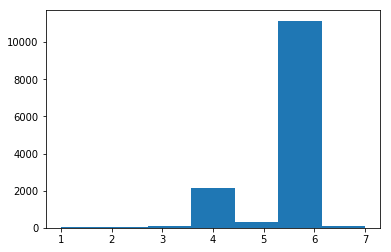

In [412]:
unique_event, counts_event = np.unique(Y_one, return_counts=True)
print (unique_event, counts_event)
counts_event_prob = counts_event/np.sum(counts_event)
print (counts_event_prob)
plt.hist(Y_one, bins = len(set(Y_one)))

In [413]:
X_test['Synopsis']

1734    B737 Captain arrives at the aircraft to find a...
555     A CRJ700 flight crew and the Dispatcher involv...
1268    A Maintenance Manager and Lead Technician repo...
136     Gulfstream V crew declines to accept an ATC cl...
1078    B737-800 Captain reported he is unsure if he c...
653     ZTL Controller reported a situation while usin...
2776    B737 departure from ONT described multiple alt...
320     A distracted MAC 145 pilot landed gear up blam...
1694    C206 PLT; EXPERIENCING ICING CONDITIONS; INITI...
97      Ramp personnel indicate that other ground crew...
820     AN SA-341G EXPERIENCED AN UNCONTROLLABLE GND R...
1555    A PA28 PILOT WITH AN ENG FAILURE LANDED OFF AR...
1785    A helicopter pilot reported a line of four fai...
2100    General aviation pilot received less than idea...
2533    B757 FO REPORTS TRAILING EDGE FLAP ASYMMETRY E...
2593    C172 pilot reported difficulty successfully co...
552     The flight crew of an Airbus A321 reported the...
2636    A Main

## Model 2: Processing categorical data

In [12]:
## change column names
new_col_name = []
for col in X_org.columns:
    #print(type(col))
    new_col_name.append(col.replace('/ ', '').replace(' ', '_'))
    
X_org.columns = new_col_name


data_type = []
for item_name in X_org.keys():
    data_type.append(type(X_org[item_name][0]))

print ('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print ('The unique data types across all the items are:', set(data_type))
print ('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

for item_name in X_org.keys():
    ## find the number of NaN in this item
    no = np.sum(X_org[item_name].isna().astype(int))
    #print ('The number of {} with value equal to NaN is {}'.format(item_name, no))
    
    ## Replace the missing value with corresponding values
    if no > 0:
        if type(X_org[item_name][0]) == np.float64:
            X_org[item_name].fillna(-1, inplace = True)
        else:
            X_org[item_name].fillna('unknown', inplace = True)
X_org['Crew_Size'].head()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The unique data types across all the items are: {<class 'numpy.float64'>, <class 'float'>, <class 'str'>}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


8     2.0
13    2.0
14    2.0
17    2.0
19    2.0
Name: Crew_Size, dtype: float64

## Data Split

In [13]:
X, X_test, Y, Y_test = train_test_split(X_org, Y_org, test_size = 0.1, random_state = test_random_state)

In [14]:
## Location
Locale_Reference = tf.feature_column.categorical_column_with_hash_bucket('Locale_Reference', 
                                                                         hash_bucket_size = len(set(X['Locale_Reference'])))
State_Reference = tf.feature_column.categorical_column_with_hash_bucket('State_Reference', 
                                                                        hash_bucket_size = len(set(X['State_Reference'])))


## Environment
Flight_Conditions = tf.feature_column.categorical_column_with_hash_bucket('Flight_Conditions', 
                                                                hash_bucket_size = len(set(X['State_Reference'])))
Weather_Elements_Visibility = tf.feature_column.categorical_column_with_hash_bucket('Weather_Elements_Visibility', 
                                                            hash_bucket_size = len(set(X['Weather_Elements_Visibility'])))
Work_Environment_Factor = tf.feature_column.categorical_column_with_hash_bucket('Work_Environment_Factor', 
                                                            hash_bucket_size = len(set(X['Work_Environment_Factor'])))
Light = tf.feature_column.categorical_column_with_hash_bucket('Light', hash_bucket_size = 
                                                              len(set(X['Work_Environment_Factor'])))


## Aircraft
ATC_Advisory = tf.feature_column.categorical_column_with_hash_bucket('ATC_Advisory', 
                                                            hash_bucket_size = len(set(X['ATC_Advisory'])))
Aircraft_Operator = tf.feature_column.categorical_column_with_hash_bucket('Aircraft_Operator', 
                                                                hash_bucket_size = len(set(X['Aircraft_Operator'])))
Make_Model_Name = tf.feature_column.categorical_column_with_hash_bucket('Make_Model_Name', 
                                                            hash_bucket_size = len(set(X['Make_Model_Name'])))
Crew_Size = tf.feature_column.numeric_column('Crew_Size', [1])
Flight_Plan = tf.feature_column.categorical_column_with_hash_bucket('Flight_Plan', 
                                                            hash_bucket_size = len(set(X['Flight_Plan'])))
Mission = tf.feature_column.categorical_column_with_hash_bucket('Mission', 
                                                                hash_bucket_size = len(set(X['Mission'])))
Flight_Phase1 = tf.feature_column.categorical_column_with_hash_bucket('Flight_Phase1', 
                                                                      hash_bucket_size = len(set(X['Flight_Phase1'])))
Route_In_Use = tf.feature_column.categorical_column_with_hash_bucket('Route_In_Use', 
                                                                     hash_bucket_size = len(set(X['Route_In_Use'])))
Airspace = tf.feature_column.categorical_column_with_hash_bucket('Airspace', 
                                                                 hash_bucket_size = len(set(X['Airspace'])))

## Component
Aircraft_Component = tf.feature_column.categorical_column_with_hash_bucket('Aircraft_Component', 
                                                             hash_bucket_size = len(set(X['Aircraft_Component'])))
Manufacturer = tf.feature_column.categorical_column_with_hash_bucket('Manufacturer', 
                                                        hash_bucket_size = len(set(X['Manufacturer'])))

## Person
Location_Of_Person = tf.feature_column.categorical_column_with_hash_bucket('Location_Of_Person', 
                                                                hash_bucket_size = len(set(X['Location_Of_Person'])))
Location_In_Aircraft = tf.feature_column.categorical_column_with_hash_bucket('Location_In_Aircraft',
                                                            hash_bucket_size = len(set(X['Location_In_Aircraft'])))
Reporter_Organization = tf.feature_column.categorical_column_with_hash_bucket('Reporter_Organization',
                                                            hash_bucket_size = len(set(X['Reporter_Organization'])))
Function = tf.feature_column.categorical_column_with_hash_bucket('Function', hash_bucket_size = len(set(X['Function'])))
Qualification = tf.feature_column.categorical_column_with_hash_bucket('Qualification', 
                                                                      hash_bucket_size = len(set(X['Qualification'])))
Human_Factors = tf.feature_column.categorical_column_with_hash_bucket('Human_Factors', 
                                                                      hash_bucket_size = len(set(X['Human_Factors'])))

## Events
Anomaly = tf.feature_column.categorical_column_with_hash_bucket('Anomaly', 
                                                                hash_bucket_size = len(set(X['Anomaly'])))
Detector = tf.feature_column.categorical_column_with_hash_bucket('Detector', 
                                                                 hash_bucket_size = len(set(X['Detector'])))
When_Detected = tf.feature_column.categorical_column_with_hash_bucket('When_Detected', 
                                                                      hash_bucket_size = len(set(X['When_Detected'])))
Were_Passengers_Involved_In_Event = tf.feature_column.categorical_column_with_hash_bucket('Were_Passengers_Involved_In_Event',
                                                    hash_bucket_size = len(set(X['Were_Passengers_Involved_In_Event'])))

## Assessments
Contributing_Factors_Situations = tf.feature_column.categorical_column_with_hash_bucket('Contributing_Factors_Situations', 
                                                   hash_bucket_size = len(set(X['Contributing_Factors_Situations'])))
Primary_Problem = tf.feature_column.categorical_column_with_hash_bucket('Primary_Problem', 
                                                        hash_bucket_size = len(set(X['Primary_Problem'])))

## Place
Locale_Reference = tf.feature_column.embedding_column(Locale_Reference, len(set(X['Locale_Reference'])))
State_Reference = tf.feature_column.embedding_column(State_Reference, len(set(X['State_Reference'])))


## Environment
Flight_Conditions = tf.feature_column.embedding_column(Flight_Conditions,  len(set(X['Flight_Conditions'])))
Weather_Elements_Visibility = tf.feature_column.embedding_column(Weather_Elements_Visibility,  
                                                                 len(set(X['Weather_Elements_Visibility'])))
Work_Environment_Factor = tf.feature_column.embedding_column(Work_Environment_Factor,  len(set(X['Work_Environment_Factor'])))
Light = tf.feature_column.embedding_column(Light, len(set(X['Light'])))


## Aircraft
ATC_Advisory = tf.feature_column.embedding_column(ATC_Advisory, len(set(X['ATC_Advisory'])))
Aircraft_Operator = tf.feature_column.embedding_column(Aircraft_Operator, len(set(X['Aircraft_Operator'])))
Make_Model_Name = tf.feature_column.embedding_column(Make_Model_Name, len(set(X['Make_Model_Name'])))
Flight_Plan = tf.feature_column.embedding_column(Flight_Plan, len(set(X['Flight_Plan'])))
Mission = tf.feature_column.embedding_column(Mission, len(set(X['Mission'])))
Flight_Phase1 = tf.feature_column.embedding_column(Flight_Phase1, len(set(X['Flight_Phase1'])))
Route_In_Use = tf.feature_column.embedding_column(Route_In_Use, len(set(X['Route_In_Use'])))
Airspace = tf.feature_column.embedding_column(Airspace, len(set(X['Airspace'])))

## Component
Aircraft_Component = tf.feature_column.embedding_column(Aircraft_Component, len(set(X['Aircraft_Component'])))
Manufacturer = tf.feature_column.embedding_column(Manufacturer, len(set(X['Manufacturer'])))

## Person
Location_Of_Person = tf.feature_column.embedding_column(Location_Of_Person, len(set(X['Location_Of_Person'])))
Location_In_Aircraft = tf.feature_column.embedding_column(Location_In_Aircraft, len(set(X['Location_In_Aircraft'])))
Reporter_Organization = tf.feature_column.embedding_column(Reporter_Organization, len(set(X['Reporter_Organization'])))
Function = tf.feature_column.embedding_column(Function, len(set(X['Function'])))
Qualification = tf.feature_column.embedding_column(Qualification, len(set(X['Qualification'])))
Human_Factors = tf.feature_column.embedding_column(Human_Factors, len(set(X['Human_Factors'])))

## Events
Anomaly = tf.feature_column.embedding_column(Anomaly, len(set(X['Anomaly'])))
Detector = tf.feature_column.embedding_column(Detector, len(set(X['Detector'])))
When_Detected = tf.feature_column.embedding_column(When_Detected, len(set(X['When_Detected'])))
Were_Passengers_Involved_In_Event = tf.feature_column.embedding_column(Were_Passengers_Involved_In_Event,
                                                                       len(set(X['Were_Passengers_Involved_In_Event'])))

## Assessments
Contributing_Factors_Situations = tf.feature_column.embedding_column(Contributing_Factors_Situations,
                                                                     len(set(X['Contributing_Factors_Situations'])))
Primary_Problem = tf.feature_column.embedding_column(Primary_Problem, len(set(X['Primary_Problem'])))

In [15]:
from sklearn.model_selection import train_test_split

X_sub = X[['Locale_Reference', 'State_Reference', 'Flight_Conditions', 'Weather_Elements_Visibility', 
            'Work_Environment_Factor', 'Light', 'ATC_Advisory', 'Aircraft_Operator', 'Make_Model_Name', 
            'Crew_Size', 'Flight_Plan', 'Mission', 'Flight_Phase1',
            'Route_In_Use','Airspace', 'Aircraft_Component', 'Manufacturer', 'Location_Of_Person', 'Location_In_Aircraft',
            'Reporter_Organization', 'Function', 'Qualification', 'Human_Factors', 'Anomaly', 'Detector', 'When_Detected',
            'Were_Passengers_Involved_In_Event', 'Contributing_Factors_Situations', 'Primary_Problem']]

X_train, X_validation, Y_train, Y_validation = train_test_split(X_sub, Y, test_size = test_size_ratio, 
                                                    random_state = random_split_seed)

## extract the test data
X_test_sub = X_test[['Locale_Reference', 'State_Reference', 'Flight_Conditions', 'Weather_Elements_Visibility', 
            'Work_Environment_Factor', 'Light', 'ATC_Advisory', 'Aircraft_Operator', 'Make_Model_Name', 
            'Crew_Size', 'Flight_Plan', 'Mission', 'Flight_Phase1',
            'Route_In_Use','Airspace', 'Aircraft_Component', 'Manufacturer', 'Location_Of_Person', 'Location_In_Aircraft',
            'Reporter_Organization', 'Function', 'Qualification', 'Human_Factors', 'Anomaly', 'Detector', 'When_Detected',
            'Were_Passengers_Involved_In_Event', 'Contributing_Factors_Situations', 'Primary_Problem']]

In [16]:
label_trial = []
label_test = []
number_models = 10
for i in range(number_models):
    print ('Train the {} model, please keep waiting !!!'.format(i+1))
    print ('\n')
    
    X_train_set, X_test_tmp, Y_train_set, Y_test_tmp = train_test_split(X_train, Y_train, test_size = 0.15, random_state = 20 + i)

    ## define input function
    input_func = tf.estimator.inputs.pandas_input_fn(x = X_train_set, y = Y_train_set, batch_size = 500, 
                                                        num_epochs = 600, shuffle = True)

    ## define the feature columns
    feat_cols = [Locale_Reference, State_Reference, Flight_Conditions, Weather_Elements_Visibility, Work_Environment_Factor, 
                     Light, ATC_Advisory, Aircraft_Operator, Make_Model_Name, Crew_Size, Flight_Plan, Mission, Flight_Phase1, 
                     Route_In_Use, Airspace, Aircraft_Component, Manufacturer, Location_Of_Person, Location_In_Aircraft, 
                     Reporter_Organization, Function, Qualification, Human_Factors, Anomaly, Detector, When_Detected, 
                     Were_Passengers_Involved_In_Event, Contributing_Factors_Situations, Primary_Problem]

    ## build the model
    model = tf.estimator.DNNClassifier(hidden_units = [40, 40, 40, 40, 40, 40, 40, 40], feature_columns = feat_cols,
                                       n_classes = 6, optimizer = tf.train.AdamOptimizer(learning_rate = 0.001))
        
    ## train the model
    model.train(input_fn = input_func, steps = 4000)
    
    
    ## make predictions on the trial test data
    eval_input = tf.estimator.inputs.pandas_input_fn(x = X_validation, shuffle = False)
    prediction = list(model.predict(eval_input))
    pred_label = [int(pred['class_ids']) for pred in prediction]
    label_trial.append(pred_label)
    
    
    ## make predictions on the test data
    eval_input = tf.estimator.inputs.pandas_input_fn(x = X_test_sub, shuffle = False)
    prediction = list(model.predict(eval_input))
    pred_label = [int(pred['class_ids']) for pred in prediction]
    label_test.append(pred_label)

Train the 1 model, please keep waiting !!!


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\ZHANGX~1\\AppData\\Local\\Temp\\tmpif2zwzvh', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E14C3E3F98>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\ZHANGX~1\AppData\Local\Temp\tmpif2zwzvh\model.ckpt.
INFO:tensorflow:loss = 896.0441, step = 1
INFO:tensorflow:global_step/sec: 0.739891
INFO:tensorflow:loss = 517.9607, step = 101 (135.190 sec)
INFO:tensorflow:global_step/sec: 0.746685

INFO:tensorflow:global_step/sec: 0.661831
INFO:tensorflow:loss = 217.60481, step = 901 (150.838 sec)
INFO:tensorflow:global_step/sec: 0.751218
INFO:tensorflow:loss = 196.3775, step = 1001 (133.189 sec)
INFO:tensorflow:global_step/sec: 0.739163
INFO:tensorflow:loss = 208.34567, step = 1101 (135.237 sec)
INFO:tensorflow:global_step/sec: 0.754508
INFO:tensorflow:loss = 211.7452, step = 1201 (132.538 sec)
INFO:tensorflow:global_step/sec: 0.763248
INFO:tensorflow:loss = 182.24252, step = 1301 (131.045 sec)
INFO:tensorflow:Saving checkpoints for 1323 into C:\Users\ZHANGX~1\AppData\Local\Temp\tmpqkfbec02\model.ckpt.
INFO:tensorflow:global_step/sec: 0.691856
INFO:tensorflow:loss = 163.89084, step = 1401 (144.524 sec)
INFO:tensorflow:global_step/sec: 0.759724
INFO:tensorflow:loss = 150.01593, step = 1501 (131.630 sec)
INFO:tensorflow:global_step/sec: 0.762846
INFO:tensorflow:loss = 151.89224, step = 1601 (131.081 sec)
INFO:tensorflow:global_step/sec: 0.761088
INFO:tensorflow:loss = 138.81815, s

INFO:tensorflow:global_step/sec: 0.745907
INFO:tensorflow:loss = 98.20176, step = 2501 (134.054 sec)
INFO:tensorflow:global_step/sec: 0.755137
INFO:tensorflow:loss = 73.789665, step = 2601 (132.437 sec)
INFO:tensorflow:Saving checkpoints for 2669 into C:\Users\ZHANGX~1\AppData\Local\Temp\tmpy6fvon9x\model.ckpt.
INFO:tensorflow:global_step/sec: 0.685782
INFO:tensorflow:loss = 69.45084, step = 2701 (145.821 sec)
INFO:tensorflow:global_step/sec: 0.75195
INFO:tensorflow:loss = 72.28308, step = 2801 (132.978 sec)
INFO:tensorflow:global_step/sec: 0.762188
INFO:tensorflow:loss = 59.575077, step = 2901 (131.202 sec)
INFO:tensorflow:global_step/sec: 0.758201
INFO:tensorflow:loss = 79.25519, step = 3001 (131.891 sec)
INFO:tensorflow:global_step/sec: 0.749859
INFO:tensorflow:loss = 74.52875, step = 3101 (133.428 sec)
INFO:tensorflow:Saving checkpoints for 3112 into C:\Users\ZHANGX~1\AppData\Local\Temp\tmpy6fvon9x\model.ckpt.
INFO:tensorflow:global_step/sec: 0.665604
INFO:tensorflow:loss = 57.3974

INFO:tensorflow:Loss for final step: 38.198128.
INFO:tensorflow:Restoring parameters from C:\Users\ZHANGX~1\AppData\Local\Temp\tmpbfmeq8r1\model.ckpt-4000
INFO:tensorflow:Restoring parameters from C:\Users\ZHANGX~1\AppData\Local\Temp\tmpbfmeq8r1\model.ckpt-4000
Train the 5 model, please keep waiting !!!


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\ZHANGX~1\\AppData\\Local\\Temp\\tmpyjmh5z6f', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E141717AC8>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving check

INFO:tensorflow:global_step/sec: 0.770245
INFO:tensorflow:loss = 261.96774, step = 801 (129.828 sec)
INFO:tensorflow:global_step/sec: 0.774052
INFO:tensorflow:loss = 192.98866, step = 901 (129.187 sec)
INFO:tensorflow:Saving checkpoints for 906 into C:\Users\ZHANGX~1\AppData\Local\Temp\tmpomwfmg52\model.ckpt.
INFO:tensorflow:global_step/sec: 0.698948
INFO:tensorflow:loss = 190.2056, step = 1001 (143.072 sec)
INFO:tensorflow:global_step/sec: 0.772577
INFO:tensorflow:loss = 190.41528, step = 1101 (129.428 sec)
INFO:tensorflow:global_step/sec: 0.771399
INFO:tensorflow:loss = 180.54623, step = 1201 (129.649 sec)
INFO:tensorflow:global_step/sec: 0.772654
INFO:tensorflow:loss = 153.19878, step = 1301 (129.409 sec)
INFO:tensorflow:Saving checkpoints for 1359 into C:\Users\ZHANGX~1\AppData\Local\Temp\tmpomwfmg52\model.ckpt.
INFO:tensorflow:global_step/sec: 0.700643
INFO:tensorflow:loss = 142.19417, step = 1401 (142.936 sec)
INFO:tensorflow:global_step/sec: 0.770303
INFO:tensorflow:loss = 153.6

INFO:tensorflow:global_step/sec: 0.767961
INFO:tensorflow:loss = 70.43093, step = 2401 (130.223 sec)
INFO:tensorflow:global_step/sec: 0.769691
INFO:tensorflow:loss = 73.33386, step = 2501 (129.920 sec)
INFO:tensorflow:global_step/sec: 0.770063
INFO:tensorflow:loss = 63.681023, step = 2601 (129.855 sec)
INFO:tensorflow:global_step/sec: 0.769711
INFO:tensorflow:loss = 63.527027, step = 2701 (129.925 sec)
INFO:tensorflow:Saving checkpoints for 2713 into C:\Users\ZHANGX~1\AppData\Local\Temp\tmpccja9x89\model.ckpt.
INFO:tensorflow:global_step/sec: 0.698539
INFO:tensorflow:loss = 63.987114, step = 2801 (143.155 sec)
INFO:tensorflow:global_step/sec: 0.770343
INFO:tensorflow:loss = 83.59523, step = 2901 (129.812 sec)
INFO:tensorflow:global_step/sec: 0.769557
INFO:tensorflow:loss = 54.83306, step = 3001 (129.945 sec)
INFO:tensorflow:global_step/sec: 0.768421
INFO:tensorflow:loss = 54.34532, step = 3101 (130.138 sec)
INFO:tensorflow:Saving checkpoints for 3165 into C:\Users\ZHANGX~1\AppData\Loca

INFO:tensorflow:Loss for final step: 90.57211.
INFO:tensorflow:Restoring parameters from C:\Users\ZHANGX~1\AppData\Local\Temp\tmpfnf9853j\model.ckpt-4000
INFO:tensorflow:Restoring parameters from C:\Users\ZHANGX~1\AppData\Local\Temp\tmpfnf9853j\model.ckpt-4000
Train the 9 model, please keep waiting !!!


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\ZHANGX~1\\AppData\\Local\\Temp\\tmpllk_bx06', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E159298908>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkp

INFO:tensorflow:global_step/sec: 0.771545
INFO:tensorflow:loss = 215.13745, step = 801 (129.612 sec)
INFO:tensorflow:global_step/sec: 0.771125
INFO:tensorflow:loss = 176.69237, step = 901 (129.799 sec)
INFO:tensorflow:Saving checkpoints for 909 into C:\Users\ZHANGX~1\AppData\Local\Temp\tmp0as7o1nx\model.ckpt.
INFO:tensorflow:global_step/sec: 0.694144
INFO:tensorflow:loss = 198.03772, step = 1001 (143.937 sec)
INFO:tensorflow:global_step/sec: 0.772783
INFO:tensorflow:loss = 156.95502, step = 1101 (129.414 sec)
INFO:tensorflow:global_step/sec: 0.770896
INFO:tensorflow:loss = 135.0501, step = 1201 (129.717 sec)
INFO:tensorflow:global_step/sec: 0.772795
INFO:tensorflow:loss = 133.42398, step = 1301 (129.393 sec)
INFO:tensorflow:Saving checkpoints for 1362 into C:\Users\ZHANGX~1\AppData\Local\Temp\tmp0as7o1nx\model.ckpt.
INFO:tensorflow:global_step/sec: 0.697932
INFO:tensorflow:loss = 180.3972, step = 1401 (143.279 sec)
INFO:tensorflow:global_step/sec: 0.770504
INFO:tensorflow:loss = 113.27

In [17]:
ensembel_trial_pred = []
for j in range(len(label_trial[0])):
    x = np.zeros(shape = (len(label_trial), 1)) - 1
    for i in range(len(label_trial)):
        x[i] =  label_trial[i][j]
    (values, counts) = np.unique(x, return_counts=True)
    ind = np.argmax(counts)
    ensembel_trial_pred.append((values[ind]))

from sklearn.metrics import classification_report
target_names = [str(i) for i in range(1, 5+1)]
print(classification_report(Y_validation, ensembel_trial_pred, target_names=target_names))

             precision    recall  f1-score   support

          1       0.67      0.59      0.63       947
          2       0.83      0.91      0.87      1017
          3       0.57      0.53      0.55       988
          4       0.85      0.88      0.86      1034
          5       0.81      0.83      0.82       976

avg / total       0.75      0.75      0.75      4962



## Compute the performance metrics of two individual models on the trial test data

In [18]:
validation_list = list(Y_validation)
dict_count = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
common_count = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
for i in range(len(ensembel_trial_pred)):
    if ensembel_trial_pred[i] == pred_label_SVM[i]:
        dict_count[ensembel_trial_pred[i]] += 1
        if ensembel_trial_pred[i] == validation_list[i]:
            common_count[ensembel_trial_pred[i]] += 1

In [19]:
## compute the accuracy for the commonly records identified by the two classifiers
print (dict_count)
print (common_count)
accuracy = []
for (key, val) in dict_count.items():
    common_acuracy = common_count[key]/dict_count[key]
    print (key, val)
    accuracy.append(common_acuracy)
accuracy = np.array(accuracy)
print (accuracy)
count_consis = [389, 811, 359, 772, 791]
count_consis

{1: 478, 2: 984, 3: 482, 4: 937, 5: 836}
{1: 390, 2: 920, 3: 362, 4: 893, 5: 784}
1 478
2 984
3 482
4 937
5 836
[0.81589958 0.93495935 0.75103734 0.95304162 0.93779904]


[389, 811, 359, 772, 791]

## Construct hybrid model

In [20]:
## The predictions from the trainde SVM model on the test data
pred_label_test_SVM = gs_clf.predict(X_test['Synopsis']) 
SVM_prob = gs_clf.predict_proba(X_test['Synopsis'])

## The predictions from deep learning ensemble on the test data
ensembel_test_pred = []
ensembel_prob = []
ensembel_prob_full = []
for j in range(len(label_test[0])):
    x = np.zeros(shape = (len(label_test), 1)) - 1
    for i in range(len(label_test)):
        x[i] =  label_test[i][j]
    (values, counts) = np.unique(x, return_counts=True)
    #print (values, counts)
    prob_tmp = np.zeros(shape = 5)
    
    for j in range(len(values)):
        prob_tmp[int(values[j]-1)] = counts[j]/10
    ensembel_prob_full.append(prob_tmp)    
    #print (prob_tmp)
    
    ind = np.argmax(counts)
    ensembel_test_pred.append((values[ind]))
    ensembel_prob.append(counts[ind]/10)
    
ensembel_prob_full = np.array(ensembel_prob_full)
print (SVM_prob[0])

[0. 1. 0. 0. 0.]


In [394]:
## Blend the predictions from the two models

final_pred = []

model_NN = np.array([[0.66, 0.62, 0.62, 947],
            [0.83, 0.90, 0.88, 1017],
            [0.60, 0.49, 0.55, 988],
            [0.84, 0.90, 0.87, 1034],
            [0.79, 0.89, 0.85, 976],
           ])
model_SVM = np.array([[0.73, 0.57, 0.63, 947],
             [0.85, 0.93, 0.89, 1017],
             [0.66, 0.56, 0.61, 988],
             [0.81, 0.89, 0.83, 1034],
             [0.87, 0.92, 0.88, 976],
            ])

total_unidentified = 0
proportion = []
for i in range(5):
    proportion.append(model_NN[i][3] - accuracy[i]*dict_count[i + 1])
    total_unidentified += model_NN[i][3] - accuracy[i]*dict_count[i + 1]
proportion = np.array(proportion/total_unidentified)
proportion = proportion/0.2

total_count = 0
count = 0
count_class = 0


### Compute the confusion matrix from the validation dataset
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
confusion_validation_SVM = confusion_matrix(Y_validation, pred_label_SVM)
normed_matrix_SVM = normalize(confusion_validation_SVM, axis=0, norm='l1')
confusion_validation_DNN = confusion_matrix(Y_validation, ensembel_trial_pred)
normed_matrix_DNN = normalize(confusion_validation_DNN, axis=0, norm='l1')

count_SVM = 0
count_DNN = 0
count_SVM_correct = 0
count_DNN_correct = 0
for i in range(len(ensembel_test_pred)):
    if ensembel_test_pred[i] == pred_label_test_SVM[i]:
        final_pred.append(ensembel_test_pred[i])
        if ensembel_test_pred[i] == 2:
            count_class += 1
    else:
        total_count += 1
        
        ################ Method 1 ######################
        #label_ensemble = int(ensembel_test_pred[i]-1)
        #p1 = (model_NN[label_ensemble][3] - accuracy[label_ensemble]*dict_count[label_ensemble + 1]) /total_unidentified * model_NN[label_ensemble][1]*ensembel_prob[i]
        
        #label_SVM = int(pred_label_test_SVM[i]-1)
        #p2 = (model_SVM[label_SVM][3] - accuracy[label_SVM]*dict_count[label_SVM + 1]) /total_unidentified * model_SVM[label_SVM][1]*SVM_prob[i, label_SVM]
        
        #if p1 > p2:
        #    final_pred.append(label_ensemble + 1)
        #    if label_ensemble + 1 == Y_test[i]:
        #        count += 1
        #else:
        #    final_pred.append(label_SVM + 1)
        #    if label_SVM + 1 == Y_test[i]:
        #        count += 1
        
        
        ############### Method 2 ######################
        #svm_prob_i = np.multiply(np.multiply(SVM_prob[i], model_SVM[:,0]), model_NN[:,3] - np.multiply(accuracy, count_consis))/total_unidentified
        #dnn_prob_i = np.multiply(np.multiply(ensembel_prob_full[i], model_NN[:,0]), model_NN[:, 3] - np.multiply(accuracy, count_consis))/total_unidentified
        #svm_prob_i = svm_prob_i/np.sum(svm_prob_i)
        #dnn_prob_i = dnn_prob_i/np.sum(svm_prob_i)
        
        
        #print (svm_prob_i)
        #print (np.argmax(svm_prob_i))
        #print (dnn_prob_i)
        
        #if np.max(svm_prob_i) > np.max(dnn_prob_i):
        #    final_pred.append(np.argmax(svm_prob_i)+1)
        #    if np.argmax(svm_prob_i) + 1 == Y_test[i]:
        #        count += 1
        #else:
        #    final_pred.append(np.argmax(dnn_prob_i)+1)
        #    if np.argmax(dnn_prob_i) + 1 == Y_test[i]:
        #        count += 1
        
        #################  Method 3  ###################
        productSVM = np.multiply(SVM_prob[i], proportion)
        productSVM = productSVM/np.sum(productSVM)
        svm_prob_i = np.dot(normed_matrix_SVM, np.multiply(SVM_prob[i], proportion))
        svm_prob_i = svm_prob_i/np.sum(svm_prob_i)
        print ('SVM prob: ---------------->  ', svm_prob_i)
        
        productDNN = np.multiply(ensembel_prob_full[i], proportion)
        productDNN = productDNN/np.sum(productDNN)
        dnn_prob_i = np.dot(normed_matrix_DNN, productDNN)
        print ('DNN prob: ---------------->  ', np.sum(dnn_prob_i))
        
        if np.max(svm_prob_i) > np.max(dnn_prob_i):
            final_pred.append(np.argmax(svm_prob_i)+1)
            if np.argmax(svm_prob_i) + 1 == Y_test[i]:
                count += 1
                count_SVM_correct += 1
            count_SVM += 1
        else:
            final_pred.append(np.argmax(dnn_prob_i)+1)
            if np.argmax(dnn_prob_i) + 1 == Y_test[i]:
                count += 1
                count_DNN_correct += 1
            count_DNN += 1

SVM prob: ---------------->   [0.20789699 0.07437517 0.5873185  0.09516778 0.03524156]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.35618761 0.19608272 0.38760484 0.03064958 0.02947525]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.43840214 0.01911284 0.25841751 0.02765354 0.25641396]
DNN prob: ---------------->   1.0000000000000002
SVM prob: ---------------->   [0.52849992 0.02315918 0.38541471 0.03187876 0.03104742]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.28023677 0.02678024 0.54716548 0.11124584 0.03457167]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.59645524 0.04329238 0.18155798 0.15379051 0.0249039 ]
DNN prob: ---------------->   1.0000000000000002
SVM prob: ---------------->   [0.1307466  0.01992088 0.34317737 0.23988641 0.26626873]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.14880035 0.0211671  0.39751834 0.40360156 0.02891265]
DNN prob: ---------------->   1.0
SV

DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.04019608 0.01176471 0.05784314 0.0245098  0.86568627]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.13511276 0.0247381  0.36088456 0.04049263 0.43877196]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.24906943 0.02205637 0.38345282 0.0356481  0.30977329]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.16950278 0.02348115 0.4657675  0.31001565 0.03123291]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.45029026 0.02446098 0.44140312 0.05152703 0.0323186 ]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.17450727 0.02420617 0.48337656 0.23474331 0.08316669]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.298701   0.02486669 0.48376128 0.16000452 0.0326665 ]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.13312139 0.02015697 0.35080934 0.2384842  0.25742811]
DNN prob: ---------------->   1.

SVM prob: ---------------->   [0.06252683 0.5792927  0.05790365 0.01210383 0.28817298]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.37612958 0.02590761 0.49903492 0.03887207 0.06005582]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.31788141 0.04196038 0.56264405 0.04223878 0.03527538]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.17275641 0.1497267  0.46395464 0.13602345 0.07753881]
DNN prob: ---------------->   1.0000000000000002
SVM prob: ---------------->   [0.25350285 0.11932924 0.25530894 0.34709115 0.02476782]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.23181349 0.02955449 0.64238501 0.04703431 0.0492127 ]
DNN prob: ---------------->   0.9999999999999998
SVM prob: ---------------->   [0.49320896 0.0552345  0.38889373 0.03183062 0.03083218]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.31504527 0.06466664 0.51523346 0.05730125 0.04775338]
DNN prob: ---------------->   1.0
SV

SVM prob: ---------------->   [0.39507164 0.08465452 0.33032842 0.02999091 0.15995451]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.55152805 0.02106468 0.31546287 0.08298125 0.02896315]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.25154556 0.02500329 0.49726251 0.19340354 0.0327851 ]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.37673484 0.02258503 0.39719151 0.17307254 0.03041608]
DNN prob: ---------------->   0.9999999999999998
SVM prob: ---------------->   [0.3378715  0.01994658 0.30592624 0.10140243 0.23485324]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.49390919 0.01625282 0.15338507 0.02236588 0.31408704]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.49458582 0.02064014 0.31334759 0.14290915 0.0285173 ]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.5034376  0.02060696 0.30124207 0.02860039 0.14611298]
DNN prob: ---------------->   1.0
SVM prob: -------

SVM prob: ---------------->   [0.37089064 0.02446628 0.4571154  0.11523391 0.03229377]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.10122394 0.1156936  0.18546958 0.02703113 0.57058175]
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   [0.1944006  0.02674814 0.55109357 0.04361978 0.18413791]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.22327349 0.14192864 0.4164722  0.18865473 0.02967095]
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   [0.19244257 0.0378751  0.47168709 0.07937503 0.21862021]
DNN prob: ---------------->   1.0000000000000002
SVM prob: ---------------->   [0.61669119 0.16201301 0.17805753 0.01865164 0.02458664]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.38375294 0.02538849 0.48341152 0.07422685 0.0332202 ]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.2430221  0.02513912 0.50317521 0.19574599 0.03291759]
DNN prob: -----------

SVM prob: ---------------->   [0.40837174 0.02587627 0.49383164 0.03820337 0.03371697]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.4874715  0.29802883 0.17395096 0.0173436  0.02320511]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.42383477 0.02300665 0.39360023 0.03367469 0.12588366]
DNN prob: ---------------->   1.0000000000000002
SVM prob: ---------------->   [0.2266328  0.06951352 0.47249158 0.19966479 0.03169731]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.35101628 0.01467137 0.13170505 0.18705225 0.31555505]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.29586201 0.01422587 0.1150792  0.08957807 0.48525486]
DNN prob: ---------------->   1.0000000000000002
SVM prob: ---------------->   [0.70014956 0.03124051 0.19670878 0.02111061 0.05079055]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.39118265 0.13616888 0.40965127 0.03241032 0.03058688]
DNN prob: ---------------->   1.0000

SVM prob: ---------------->   [0.47600996 0.07275965 0.38887183 0.03169178 0.03066679]
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   [0.36345156 0.01496234 0.12591358 0.02298233 0.4726902 ]
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   [0.63792209 0.0185902  0.22123136 0.09573313 0.02652322]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.04712612 0.01153999 0.07398664 0.31084462 0.55650263]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.06751547 0.01203495 0.063596   0.02438071 0.83247287]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.19437822 0.05114918 0.54615696 0.12596589 0.08234974]
DNN prob: ---------------->   1.0000000000000002
SVM prob: ---------------->   [0.33168705 0.02379486 0.44381305 0.16909709 0.03160795]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.18611638 0.15908371 0.50686652 0.08187864 0.06605475]
DNN prob: -----------

SVM prob: ---------------->   [0.35607495 0.01448462 0.14462601 0.41823585 0.06657856]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.55322873 0.03132148 0.34694047 0.0385546  0.02995473]
DNN prob: ---------------->   1.0000000000000002
SVM prob: ---------------->   [0.53873788 0.0384889  0.3377039  0.02932759 0.05574173]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.44650039 0.04166567 0.15998477 0.25234003 0.09950913]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.32198904 0.1671228  0.13319438 0.35652332 0.02117046]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.47253197 0.03688706 0.39625688 0.032827   0.06149709]
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   [0.04019608 0.01176471 0.05784314 0.0245098  0.86568627]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.43934838 0.05629531 0.40106315 0.07243238 0.03086077]
DNN prob: ---------------->   1.0
SV

DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.22487792 0.12106536 0.09601441 0.02444218 0.53360014]
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   [0.32420148 0.02753532 0.56141696 0.04227408 0.04457216]
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   [0.39395582 0.05602757 0.39578365 0.03347559 0.12075738]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.24287112 0.04871188 0.62587907 0.04575322 0.03678471]
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   [0.20844566 0.04686171 0.48797915 0.0402416  0.21647188]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.09808123 0.01726701 0.24217964 0.0705171  0.57195502]
DNN prob: ---------------->   1.0
SVM prob: ---------------->   [0.51083798 0.18489384 0.21798014 0.06119136 0.02509668]
DNN prob: ---------------->   1.0000000000000002
SVM prob: ---------------->   [0.25929227 0.01783624 0.2376

In [395]:
count_SVM/total_count

0.567747667703243

In [396]:
count_SVM_correct/count_SVM

0.594679186228482

In [397]:
count_DNN_correct/count_DNN

0.4398766700924974

In [398]:
print ('Classification report on Hybrid model:')
print(classification_report(Y_test, final_pred, target_names=target_names))

Classification report on Hybrid model:
             precision    recall  f1-score   support

          1       0.67      0.69      0.68      1632
          2       0.93      0.91      0.92      1877
          3       0.65      0.65      0.65      1856
          4       0.91      0.88      0.90      1950
          5       0.86      0.90      0.88      1873

avg / total       0.81      0.81      0.81      9188



In [380]:
print ('Classification report on SVM:')
print(classification_report(Y_test, pred_label_test_SVM, target_names=target_names))

Classification report on SVM:
             precision    recall  f1-score   support

          1       0.71      0.58      0.64      1632
          2       0.86      0.93      0.89      1877
          3       0.67      0.57      0.62      1856
          4       0.79      0.91      0.85      1950
          5       0.86      0.91      0.89      1873

avg / total       0.78      0.79      0.78      9188



In [381]:
print ('Classification report on deep learning:')
print(classification_report(Y_test, ensembel_test_pred, target_names=target_names))

Classification report on deep learning:
             precision    recall  f1-score   support

          1       0.65      0.58      0.62      1632
          2       0.84      0.91      0.87      1877
          3       0.58      0.53      0.55      1856
          4       0.84      0.88      0.86      1950
          5       0.81      0.85      0.83      1873

avg / total       0.75      0.76      0.75      9188



In [399]:
from sklearn.metrics import confusion_matrix
print ('Confusion matrix of hybrid model: \n', confusion_matrix(Y_test, final_pred))

Confusion matrix of hybrid model: 
 [[1118   57  353   34   70]
 [  55 1700   73   12   37]
 [ 397   41 1209   97  112]
 [  51    4  125 1717   53]
 [  46   24   92   20 1691]]


In [400]:
from sklearn.metrics import confusion_matrix
print ('Confusion matrix of deep learning: \n', confusion_matrix(Y_test, ensembel_test_pred))

Confusion matrix of deep learning: 
 [[ 954  127  393   68   90]
 [  53 1704   60   15   45]
 [ 385  114  982  201  174]
 [  29   22  116 1725   58]
 [  43   58  133   50 1589]]


In [401]:
from sklearn.metrics import confusion_matrix
print ('Confusion matrix of support vector machine: \n', confusion_matrix(Y_test, pred_label_test_SVM))

Confusion matrix of support vector machine: 
 [[ 944  130  345  127   86]
 [  35 1748   47   25   22]
 [ 283  112 1062  283  116]
 [  35   14   78 1780   43]
 [  31   40   62   32 1708]]


In [402]:
count/total_count

0.5277654375832963

Confusion matrix, without normalization
[[1118   57  353   34   70]
 [  55 1700   73   12   37]
 [ 397   41 1209   97  112]
 [  51    4  125 1717   53]
 [  46   24   92   20 1691]]


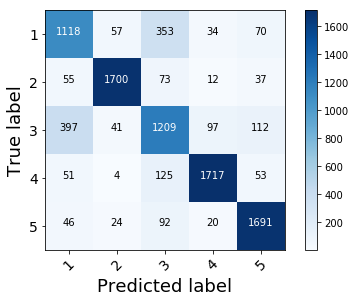

In [403]:
import matplotlib.pyplot as plt
import itertools

% matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 14, fontweight ='medium')
    plt.yticks(tick_marks, classes, fontsize = 14, fontweight ='medium')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=18, fontweight = 'medium')
    plt.xlabel('Predicted label', fontsize=18, fontweight = 'medium')
    
    
#plt.subplot(131)   
plot_confusion_matrix(confusion_matrix(Y_test, final_pred), classes=target_names)

plt.savefig('hybrid.pdf',bbox_inches='tight')

Confusion matrix, without normalization
[[ 954  127  393   68   90]
 [  53 1704   60   15   45]
 [ 385  114  982  201  174]
 [  29   22  116 1725   58]
 [  43   58  133   50 1589]]


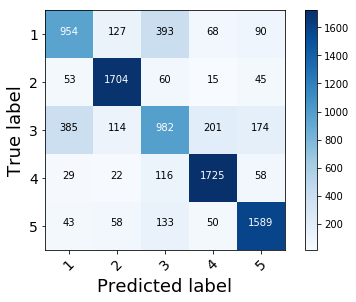

In [404]:
plot_confusion_matrix(confusion_matrix(Y_test, ensembel_test_pred), classes=target_names)

plt.savefig('dnn.pdf')

Confusion matrix, without normalization
[[ 944  130  345  127   86]
 [  35 1748   47   25   22]
 [ 283  112 1062  283  116]
 [  35   14   78 1780   43]
 [  31   40   62   32 1708]]


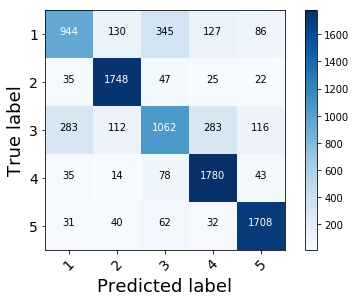

In [405]:
plot_confusion_matrix(confusion_matrix(Y_test, pred_label_test_SVM), classes=target_names)
plt.savefig('svm.pdf')

## Construct event-level decision tree

In [ ]:
rate_five = ['General Declared Emergency', 'General Physical Injury / Incapacitation', 'Flight Crew Inflight Shutdown', 
             'Air Traffic Control Separated Traffic', 'Aircraft Aircraft Damaged']

rate_four = ['General Evacuated', 'Flight Crew Regained Aircraft Control', 
              'Air Traffic Control Issued Advisory / Alert', 'Flight Crew Landed in Emergency Condition',
              'Flight Crew Landed In Emergency Condition']

rate_three = ['General Work Refused', 'Flight Crew Became Reoriented', 'Flight Crew Diverted', 
             'Flight Crew Executed Go Around / Missed Approach', 
             'Flight Crew Overcame Equipment Problem', 'Flight Crew Rejected Takeoff', 'Flight Crew Took Evasive Action', 
             'Air Traffic Control Issued New Clearance']

rate_two = ['General Maintenance Action', 'General Flight Cancelled / Delayed', 
              'General Release Refused / Aircraft Not Accepted', 
              'Flight Crew Overrode Automation', 'Flight Crew FLC Overrode Automation',
              'Flight Crew Exited Penetrated Airspace', 
              'Flight Crew Requested ATC Assistance / Clarification', 'Flight Crew Landed As Precaution',
              'Flight Crew Returned To Clearance', 'Flight Crew Returned To Departure Airport',
              'Aircraft Automation Overrode Flight Crew']

rate_one = ['General Police / Security Involved', 'Flight Crew Returned To Gate', 'Aircraft Equipment Problem Dissipated', 
            'unknown', 'Air Traffic Control Provided Assistance',
            'General None Reported / Taken', 'Flight Crew FLC complied w / Automation / Advisory']

X_five = []
X_four = []
X_three = []
X_two = []
X_one = []

Y_five = []
Y_four = []
Y_three = []
Y_two = []
Y_one = []

for i in range(len(X_train.index)):
    print (X_train.index[i])
    print (Y_train[X_train.index][i])
    outcome = X_train['res'][i].tolist()
    
    if Y_train[X_train.index][i] == 5:
        # find the location of event outcome in the corresponding risk category
        item = set(outcome).intersection(rate_five)
        item = list(item)
        
        if len(item) > 1:
            item = item[0]
            
        item = "".join(item)
        if item in rate_five:
            print ('Find it')
        label_five = rate_five.index(item) + 1
        X_five.append(X_train['Synopsis'][i])
        Y_five.append(label_five)
        
    elif Y_train[X_train.index][i] == 4:
        # find the location of event outcome in the corresponding risk category
        item = set(outcome).intersection(rate_four)
        item = list(item)
        
        if len(item) > 1:
            item = item[0]
            
        item = "".join(item)
        if item in rate_four:
            print ('Find it')
        label_four = rate_four.index(item) + 1
        X_four.append(X_train['Synopsis'][i])
        Y_four.append(label_four)
        
    elif Y_train[X_train.index][i] == 3:
        # find the location of event outcome in the corresponding risk category
        item = set(outcome).intersection(rate_three)
        item = list(item)
        
        if len(item) > 1:
            item = item[0]
            
        item = "".join(item)
        if item in rate_three:
            print ('Find it')
        label_three = rate_three.index(item) + 1
        X_three.append(X_train['Synopsis'][i])
        Y_three.append(label_three)
        
    elif Y_train[X_train.index][i] == 2:
        # find the location of event outcome in the corresponding risk category
        item = set(outcome).intersection(rate_two)
        item = list(item)
        
        if len(item) > 1:
            item = item[0]
            
        item = "".join(item)
        if item in rate_two:
            print ('Find it')
        label_two = rate_two.index(item) + 1
        X_two.append(X_train['Synopsis'][i])
        Y_two.append(label_two)
        
    elif Y_train[X_train.index][i] == 1:
        # find the location of event outcome in the corresponding risk category
        item = set(outcome).intersection(rate_one)
        item = list(item)
        
        if len(item) > 1:
            item = item[0]
            
        item = "".join(item)
        if item in rate_one:
            print ('Find it')
        label_one = rate_one.index(item) + 1
        X_one.append(X_train['Synopsis'][i])
        Y_one.append(label_one)

220
3
Find it
946
3
Find it
1023
2
Find it
1895
1
Find it
2517
2
Find it
672
3
Find it
860
5
Find it
2452
3
Find it
2393
2
Find it
2440
3
Find it
2281
2
Find it
522
4
Find it
663
3
Find it
1662
3
Find it
567
1
Find it
2256
4
Find it
1471
1
Find it
2100
3
Find it
19
1
Find it
120
2
Find it
1673
5
Find it
736
3
Find it
470
5
Find it
1400
2
Find it
378
3
Find it
609
5
Find it
1746
1
Find it
2862
1
Find it
2573
4
Find it
2353
2
Find it
907
2
Find it
393
4
Find it
1810
4
Find it
504
3
Find it
1126
3
Find it
1071
4
Find it
1474
2
Find it
22
3
Find it
2254
3
Find it
166
3
Find it
1688
2
Find it
438
5
Find it
95
4
Find it
2406
5
Find it
1550
3
Find it
2195
3
Find it
911
5
Find it
1150
4
Find it
803
5
Find it
2230
1
Find it
121
5
Find it
2507
5
Find it
2468
5
Find it
281
2
Find it
2699
1
Find it
1573
1
Find it
1870
5
Find it
1865
2
Find it
3227
2
Find it
1429
4
Find it
634
4
Find it
1517
2
Find it
578
4
Find it
1397
4
Find it
1543
1
Find it
394
5
Find it
3540
2
Find it
1854
2
Find it
1998
4
Fin

In [565]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

len(X_test['Synopsis'])

for i in range(0, 10):
    tfidf_vectorizer = TfidfVectorizer()
    raw_document = pd.Series(X_test['Synopsis'][i])
    print ('result:: --> ', final_pred[i])
    if final_pred[i] == 1:
        tfidf = tfidf_vectorizer.fit(X_one)
        tfidf_matrix = tfidf.transform(X_one)
        cosine = cosine_similarity(tfidf.transform(raw_document), tfidf_matrix)
        
        cosine_group = pd.DataFrame([cosine.flatten(), np.asarray(Y_one)])
        cosine_group = cosine_group.transpose()
        cosine_group.columns = ['Similarity', 'Outcome']
        
        group_event, group_event_counts = np.unique(Y_one, return_counts=True)
        
    elif final_pred[i] == 2:
        tfidf = tfidf_vectorizer.fit(X_two)
        tfidf_matrix = tfidf.transform(X_two)
        cosine = cosine_similarity(tfidf.transform(raw_document), tfidf_matrix)
                
        cosine_group = pd.DataFrame([cosine.flatten(), np.asarray(Y_two)])
        cosine_group = cosine_group.transpose()
        cosine_group.columns = ['Similarity', 'Outcome']
        
        group_event, group_event_counts = np.unique(Y_two, return_counts=True)
    elif final_pred[i] == 3:
        tfidf = tfidf_vectorizer.fit(X_three)
        tfidf_matrix = tfidf.transform(X_three)
        cosine = cosine_similarity(tfidf.transform(raw_document), tfidf_matrix)
                
        cosine_group = pd.DataFrame([cosine.flatten(), np.asarray(Y_three)])
        cosine_group = cosine_group.transpose()
        cosine_group.columns = ['Similarity', 'Outcome']
        
        group_event, group_event_counts = np.unique(Y_three, return_counts=True)
    elif final_pred[i] == 4:
        tfidf = tfidf_vectorizer.fit(X_four)
        tfidf_matrix = tfidf.transform(X_four)
        cosine = cosine_similarity(tfidf.transform(raw_document), tfidf_matrix)
                
        cosine_group = pd.DataFrame([cosine.flatten(), np.asarray(Y_four)])
        cosine_group = cosine_group.transpose()
        cosine_group.columns = ['Similarity', 'Outcome']
        
        group_event, group_event_counts = np.unique(Y_four, return_counts=True)
    elif final_pred[i] == 5:
        tfidf = tfidf_vectorizer.fit(X_five)
        tfidf_matrix = tfidf.transform(X_five)
        cosine = cosine_similarity(tfidf.transform(raw_document), tfidf_matrix)
                
        cosine_group = pd.DataFrame([cosine.flatten(), np.asarray(Y_five)])
        cosine_group = cosine_group.transpose()
        cosine_group.columns = ['Similarity', 'Outcome']
        
        group_event, group_event_counts = np.unique(Y_five, return_counts=True)
    
    event_prob = cosine_group.groupby(['Outcome'])['Similarity'].mean()
    event_prob = np.multiply(event_prob, group_event_counts)
    norm_event_prob = event_prob/np.sum(event_prob)
    
    print(group_event)
    print(group_event_counts)
    print(norm_event_prob)

result:: -->  2.0
[ 1  2  3  4  5  6  7  8  9 10 11]
[10573   574   202    49   301   154   953  1270  1469   381    21]
Outcome
1.0     0.685774
2.0     0.040102
3.0     0.017532
4.0     0.001938
5.0     0.020682
6.0     0.005005
7.0     0.056649
8.0     0.082906
9.0     0.065057
10.0    0.022886
11.0    0.001469
Name: Similarity, dtype: float64
result:: -->  4.0
[1 3 4 5 6]
[  325  2344 10397  2299   492]
Outcome
1.0    0.032180
3.0    0.132674
4.0    0.624555
5.0    0.187835
6.0    0.022756
Name: Similarity, dtype: float64
result:: -->  2.0
[ 1  2  3  4  5  6  7  8  9 10 11]
[10573   574   202    49   301   154   953  1270  1469   381    21]
Outcome
1.0     0.713949
2.0     0.036166
3.0     0.012131
4.0     0.001550
5.0     0.016527
6.0     0.004620
7.0     0.047558
8.0     0.079594
9.0     0.057837
10.0    0.029174
11.0    0.000893
Name: Similarity, dtype: float64
result:: -->  3
[1 2 3 4 5 6 7 8]
[ 170 2213 1661  995 2205 1068 3301 4384]
Outcome
1.0    0.011164
2.0    0.141896
3.0